In [1]:
import numpy as np
from train_ae import *
from metrics import *
from explain_cs import *
# import random
np.random.seed(1)

In [2]:
# Configure the data generation process and train the autoencoder

def gen(n = 400):
    
    x = np.zeros((n, 4))
    
    for i in range(n):
        
        if np.random.uniform() < 0.5:
            x[i, 0] = 1.0 + np.random.normal(loc = 0.0, scale = 0.2)
            
        if np.random.uniform() < 0.5:
            x[i, 1] = 1.0 + np.random.normal(loc = 0.0, scale = 0.2)
            
        x[i, 2] = np.random.normal(loc = 0.0, scale = 0.5)
        
        x[i, 3] = x[i, 0] + np.random.normal(loc = 0.0, scale = 0.05)
        
    return x

x = gen()

In [3]:
x.shape


(400, 4)

In [4]:
# rep = train_ae(x,encoder_shape = [20],output_dim = 2,decoder_shape = [20],learning_rate = 0.001,\
#              batch_size = 4,min_epochs = 100,stopping_epochs = 50,tol = 0.001,eval_freq = 1)

model = Model.Initialize('autoencoder', x, pretrained_path=None)

Wait, the model is in training...
(400, 4) (300, 4) (100, 4)
Epoch [0], Train Loss 0.351, Valid Loss 0.246
Saving best model at 0th epoch
Epoch [1], Train Loss 0.152, Valid Loss 0.120
Saving best model at 1th epoch
Epoch [2], Train Loss 0.098, Valid Loss 0.088
Saving best model at 2th epoch
Epoch [3], Train Loss 0.081, Valid Loss 0.082
Saving best model at 3th epoch
Epoch [4], Train Loss 0.075, Valid Loss 0.078
Saving best model at 4th epoch
Epoch [5], Train Loss 0.072, Valid Loss 0.075
Saving best model at 5th epoch
Epoch [6], Train Loss 0.070, Valid Loss 0.072
Saving best model at 6th epoch
Epoch [7], Train Loss 0.068, Valid Loss 0.071
Epoch [8], Train Loss 0.067, Valid Loss 0.069
Saving best model at 8th epoch
Epoch [9], Train Loss 0.066, Valid Loss 0.069
Epoch [10], Train Loss 0.065, Valid Loss 0.067
Saving best model at 10th epoch
Epoch [11], Train Loss 0.065, Valid Loss 0.067
Epoch [12], Train Loss 0.064, Valid Loss 0.066
Saving best model at 12th epoch
Epoch [13], Train Loss 0.0

Epoch [146], Train Loss 0.011, Valid Loss 0.013
Epoch [147], Train Loss 0.012, Valid Loss 0.014
Epoch [148], Train Loss 0.011, Valid Loss 0.014
Epoch [149], Train Loss 0.010, Valid Loss 0.013
Epoch [150], Train Loss 0.010, Valid Loss 0.013
Epoch [151], Train Loss 0.010, Valid Loss 0.014
Epoch [152], Train Loss 0.011, Valid Loss 0.013
Epoch [153], Train Loss 0.010, Valid Loss 0.013
Epoch [154], Train Loss 0.010, Valid Loss 0.013
Epoch [155], Train Loss 0.010, Valid Loss 0.012
Epoch [156], Train Loss 0.010, Valid Loss 0.012
Epoch [157], Train Loss 0.010, Valid Loss 0.012
Epoch [158], Train Loss 0.010, Valid Loss 0.014
Epoch [159], Train Loss 0.010, Valid Loss 0.014
Epoch [160], Train Loss 0.010, Valid Loss 0.013
Epoch [161], Train Loss 0.010, Valid Loss 0.013
Epoch [162], Train Loss 0.010, Valid Loss 0.012
Epoch [163], Train Loss 0.010, Valid Loss 0.014
Epoch [164], Train Loss 0.010, Valid Loss 0.013
Epoch [165], Train Loss 0.010, Valid Loss 0.012
Epoch [166], Train Loss 0.010, Valid Los

In [5]:
from sklearn.cluster import KMeans
num_clusters = 4

rep = model.Encode(x)
kmeans = KMeans(n_clusters = num_clusters).fit(rep)

In [6]:
import matplotlib.pyplot as plt
def plot_groups(x, data_rep, num_clusters, labels, contour = None, name = "plot_groups.png"):

    n = x.shape[0]
    cluster = -1.0 * np.ones((n))
    
    indices = [[]] * num_clusters
    centers = [[]] * num_clusters
    means = [[]] * num_clusters
    for i in range(num_clusters):
        indices[i] = []
        for j in range(n):
            if labels[j] == i:
                cluster[j] = i
                indices[i].append(j)
        means[i] = np.mean(x[indices[i], :], axis = 0)
        centers[i] = np.mean(data_rep[indices[i], :], axis = 0)
        
    centers = np.array(centers)
    means = np.array(means)

    fig, ax = plt.subplots(figsize=(20, 10))
    
    patches = []
    
    plt.scatter(data_rep[:, 0], data_rep[:, 1], c = cluster, cmap = plt.cm.coolwarm)

    for i in range(num_clusters):
        plt.text(centers[i, 0], centers[i, 1], str(i), fontsize = 72)
        
    if contour is not None:
        feature_0 = contour[0]
        feature_1 = contour[1]
        map = contour[2]
        plt.contour(feature_0, feature_1, map)
        plt.colorbar()

    plt.savefig(name)
    plt.show()
    plt.close()

    return means, centers, indices

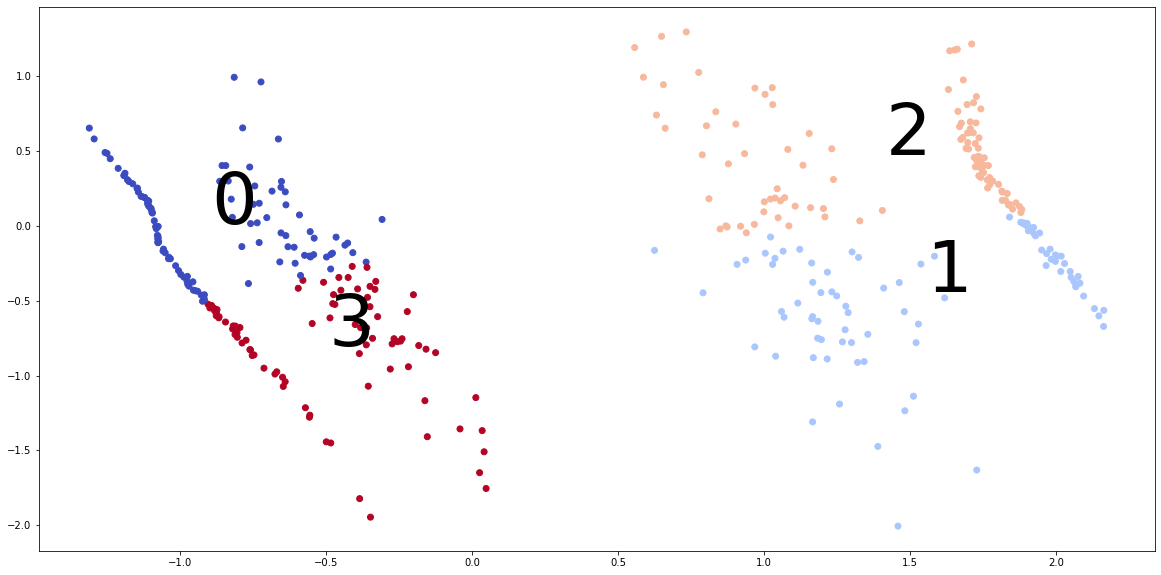

In [7]:
means, centers, indices = plot_groups(x, rep.numpy(), num_clusters, kmeans.labels_, name = "synth-rep.png")

In [8]:
# Set epsilon for our metrics
epsilon = 0.5

if True:
    eval_epsilon(model, torch.tensor(x), indices, epsilon)

In [9]:
import os
best_val = 0.0
ntrials = 10
lg = 1.5
for i in range(ntrials):
    print("Trial: ", i)
    deltas, tgt = explain(model, means, centers, learning_rate = 0.01, consecutive_steps = 5, init_mode='mean', lambda_global = lg)
    print("Deltas: ", deltas)
    a, b = metrics(model, torch.tensor(x), indices, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas.npy", deltas)
    
    os.system("rm -rf explanation")

Trial:  0
mean
[Parameter containing:
tensor([ 0.9991,  0.1728, -0.6785,  1.0028], requires_grad=True), Parameter containing:
tensor([1.0210, 0.0140, 0.1026, 1.0174], requires_grad=True), Parameter containing:
tensor([ 0.0000,  0.1403, -0.7334, -0.0082], requires_grad=True)]
iter: 0, ema: 1.1287747621536255, initial: 3, target: 2
Retrieving the best deltas...
iter: 0, ema: 1.1287747621536255
iter: 1, ema: 1.1287747621536255, initial: 3, target: 2
iter: 2, ema: 1.1287747621536255, initial: 3, target: 2
iter: 3, ema: 1.1287747609615326, initial: 3, target: 2
iter: 4, ema: 1.1287747597813607, initial: 3, target: 2
iter: 5, ema: 1.1255040330051183, initial: 0, target: 2
Retrieving the best deltas...
iter: 5, ema: 1.1255040330051183
iter: 6, ema: 1.1222098009521972, initial: 0, target: 2
Retrieving the best deltas...
iter: 6, ema: 1.1222098009521972
iter: 7, ema: 1.1188928059108914, initial: 0, target: 2
Retrieving the best deltas...
iter: 7, ema: 1.1188928059108914
iter: 8, ema: 1.11555378

iter: 135, ema: 0.8870918170539127, initial: 3, target: 1
iter: 136, ema: 0.8853269974160504, initial: 3, target: 1
iter: 137, ema: 0.8835798265706131, initial: 3, target: 1
iter: 138, ema: 0.8818501274336301, initial: 3, target: 1
iter: 139, ema: 0.880137725288017, initial: 3, target: 1
iter: 140, ema: 0.8736421896300712, initial: 3, target: 0
iter: 141, ema: 0.8672716174969255, initial: 3, target: 0
Retrieving the best deltas...
iter: 141, ema: 0.8672716174969255
iter: 142, ema: 0.8610284392441002, initial: 3, target: 0
Retrieving the best deltas...
iter: 142, ema: 0.8610284392441002
iter: 143, ema: 0.8549150606255372, initial: 3, target: 0
Retrieving the best deltas...
iter: 143, ema: 0.8549150606255372
iter: 144, ema: 0.8489338634866509, initial: 3, target: 0
Retrieving the best deltas...
iter: 144, ema: 0.8489338634866509
iter: 145, ema: 0.8485939281854483, initial: 2, target: 0
Retrieving the best deltas...
iter: 145, ema: 0.8485939281854483
iter: 146, ema: 0.8483268423772572, in

iter: 278, ema: 0.789308433956965, initial: 1, target: 3
iter: 279, ema: 0.7903463724998568, initial: 1, target: 3
iter: 280, ema: 0.7896309452166612, initial: 3, target: 1
iter: 281, ema: 0.7889226722062976, initial: 3, target: 1
iter: 282, ema: 0.7882214819260377, initial: 3, target: 1
iter: 283, ema: 0.7875273041446267, initial: 3, target: 1
iter: 284, ema: 0.7868400681410298, initial: 3, target: 1
iter: 285, ema: 0.786159704497469, initial: 3, target: 1
iter: 286, ema: 0.7854861444903437, initial: 3, target: 1
iter: 287, ema: 0.7848193200832897, initial: 3, target: 1
iter: 288, ema: 0.7841591639203063, initial: 3, target: 1
iter: 289, ema: 0.7835056093189526, initial: 3, target: 1
iter: 290, ema: 0.7795810086314752, initial: 1, target: 2
iter: 291, ema: 0.7756956536528493, initial: 1, target: 2
iter: 292, ema: 0.7718491522240097, initial: 1, target: 2
iter: 293, ema: 0.7680411158094586, initial: 1, target: 2
iter: 294, ema: 0.7642711597590529, initial: 1, target: 2
iter: 295, ema: 

iter: 401, ema: 0.703341553811877, initial: 2, target: 3
iter: 402, ema: 0.7066702245698399, initial: 2, target: 3
iter: 403, ema: 0.7099656086202231, initial: 2, target: 3
iter: 404, ema: 0.7132280388301024, initial: 2, target: 3
iter: 405, ema: 0.7089332178868011, initial: 0, target: 3
iter: 406, ema: 0.7045933430672471, initial: 0, target: 3
iter: 407, ema: 0.7002138979264076, initial: 0, target: 3
iter: 408, ema: 0.6958003111837006, initial: 0, target: 3
iter: 409, ema: 0.6914729060208915, initial: 0, target: 3
iter: 410, ema: 0.6947928464076277, initial: 2, target: 3
iter: 411, ema: 0.6980795873904966, initial: 2, target: 3
iter: 412, ema: 0.7013334609635368, initial: 2, target: 3
iter: 413, ema: 0.7045547958008466, initial: 2, target: 3
iter: 414, ema: 0.7077439160976904, initial: 2, target: 3
iter: 415, ema: 0.7042513106779015, initial: 2, target: 1
iter: 416, ema: 0.7007936313123104, initial: 2, target: 1
iter: 417, ema: 0.6973705287403753, initial: 2, target: 1
iter: 418, ema:

iter: 677, ema: 0.7697532291645374, initial: 0, target: 3
iter: 678, ema: 0.7652549463788887, initial: 0, target: 3
iter: 679, ema: 0.760705231437824, initial: 0, target: 3
iter: 680, ema: 0.7598286515689338, initial: 3, target: 1
iter: 681, ema: 0.7589608374987323, initial: 3, target: 1
iter: 682, ema: 0.7581017021652794, initial: 3, target: 1
iter: 683, ema: 0.757251158185161, initial: 3, target: 1
iter: 684, ema: 0.7564091196448438, initial: 3, target: 1
iter: 685, ema: 0.7576040025237127, initial: 0, target: 1
iter: 686, ema: 0.7587342508361831, initial: 0, target: 1
iter: 687, ema: 0.7598008053748642, initial: 0, target: 1
iter: 688, ema: 0.7608045969283924, initial: 0, target: 1
iter: 689, ema: 0.7617465463814719, initial: 0, target: 1
iter: 690, ema: 0.7679962660334714, initial: 1, target: 0
iter: 691, ema: 0.7739961403615857, initial: 1, target: 0
iter: 692, ema: 0.7797539988584825, initial: 1, target: 0
iter: 693, ema: 0.7852775951060885, initial: 1, target: 0
iter: 694, ema: 

iter: 957, ema: 0.8940944323870299, initial: 1, target: 0
iter: 958, ema: 0.9021762491696508, initial: 1, target: 0
iter: 959, ema: 0.9099825635174013, initial: 1, target: 0
iter: 960, ema: 0.903232403345198, initial: 3, target: 0
iter: 961, ema: 0.8966197295683798, initial: 3, target: 0
iter: 962, ema: 0.8901462196768517, initial: 3, target: 0
iter: 963, ema: 0.8838135337895734, initial: 3, target: 0
iter: 964, ema: 0.8776239138549483, initial: 3, target: 0
iter: 965, ema: 0.8773180484661318, initial: 0, target: 1
iter: 966, ema: 0.8769628313670524, initial: 0, target: 1
iter: 967, ema: 0.8765590505217581, initial: 0, target: 1
iter: 968, ema: 0.8761074836304702, initial: 0, target: 1
iter: 969, ema: 0.8756089024045476, initial: 0, target: 1
iter: 970, ema: 0.877358515876077, initial: 2, target: 3
iter: 971, ema: 0.8790906332128912, initial: 2, target: 3
iter: 972, ema: 0.8808054293763372, initial: 2, target: 3
iter: 973, ema: 0.8825030775781487, initial: 2, target: 3
iter: 974, ema: 

iter: 1107, ema: 0.8210057238695926, initial: 2, target: 1
iter: 1108, ema: 0.8174667813140479, initial: 2, target: 1
iter: 1109, ema: 0.8139632281840588, initial: 2, target: 1
iter: 1110, ema: 0.8175650791137355, initial: 1, target: 3
iter: 1111, ema: 0.8211309115341155, initial: 1, target: 3
iter: 1112, ema: 0.8246610856302917, initial: 1, target: 3
iter: 1113, ema: 0.828155959177599, initial: 1, target: 3
iter: 1114, ema: 0.8316158839894332, initial: 1, target: 3
iter: 1115, ema: 0.8280433360680608, initial: 1, target: 2
iter: 1116, ema: 0.8245065136259021, initial: 1, target: 2
iter: 1117, ema: 0.821005059408165, initial: 1, target: 2
iter: 1118, ema: 0.8175386197326053, initial: 1, target: 2
iter: 1119, ema: 0.8141068444538012, initial: 1, target: 2
iter: 1120, ema: 0.8136825592944043, initial: 0, target: 2
iter: 1121, ema: 0.8132086266391204, initial: 0, target: 2
iter: 1122, ema: 0.812685966751933, initial: 0, target: 2
iter: 1123, ema: 0.812115490098139, initial: 0, target: 2
i

iter: 1374, ema: 0.8286411734082227, initial: 1, target: 2
iter: 1375, ema: 0.8342762549659953, initial: 1, target: 0
iter: 1376, ema: 0.839661045307113, initial: 1, target: 0
iter: 1377, ema: 0.844814648429405, initial: 1, target: 0
iter: 1378, ema: 0.8497458468852965, initial: 1, target: 0
iter: 1379, ema: 0.8544633318254097, initial: 1, target: 0
iter: 1380, ema: 0.8536354817922966, initial: 0, target: 2
iter: 1381, ema: 0.8527620199120339, initial: 0, target: 2
iter: 1382, ema: 0.8518438260921174, initial: 0, target: 2
iter: 1383, ema: 0.8508817708449216, initial: 0, target: 2
iter: 1384, ema: 0.849875375469236, initial: 0, target: 2
iter: 1385, ema: 0.8499843561563009, initial: 2, target: 0
iter: 1386, ema: 0.8500567971740149, initial: 2, target: 0
iter: 1387, ema: 0.8500968494100614, initial: 2, target: 0
iter: 1388, ema: 0.8501086210511536, initial: 2, target: 0
iter: 1389, ema: 0.8500961786060917, initial: 2, target: 0
iter: 1390, ema: 0.8520672116968923, initial: 1, target: 3


iter: 1529, ema: 0.8124554207366973, initial: 0, target: 1
iter: 1530, ema: 0.8124724640387144, initial: 0, target: 2
iter: 1531, ema: 0.812431779682484, initial: 0, target: 2
iter: 1532, ema: 0.8123341499845667, initial: 0, target: 2
iter: 1533, ema: 0.8121803482462642, initial: 0, target: 2
iter: 1534, ema: 0.8119711424200515, initial: 0, target: 2
iter: 1535, ema: 0.8122902840212874, initial: 2, target: 0
iter: 1536, ema: 0.8126027294533982, initial: 2, target: 0
iter: 1537, ema: 0.8129117762498218, initial: 2, target: 0
iter: 1538, ema: 0.8132206901607549, initial: 2, target: 0
iter: 1539, ema: 0.8135327018947065, initial: 2, target: 0
iter: 1540, ema: 0.8145275183989757, initial: 0, target: 1
iter: 1541, ema: 0.8154609294523212, initial: 0, target: 1
iter: 1542, ema: 0.8163339651496726, initial: 0, target: 1
iter: 1543, ema: 0.8171476452850106, initial: 0, target: 1
iter: 1544, ema: 0.8179029794543757, initial: 0, target: 1
iter: 1545, ema: 0.8155048247466163, initial: 3, target: 

iter: 1775, ema: 0.8658764296625657, initial: 0, target: 3
iter: 1776, ema: 0.8600863987720069, initial: 0, target: 3
iter: 1777, ema: 0.8542885394663509, initial: 0, target: 3
iter: 1778, ema: 0.8484978738082635, initial: 0, target: 3
iter: 1779, ema: 0.8427204551325893, initial: 0, target: 3
iter: 1780, ema: 0.8385838611330975, initial: 2, target: 1
iter: 1781, ema: 0.8344886333716238, initial: 2, target: 1
iter: 1782, ema: 0.830434357887765, initial: 2, target: 1
iter: 1783, ema: 0.8264206251587447, initial: 2, target: 1
iter: 1784, ema: 0.8224470297570147, initial: 2, target: 1
iter: 1785, ema: 0.8253174920155969, initial: 2, target: 3
iter: 1786, ema: 0.8281592496515933, initial: 2, target: 3
iter: 1787, ema: 0.8309725897112297, initial: 2, target: 3
iter: 1788, ema: 0.8337577963702697, initial: 2, target: 3
iter: 1789, ema: 0.8365151497706265, initial: 2, target: 3
iter: 1790, ema: 0.8366762001171356, initial: 2, target: 0
iter: 1791, ema: 0.836809652931104, initial: 2, target: 0

iter: 1922, ema: 0.8142979811089511, initial: 2, target: 1
iter: 1923, ema: 0.8120971748980585, initial: 2, target: 1
iter: 1924, ema: 0.8099183773453212, initial: 2, target: 1
iter: 1925, ema: 0.8060333879888678, initial: 0, target: 3
iter: 1926, ema: 0.8020471361855287, initial: 0, target: 3
iter: 1927, ema: 0.7979669064585192, initial: 0, target: 3
iter: 1928, ema: 0.7937999092937295, initial: 0, target: 3
iter: 1929, ema: 0.7895532854563768, initial: 0, target: 3
iter: 1930, ema: 0.7906330051109302, initial: 2, target: 0
iter: 1931, ema: 0.7917603967452304, initial: 2, target: 0
iter: 1932, ema: 0.7929379108235849, initial: 2, target: 0
iter: 1933, ema: 0.7941679727096117, initial: 2, target: 0
iter: 1934, ema: 0.7954529847053854, initial: 2, target: 0
iter: 1935, ema: 0.7989282260432528, initial: 3, target: 2
iter: 1936, ema: 0.8023687149677415, initial: 3, target: 2
iter: 1937, ema: 0.8057747978108926, initial: 3, target: 2
iter: 1938, ema: 0.809146819825612, initial: 3, target: 

iter: 2082, ema: 0.7504834115664138, initial: 3, target: 0
iter: 2083, ema: 0.7458437202730153, initial: 3, target: 0
iter: 2084, ema: 0.7413360560113976, initial: 3, target: 0
iter: 2085, ema: 0.7456897574000599, initial: 3, target: 2
iter: 2086, ema: 0.7499999217748357, initial: 3, target: 2
iter: 2087, ema: 0.7542669833137706, initial: 3, target: 2
iter: 2088, ema: 0.7584913742373163, initial: 3, target: 2
iter: 2089, ema: 0.7626735212516265, initial: 3, target: 2
iter: 2090, ema: 0.7669799136807881, initial: 2, target: 3
iter: 2091, ema: 0.7712432445698438, initial: 2, target: 3
iter: 2092, ema: 0.7754639421500091, initial: 2, target: 3
iter: 2093, ema: 0.7796424327543727, initial: 2, target: 3
iter: 2094, ema: 0.7837791408368785, initial: 2, target: 3
iter: 2095, ema: 0.7837573786195269, initial: 3, target: 1
iter: 2096, ema: 0.7837358346203952, initial: 3, target: 1
iter: 2097, ema: 0.7837145060612549, initial: 3, target: 1
iter: 2098, ema: 0.7836933907877061, initial: 3, target:

iter: 2227, ema: 0.8574221770676255, initial: 3, target: 0
iter: 2228, ema: 0.8534278075203455, initial: 3, target: 0
iter: 2229, ema: 0.8496231413187688, initial: 3, target: 0
iter: 2230, ema: 0.8499066931544825, initial: 1, target: 3
iter: 2231, ema: 0.8501874094718391, initial: 1, target: 3
iter: 2232, ema: 0.8504653186260221, initial: 1, target: 3
iter: 2233, ema: 0.8507404486886633, initial: 1, target: 3
iter: 2234, ema: 0.851012827450678, initial: 1, target: 3
iter: 2235, ema: 0.85102891890178, initial: 2, target: 0
iter: 2236, ema: 0.8510188606211561, initial: 2, target: 0
iter: 2237, ema: 0.8509866978089737, initial: 2, target: 0
iter: 2238, ema: 0.8509364375975847, initial: 2, target: 0
iter: 2239, ema: 0.8508726728967875, initial: 2, target: 0
iter: 2240, ema: 0.8469234350603748, initial: 3, target: 0
iter: 2241, ema: 0.8431605041870583, initial: 3, target: 0
iter: 2242, ema: 0.8395853950024266, initial: 3, target: 0
iter: 2243, ema: 0.8361996076808584, initial: 3, target: 0


iter: 2397, ema: 0.7726499746282693, initial: 1, target: 3
iter: 2398, ema: 0.7742365838030377, initial: 1, target: 3
iter: 2399, ema: 0.7758073268860585, initial: 1, target: 3
iter: 2400, ema: 0.7769524828538007, initial: 3, target: 1
iter: 2401, ema: 0.7780861872618655, initial: 3, target: 1
iter: 2402, ema: 0.7792085552218961, initial: 3, target: 1
iter: 2403, ema: 0.7803196995023264, initial: 3, target: 1
iter: 2404, ema: 0.7814197323399523, initial: 3, target: 1
iter: 2405, ema: 0.7863689827780885, initial: 1, target: 0
iter: 2406, ema: 0.7911616526228541, initial: 1, target: 0
iter: 2407, ema: 0.7958044074535897, initial: 1, target: 0
iter: 2408, ema: 0.8003038450017497, initial: 1, target: 0
iter: 2409, ema: 0.804666498213567, initial: 1, target: 0
iter: 2410, ema: 0.8076084287171186, initial: 3, target: 2
iter: 2411, ema: 0.8105209399156347, initial: 3, target: 2
iter: 2412, ema: 0.8134043260021656, initial: 3, target: 2
iter: 2413, ema: 0.8162588794199241, initial: 3, target: 

iter: 154, ema: 0.6942960754148689, initial: 1, target: 0
iter: 155, ema: 0.6917185955009264, initial: 1, target: 2
iter: 156, ema: 0.6891668909821698, initial: 1, target: 2
iter: 157, ema: 0.6866407038066239, initial: 1, target: 2
iter: 158, ema: 0.6841397793969031, initial: 1, target: 2
iter: 159, ema: 0.6816638642312794, initial: 1, target: 2
iter: 160, ema: 0.6860711473647845, initial: 2, target: 3
iter: 161, ema: 0.6904343576669545, initial: 2, target: 3
iter: 162, ema: 0.6947539358661028, initial: 2, target: 3
iter: 163, ema: 0.6990303182832597, initial: 2, target: 3
iter: 164, ema: 0.703263936876245, initial: 2, target: 3
iter: 165, ema: 0.7074552180912076, initial: 2, target: 3
iter: 166, ema: 0.7116045864940205, initial: 2, target: 3
iter: 167, ema: 0.7157124600207124, initial: 2, target: 3
iter: 168, ema: 0.7197792536200445, initial: 2, target: 3
iter: 169, ema: 0.7238053780912903, initial: 2, target: 3
iter: 170, ema: 0.7249816285668166, initial: 1, target: 3
iter: 171, ema:

iter: 434, ema: 0.7886018527412549, initial: 2, target: 0
iter: 435, ema: 0.7926341059938564, initial: 3, target: 2
iter: 436, ema: 0.7966260367139318, initial: 3, target: 2
iter: 437, ema: 0.8005780481268066, initial: 3, target: 2
iter: 438, ema: 0.8044905382334596, initial: 3, target: 2
iter: 439, ema: 0.8083639034390462, initial: 3, target: 2
iter: 440, ema: 0.8055549154552234, initial: 3, target: 0
iter: 441, ema: 0.802945416467755, initial: 3, target: 0
iter: 442, ema: 0.8005379087571255, initial: 3, target: 0
iter: 443, ema: 0.7983348689849686, initial: 3, target: 0
iter: 444, ema: 0.7963387514304873, initial: 3, target: 0
iter: 445, ema: 0.7957068985402821, initial: 3, target: 1
iter: 446, ema: 0.7950813647750254, initial: 3, target: 1
iter: 447, ema: 0.7944620863474213, initial: 3, target: 1
iter: 448, ema: 0.7938490007040933, initial: 3, target: 1
iter: 449, ema: 0.7932420459171985, initial: 3, target: 1
iter: 450, ema: 0.7902288799398189, initial: 1, target: 2
iter: 451, ema:

iter: 579, ema: 0.7874707804363944, initial: 1, target: 2
iter: 580, ema: 0.784655202227787, initial: 2, target: 1
iter: 581, ema: 0.781867780397312, initial: 2, target: 1
iter: 582, ema: 0.7791082333811883, initial: 2, target: 1
iter: 583, ema: 0.7763762818352259, initial: 2, target: 1
iter: 584, ema: 0.773671650996816, initial: 2, target: 1
iter: 585, ema: 0.769942146410447, initial: 0, target: 3
iter: 586, ema: 0.7661318645389901, initial: 0, target: 3
iter: 587, ema: 0.7622478862461355, initial: 0, target: 3
iter: 588, ema: 0.7582972200968203, initial: 0, target: 3
iter: 589, ema: 0.7542868045703325, initial: 0, target: 3
iter: 590, ema: 0.7568135285236831, initial: 1, target: 3
iter: 591, ema: 0.7593149864295932, initial: 1, target: 3
iter: 592, ema: 0.7617914297564441, initial: 1, target: 3
iter: 593, ema: 0.7642431086500265, initial: 1, target: 3
iter: 594, ema: 0.7666702707546731, initial: 1, target: 3
iter: 595, ema: 0.769073162430366, initial: 1, target: 3
iter: 596, ema: 0.7

iter: 865, ema: 0.962611898174541, initial: 3, target: 2
iter: 866, ema: 0.9662243641880653, initial: 3, target: 2
iter: 867, ema: 0.9698007055414545, initial: 3, target: 2
iter: 868, ema: 0.9733412834813097, initial: 3, target: 2
iter: 869, ema: 0.9768464556417663, initial: 3, target: 2
iter: 870, ema: 0.9835133722594361, initial: 2, target: 0
iter: 871, ema: 0.9903438784141612, initial: 2, target: 0
iter: 872, ema: 0.9973392707590937, initial: 2, target: 0
iter: 873, ema: 1.0045008258282973, initial: 2, target: 0
iter: 874, ema: 1.011829803814216, initial: 2, target: 0
iter: 875, ema: 1.0042952866608164, initial: 0, target: 3
iter: 876, ema: 0.9968510784250217, initial: 0, target: 3
iter: 877, ema: 0.9894416686262986, initial: 0, target: 3
iter: 878, ema: 0.9821222462060687, initial: 0, target: 3
iter: 879, ema: 0.9748373557552308, initial: 0, target: 3
iter: 880, ema: 0.9786170383423929, initial: 3, target: 2
iter: 881, ema: 0.9823589229115904, initial: 3, target: 2
iter: 882, ema: 

iter: 1135, ema: 1.0736326003595362, initial: 3, target: 1
iter: 1136, ema: 1.0688555228987267, initial: 3, target: 1
iter: 1137, ema: 1.0641262168085714, initial: 3, target: 1
iter: 1138, ema: 1.0594442037793177, initial: 3, target: 1
iter: 1139, ema: 1.0548090108803565, initial: 3, target: 1
iter: 1140, ema: 1.050220169910385, initial: 3, target: 1
iter: 1141, ema: 1.0456772173501132, initial: 3, target: 1
iter: 1142, ema: 1.041179694315444, initial: 3, target: 1
iter: 1143, ema: 1.0367271465111216, initial: 3, target: 1
iter: 1144, ema: 1.0323191241848424, initial: 3, target: 1
iter: 1145, ema: 1.029696084148057, initial: 1, target: 2
iter: 1146, ema: 1.0270992745116392, initial: 1, target: 2
iter: 1147, ema: 1.0245284323755393, initial: 1, target: 2
iter: 1148, ema: 1.0219832974687073, initial: 1, target: 2
iter: 1149, ema: 1.0194636139109439, initial: 1, target: 2
iter: 1150, ema: 1.0282144738541403, initial: 1, target: 0
iter: 1151, ema: 1.0366658734652692, initial: 1, target: 0


iter: 1278, ema: 1.0815122102883057, initial: 3, target: 1
iter: 1279, ema: 1.0767991876040626, initial: 3, target: 1
iter: 1280, ema: 1.0836469193379463, initial: 2, target: 0
iter: 1281, ema: 1.0906710677822011, initial: 2, target: 0
iter: 1282, ema: 1.097872792973596, initial: 2, target: 0
iter: 1283, ema: 1.1052532493089968, initial: 2, target: 0
iter: 1284, ema: 1.112813574872929, initial: 2, target: 0
iter: 1285, ema: 1.1039679522062271, initial: 3, target: 0
iter: 1286, ema: 1.095260295172282, initial: 3, target: 0
iter: 1287, ema: 1.0866955599394943, initial: 3, target: 0
iter: 1288, ema: 1.0782786528165569, initial: 3, target: 0
iter: 1289, ema: 1.070014430751053, initial: 3, target: 0
iter: 1290, ema: 1.078183750840973, initial: 2, target: 0
iter: 1291, ema: 1.0865309023138103, initial: 2, target: 0
iter: 1292, ema: 1.0950570322517013, initial: 2, target: 0
iter: 1293, ema: 1.1037632858027042, initial: 2, target: 0
iter: 1294, ema: 1.1126507883187464, initial: 2, target: 0
it

iter: 1429, ema: 1.059882996255929, initial: 0, target: 3
iter: 1430, ema: 1.0638189675381056, initial: 1, target: 0
iter: 1431, ema: 1.067478914097008, initial: 1, target: 0
iter: 1432, ema: 1.0708720656680129, initial: 1, target: 0
iter: 1433, ema: 1.0740075584970505, initial: 1, target: 0
iter: 1434, ema: 1.0768944398517772, initial: 1, target: 0
iter: 1435, ema: 1.0693326702908488, initial: 0, target: 3
iter: 1436, ema: 1.0617719133778267, initial: 0, target: 3
iter: 1437, ema: 1.0542155203901744, initial: 0, target: 3
iter: 1438, ema: 1.046666809390603, initial: 0, target: 3
iter: 1439, ema: 1.0391560590127233, initial: 0, target: 3
iter: 1440, ema: 1.0348391016225549, initial: 3, target: 1
iter: 1441, ema: 1.0305653144023346, initial: 3, target: 1
iter: 1442, ema: 1.0263342650543166, initial: 3, target: 1
iter: 1443, ema: 1.0221455261997787, initial: 3, target: 1
iter: 1444, ema: 1.0179986753298327, initial: 3, target: 1
iter: 1445, ema: 1.0186682311943323, initial: 1, target: 3


iter: 1700, ema: 1.1903561407724597, initial: 0, target: 1
iter: 1701, ema: 1.1876330941772046, initial: 0, target: 1
iter: 1702, ema: 1.18489919246803, initial: 0, target: 1
iter: 1703, ema: 1.1821548469876706, initial: 0, target: 1
iter: 1704, ema: 1.1794004673496192, initial: 0, target: 1
iter: 1705, ema: 1.177626064259604, initial: 1, target: 0
iter: 1706, ema: 1.1757909762168004, initial: 1, target: 0
iter: 1707, ema: 1.1739018194110227, initial: 1, target: 0
iter: 1708, ema: 1.1719651420820476, initial: 1, target: 0
iter: 1709, ema: 1.1699874251991147, initial: 1, target: 0
iter: 1710, ema: 1.1679750890940963, initial: 1, target: 0
iter: 1711, ema: 1.1659344869153137, initial: 1, target: 0
iter: 1712, ema: 1.1638719088756513, initial: 1, target: 0
iter: 1713, ema: 1.1617935822858647, initial: 1, target: 0
iter: 1714, ema: 1.1597056727796486, initial: 1, target: 0
iter: 1715, ema: 1.1576142837383145, initial: 1, target: 0
iter: 1716, ema: 1.1555254575093605, initial: 1, target: 0


iter: 1846, ema: 1.2969559379675886, initial: 0, target: 2
iter: 1847, ema: 1.2985678049699776, initial: 0, target: 2
iter: 1848, ema: 1.3000848143745014, initial: 0, target: 2
iter: 1849, ema: 1.3015081591361823, initial: 0, target: 2
iter: 1850, ema: 1.2963135103269936, initial: 1, target: 3
iter: 1851, ema: 1.2911708080058968, initial: 1, target: 3
iter: 1852, ema: 1.2860795344961504, initial: 1, target: 3
iter: 1853, ema: 1.2810391725294086, initial: 1, target: 3
iter: 1854, ema: 1.276049214182334, initial: 1, target: 3
iter: 1855, ema: 1.2907617354415422, initial: 2, target: 3
iter: 1856, ema: 1.3053271386407157, initial: 2, target: 3
iter: 1857, ema: 1.3197468901920832, initial: 2, target: 3
iter: 1858, ema: 1.3340224442279371, initial: 2, target: 3
iter: 1859, ema: 1.34815524987599, initial: 2, target: 3
iter: 1860, ema: 1.3443360156069053, initial: 1, target: 0
iter: 1861, ema: 1.340501263339058, initial: 1, target: 0
iter: 1862, ema: 1.3366571564006289, initial: 1, target: 0
i

iter: 1992, ema: 1.1792125293038833, initial: 2, target: 3
iter: 1993, ema: 1.1932466102181198, initial: 2, target: 3
iter: 1994, ema: 1.207140350323214, initial: 2, target: 3
iter: 1995, ema: 1.205662220459661, initial: 1, target: 0
iter: 1996, ema: 1.204325428052809, initial: 1, target: 0
iter: 1997, ema: 1.2031343652204927, initial: 1, target: 0
iter: 1998, ema: 1.2020933777751817, initial: 1, target: 0
iter: 1999, ema: 1.2012067692633142, initial: 1, target: 0
iter: 2000, ema: 1.192370301443747, initial: 0, target: 3
iter: 2001, ema: 1.183579672772514, initial: 0, target: 3
iter: 2002, ema: 1.17483892292265, initial: 0, target: 3
iter: 2003, ema: 1.1661691398221161, initial: 0, target: 3
iter: 2004, ema: 1.1575679731855717, initial: 0, target: 3
Deltas:  tensor([[ 9.9915e-01,  1.7282e-01, -6.7845e-01,  1.0028e+00],
        [ 1.0210e+00,  1.3970e-02,  1.0259e-01,  1.0174e+00],
        [ 0.0000e+00,  1.2532e-01, -7.1840e-01, -6.9879e-04]])
Trial:  2
mean
[Parameter containing:
tensor

iter: 144, ema: 0.5813940262270236, initial: 0, target: 2
iter: 145, ema: 0.5840069220977566, initial: 3, target: 1
iter: 146, ema: 0.5865936890097823, initial: 3, target: 1
iter: 147, ema: 0.5891545882526876, initial: 3, target: 1
iter: 148, ema: 0.591689878503164, initial: 3, target: 1
iter: 149, ema: 0.5941998158511356, initial: 3, target: 1
iter: 150, ema: 0.6003079444836246, initial: 3, target: 2
iter: 151, ema: 0.6063549918297887, initial: 3, target: 2
iter: 152, ema: 0.6123415687024911, initial: 3, target: 2
iter: 153, ema: 0.6182682798064666, initial: 3, target: 2
iter: 154, ema: 0.6241357237994023, initial: 3, target: 2
iter: 155, ema: 0.6282626672377541, initial: 1, target: 0
iter: 156, ema: 0.6323772232683947, initial: 1, target: 0
iter: 157, ema: 0.636484185193273, initial: 1, target: 0
iter: 158, ema: 0.6405882971892254, initial: 1, target: 0
iter: 159, ema: 0.6446942571834129, initial: 1, target: 0
iter: 160, ema: 0.6429719623123654, initial: 3, target: 0
iter: 161, ema: 

iter: 430, ema: 0.8720763996532311, initial: 2, target: 3
iter: 431, ema: 0.8776780035632693, initial: 2, target: 3
iter: 432, ema: 0.8832235914342071, initial: 2, target: 3
iter: 433, ema: 0.8887137222343425, initial: 2, target: 3
iter: 434, ema: 0.8941489517264766, initial: 2, target: 3
iter: 435, ema: 0.8932579564032426, initial: 2, target: 0
iter: 436, ema: 0.8924020607181087, initial: 2, target: 0
iter: 437, ema: 0.8915855246900138, initial: 2, target: 0
iter: 438, ema: 0.8908125621614288, initial: 2, target: 0
iter: 439, ema: 0.8900873478166319, initial: 2, target: 0
iter: 440, ema: 0.884841450527602, initial: 1, target: 2
iter: 441, ema: 0.8796480122114624, initial: 1, target: 2
iter: 442, ema: 0.8745065082784842, initial: 1, target: 2
iter: 443, ema: 0.8694164193848358, initial: 1, target: 2
iter: 444, ema: 0.8643772313801239, initial: 1, target: 2
iter: 445, ema: 0.859392570923737, initial: 2, target: 1
iter: 446, ema: 0.854457757071914, initial: 2, target: 1
iter: 447, ema: 0

iter: 586, ema: 0.9326218737126495, initial: 2, target: 0
iter: 587, ema: 0.9316262755027904, initial: 2, target: 0
iter: 588, ema: 0.9306990869541147, initial: 2, target: 0
iter: 589, ema: 0.929844234389284, initial: 2, target: 0
iter: 590, ema: 0.9328736550233727, initial: 1, target: 3
iter: 591, ema: 0.9358727814511206, initial: 1, target: 3
iter: 592, ema: 0.938841916614591, initial: 1, target: 3
iter: 593, ema: 0.9417813604264267, initial: 1, target: 3
iter: 594, ema: 0.9446914086080511, initial: 1, target: 3
iter: 595, ema: 0.9389330963734339, initial: 2, target: 1
iter: 596, ema: 0.9332323681552325, initial: 2, target: 1
iter: 597, ema: 0.9275886475172364, initial: 2, target: 1
iter: 598, ema: 0.9220013646816666, initial: 2, target: 1
iter: 599, ema: 0.9164699549724759, initial: 2, target: 1
iter: 600, ema: 0.9109758221007983, initial: 1, target: 2
iter: 601, ema: 0.9055366302598142, initial: 1, target: 2
iter: 602, ema: 0.9001518297411936, initial: 1, target: 2
iter: 603, ema: 

iter: 866, ema: 1.0109546917359662, initial: 3, target: 2
iter: 867, ema: 1.0159091947777892, initial: 3, target: 2
iter: 868, ema: 1.020814152789194, initial: 3, target: 2
iter: 869, ema: 1.025670061220485, initial: 3, target: 2
iter: 870, ema: 1.03047740937537, initial: 3, target: 2
iter: 871, ema: 1.0352366840487062, initial: 3, target: 2
iter: 872, ema: 1.0399483647832162, initial: 3, target: 2
iter: 873, ema: 1.0446129299024738, initial: 3, target: 2
iter: 874, ema: 1.049230849370539, initial: 3, target: 2
iter: 875, ema: 1.0474383627066293, initial: 2, target: 0
iter: 876, ema: 1.045754850580532, initial: 2, target: 0
iter: 877, ema: 1.0441835624650084, initial: 2, target: 0
iter: 878, ema: 1.0427277171262317, initial: 2, target: 0
iter: 879, ema: 1.0413904999506205, initial: 2, target: 0
iter: 880, ema: 1.039881775643787, initial: 0, target: 2
iter: 881, ema: 1.0383270169970371, initial: 0, target: 2
iter: 882, ema: 1.0367268631677038, initial: 0, target: 2
iter: 883, ema: 1.035

iter: 1012, ema: 1.1489266490399053, initial: 3, target: 2
iter: 1013, ema: 1.153741002887946, initial: 3, target: 2
iter: 1014, ema: 1.1585072131975065, initial: 3, target: 2
iter: 1015, ema: 1.1632257590197856, initial: 3, target: 2
iter: 1016, ema: 1.1678971217680276, initial: 3, target: 2
iter: 1017, ema: 1.1725217708887872, initial: 3, target: 2
iter: 1018, ema: 1.1771001747104322, initial: 3, target: 2
iter: 1019, ema: 1.1816327944938605, initial: 3, target: 2
iter: 1020, ema: 1.1779364901571296, initial: 2, target: 0
iter: 1021, ema: 1.174316529652569, initial: 2, target: 0
iter: 1022, ema: 1.1707767581729913, initial: 2, target: 0
iter: 1023, ema: 1.167320983055327, initial: 2, target: 0
iter: 1024, ema: 1.163952972967091, initial: 2, target: 0
iter: 1025, ema: 1.1606812809048852, initial: 0, target: 2
iter: 1026, ema: 1.1573826951580617, initial: 0, target: 2
iter: 1027, ema: 1.1540576628813544, initial: 0, target: 2
iter: 1028, ema: 1.1507066285460894, initial: 0, target: 2
i

iter: 1173, ema: 1.2946156859939033, initial: 2, target: 3
iter: 1174, ema: 1.3059965640842208, initial: 2, target: 3
iter: 1175, ema: 1.3066341296666757, initial: 1, target: 3
iter: 1176, ema: 1.307265320785399, initial: 1, target: 3
iter: 1177, ema: 1.307890199992935, initial: 1, target: 3
iter: 1178, ema: 1.3085088304083958, initial: 1, target: 3
iter: 1179, ema: 1.3091212757117947, initial: 1, target: 3
iter: 1180, ema: 1.3004550992658264, initial: 2, target: 1
iter: 1181, ema: 1.2918755851803643, initial: 2, target: 1
iter: 1182, ema: 1.283381866831803, initial: 2, target: 1
iter: 1183, ema: 1.2749730859647508, initial: 2, target: 1
iter: 1184, ema: 1.2666483935024153, initial: 2, target: 1
iter: 1185, ema: 1.2676790867390983, initial: 3, target: 1
iter: 1186, ema: 1.2686994730434145, initial: 3, target: 1
iter: 1187, ema: 1.2697096554846874, initial: 3, target: 1
iter: 1188, ema: 1.2707097361015476, initial: 3, target: 1
iter: 1189, ema: 1.2716998159122392, initial: 3, target: 1


iter: 1338, ema: 1.2074462609308259, initial: 3, target: 2
iter: 1339, ema: 1.211708715006622, initial: 3, target: 2
iter: 1340, ema: 1.208380863806072, initial: 0, target: 1
iter: 1341, ema: 1.2050486913155103, initial: 0, target: 1
iter: 1342, ema: 1.201712544135479, initial: 0, target: 1
iter: 1343, ema: 1.1983727665926074, initial: 0, target: 1
iter: 1344, ema: 1.1950296989742124, initial: 0, target: 1
iter: 1345, ema: 1.1994163198616676, initial: 3, target: 2
iter: 1346, ema: 1.203759076924434, initial: 3, target: 2
iter: 1347, ema: 1.208058404032387, initial: 3, target: 2
iter: 1348, ema: 1.2123147378692603, initial: 3, target: 2
iter: 1349, ema: 1.2165285095598577, initial: 3, target: 2
iter: 1350, ema: 1.2131136762674664, initial: 0, target: 2
iter: 1351, ema: 1.2096720860898746, initial: 0, target: 2
iter: 1352, ema: 1.2062041860059152, initial: 0, target: 2
iter: 1353, ema: 1.2027104173325396, initial: 0, target: 2
iter: 1354, ema: 1.199191218165623, initial: 0, target: 2
ite

iter: 1500, ema: 1.2561276332632254, initial: 3, target: 2
iter: 1501, ema: 1.2606423437927756, initial: 3, target: 2
iter: 1502, ema: 1.2651119072170305, initial: 3, target: 2
iter: 1503, ema: 1.26953677381495, initial: 3, target: 2
iter: 1504, ema: 1.27391739174689, initial: 3, target: 2
iter: 1505, ema: 1.271032646597579, initial: 0, target: 2
iter: 1506, ema: 1.268112670330349, initial: 0, target: 2
iter: 1507, ema: 1.2651579946663596, initial: 0, target: 2
iter: 1508, ema: 1.262169145413513, initial: 0, target: 2
iter: 1509, ema: 1.2591466431216325, initial: 0, target: 2
iter: 1510, ema: 1.256091003135042, initial: 0, target: 2
iter: 1511, ema: 1.2530027374327628, initial: 0, target: 2
iter: 1512, ema: 1.2498823504898393, initial: 0, target: 2
iter: 1513, ema: 1.2467303435247052, initial: 0, target: 2
iter: 1514, ema: 1.2435472103594243, initial: 0, target: 2
iter: 1515, ema: 1.2473336120160534, initial: 1, target: 0
iter: 1516, ema: 1.2509141539648168, initial: 1, target: 0
iter:

iter: 1665, ema: 1.4379002977941946, initial: 1, target: 0
iter: 1666, ema: 1.4400825037796467, initial: 1, target: 0
iter: 1667, ema: 1.442044169395842, initial: 1, target: 0
iter: 1668, ema: 1.4437910775172522, initial: 1, target: 0
iter: 1669, ema: 1.445328950805419, initial: 1, target: 0
iter: 1670, ema: 1.4466634511189895, initial: 1, target: 0
iter: 1671, ema: 1.4478001872743036, initial: 1, target: 0
iter: 1672, ema: 1.4487447131916302, initial: 1, target: 0
iter: 1673, ema: 1.44950252486785, initial: 1, target: 0
iter: 1674, ema: 1.4500790633398746, initial: 1, target: 0
iter: 1675, ema: 1.4445849189819961, initial: 2, target: 0
iter: 1676, ema: 1.4392421265806206, initial: 2, target: 0
iter: 1677, ema: 1.4340537818433636, initial: 2, target: 0
iter: 1678, ema: 1.4290229495207645, initial: 2, target: 0
iter: 1679, ema: 1.4241526631198105, initial: 2, target: 0
iter: 1680, ema: 1.424812582592662, initial: 1, target: 0
iter: 1681, ema: 1.4252993591486325, initial: 1, target: 0
it

iter: 1829, ema: 1.2630957544757164, initial: 3, target: 1
iter: 1830, ema: 1.2624427186552787, initial: 0, target: 3
iter: 1831, ema: 1.2615898547602755, initial: 0, target: 3
iter: 1832, ema: 1.260541348561916, initial: 0, target: 3
iter: 1833, ema: 1.259301349934161, initial: 0, target: 3
iter: 1834, ema: 1.2578739600996753, initial: 0, target: 3
iter: 1835, ema: 1.2546389393850539, initial: 0, target: 1
iter: 1836, ema: 1.251385715794159, initial: 0, target: 1
iter: 1837, ema: 1.2481147640145591, initial: 0, target: 1
iter: 1838, ema: 1.24482655517904, initial: 0, target: 1
iter: 1839, ema: 1.241521556305106, initial: 0, target: 1
iter: 1840, ema: 1.238200227355901, initial: 0, target: 1
iter: 1841, ema: 1.2348630260791225, initial: 0, target: 1
iter: 1842, ema: 1.231510403856852, initial: 0, target: 1
iter: 1843, ema: 1.228142810537583, initial: 0, target: 1
iter: 1844, ema: 1.2247606872989978, initial: 0, target: 1
iter: 1845, ema: 1.2260018511493507, initial: 3, target: 1
iter: 

iter: 1989, ema: 1.2576023473049556, initial: 3, target: 2
iter: 1990, ema: 1.2537769836553236, initial: 0, target: 1
iter: 1991, ema: 1.2499397383873283, initial: 0, target: 1
iter: 1992, ema: 1.2460910253601443, initial: 0, target: 1
iter: 1993, ema: 1.2422312507180768, initial: 0, target: 1
iter: 1994, ema: 1.2383608201202665, initial: 0, target: 1
iter: 1995, ema: 1.2344801339771692, initial: 0, target: 1
iter: 1996, ema: 1.2305895869069974, initial: 0, target: 1
iter: 1997, ema: 1.226689571965967, initial: 0, target: 1
iter: 1998, ema: 1.2227804764915924, initial: 0, target: 1
iter: 1999, ema: 1.218862685736152, initial: 0, target: 1
iter: 2000, ema: 1.2238558702114932, initial: 1, target: 0
Deltas:  tensor([[ 0.9991,  0.1728, -0.6785,  1.0028],
        [ 1.0210,  0.0140,  0.1026,  1.0174],
        [ 0.0000,  0.1403, -0.7334, -0.0082]])
Trial:  3
mean
[Parameter containing:
tensor([ 0.9991,  0.1728, -0.6785,  1.0028], requires_grad=True), Parameter containing:
tensor([1.0210, 0.01

iter: 146, ema: 0.9575341376799498, initial: 3, target: 1
iter: 147, ema: 0.9561138114141198, initial: 3, target: 1
iter: 148, ema: 0.9547076884109481, initial: 3, target: 1
iter: 149, ema: 0.9533156266378081, initial: 3, target: 1
iter: 150, ema: 0.9645110513231208, initial: 2, target: 3
iter: 151, ema: 0.9755945217615802, initial: 2, target: 3
iter: 152, ema: 0.9865671574956552, initial: 2, target: 3
iter: 153, ema: 0.9974300740249467, initial: 2, target: 3
iter: 154, ema: 1.0081843613889452, initial: 2, target: 3
iter: 155, ema: 1.0089851779255836, initial: 0, target: 1
iter: 156, ema: 1.009722059258663, initial: 0, target: 1
iter: 157, ema: 1.0103959475318143, initial: 0, target: 1
iter: 158, ema: 1.0110077754672324, initial: 0, target: 1
iter: 159, ema: 1.0115584712282615, initial: 0, target: 1
iter: 160, ema: 1.0073693048204222, initial: 1, target: 2
iter: 161, ema: 1.0032220288845684, initial: 1, target: 2
iter: 162, ema: 0.9991162251120267, initial: 1, target: 2
iter: 163, ema:

iter: 293, ema: 0.9262702003679603, initial: 0, target: 3
iter: 294, ema: 0.9199026703046074, initial: 0, target: 3
iter: 295, ema: 0.9214494300300129, initial: 1, target: 0
iter: 296, ema: 0.9230473744561379, initial: 1, target: 0
iter: 297, ema: 0.9247004883103772, initial: 1, target: 0
iter: 298, ema: 0.9264127200491301, initial: 1, target: 0
iter: 299, ema: 0.9281879726837676, initial: 1, target: 0
iter: 300, ema: 0.9247876849922235, initial: 1, target: 2
iter: 301, ema: 0.9214214001775949, initial: 1, target: 2
iter: 302, ema: 0.9180887782111126, initial: 1, target: 2
iter: 303, ema: 0.9147894818682486, initial: 1, target: 2
iter: 304, ema: 0.9115231784888133, initial: 1, target: 2
iter: 305, ema: 0.9124910284261847, initial: 0, target: 2
iter: 306, ema: 0.9133830422847603, initial: 0, target: 2
iter: 307, ema: 0.9142002782366914, initial: 0, target: 2
iter: 308, ema: 0.9149437814882219, initial: 0, target: 2
iter: 309, ema: 0.915614587985626, initial: 0, target: 2
iter: 310, ema:

iter: 428, ema: 0.8571865463752378, initial: 1, target: 0
iter: 429, ema: 0.8597932423605363, initial: 1, target: 0
iter: 430, ema: 0.8544236143230699, initial: 3, target: 0
iter: 431, ema: 0.8491992111604719, initial: 3, target: 0
iter: 432, ema: 0.8441232297862864, initial: 3, target: 0
Retrieving the best deltas...
iter: 432, ema: 0.8441232297862864
iter: 433, ema: 0.8391988351449214, initial: 3, target: 0
Retrieving the best deltas...
iter: 433, ema: 0.8391988351449214
iter: 434, ema: 0.8344291602333183, initial: 3, target: 0
Retrieving the best deltas...
iter: 434, ema: 0.8344291602333183
iter: 435, ema: 0.8305670681806601, initial: 2, target: 1
Retrieving the best deltas...
iter: 435, ema: 0.8305670681806601
iter: 436, ema: 0.8267435970485284, initial: 2, target: 1
Retrieving the best deltas...
iter: 436, ema: 0.8267435970485284
iter: 437, ema: 0.8229583606277181, initial: 2, target: 1
Retrieving the best deltas...
iter: 437, ema: 0.8229583606277181
iter: 438, ema: 0.819210977167

iter: 585, ema: 0.8852709193814039, initial: 3, target: 2
iter: 586, ema: 0.8880681561619398, initial: 3, target: 2
iter: 587, ema: 0.8908374205746704, initial: 3, target: 2
iter: 588, ema: 0.8935789935353665, initial: 3, target: 2
iter: 589, ema: 0.8962931483822699, initial: 3, target: 2
iter: 590, ema: 0.8954434145827352, initial: 2, target: 0
iter: 591, ema: 0.8946694401746856, initial: 2, target: 0
iter: 592, ema: 0.8939742542472887, initial: 2, target: 0
iter: 593, ema: 0.8933606684402361, initial: 2, target: 0
iter: 594, ema: 0.892828661282239, initial: 2, target: 0
iter: 595, ema: 0.8923806469625074, initial: 2, target: 0
iter: 596, ema: 0.8920190167204519, initial: 2, target: 0
iter: 597, ema: 0.8917461396712283, initial: 2, target: 0
iter: 598, ema: 0.8915643558744228, initial: 2, target: 0
iter: 599, ema: 0.8914759873534441, initial: 2, target: 0
iter: 600, ema: 0.8911667452249278, initial: 0, target: 2
iter: 601, ema: 0.8908027116590158, initial: 0, target: 2
iter: 602, ema:

iter: 751, ema: 0.8855465534507297, initial: 2, target: 0
iter: 752, ema: 0.8847626863268288, initial: 2, target: 0
iter: 753, ema: 0.8840410643978713, initial: 2, target: 0
iter: 754, ema: 0.883384848318712, initial: 2, target: 0
iter: 755, ema: 0.885391024783645, initial: 3, target: 2
iter: 756, ema: 0.8873771394839286, initial: 3, target: 2
iter: 757, ema: 0.8893433930372094, initial: 3, target: 2
iter: 758, ema: 0.8912899828628645, initial: 3, target: 2
iter: 759, ema: 0.8932171067902631, initial: 3, target: 2
iter: 760, ema: 0.8936592586135959, initial: 3, target: 1
iter: 761, ema: 0.8940969889186953, initial: 3, target: 1
iter: 762, ema: 0.8945303419207438, initial: 3, target: 1
iter: 763, ema: 0.8949593613927718, initial: 3, target: 1
iter: 764, ema: 0.8953840906700794, initial: 3, target: 1
iter: 765, ema: 0.8893101813920826, initial: 3, target: 0
iter: 766, ema: 0.8833728166921144, initial: 3, target: 0
iter: 767, ema: 0.877575007595437, initial: 3, target: 0
iter: 768, ema: 0

iter: 916, ema: 0.8013785421674714, initial: 2, target: 0
iter: 917, ema: 0.8015118992752843, initial: 2, target: 0
iter: 918, ema: 0.8016121851268155, initial: 2, target: 0
iter: 919, ema: 0.8016843396618083, initial: 2, target: 0
iter: 920, ema: 0.797532159508484, initial: 2, target: 1
iter: 921, ema: 0.793421501156693, initial: 2, target: 1
iter: 922, ema: 0.7893519493884198, initial: 2, target: 1
iter: 923, ema: 0.7853230931378294, initial: 2, target: 1
Retrieving the best deltas...
iter: 923, ema: 0.7853230931378294
iter: 924, ema: 0.7813345254497449, initial: 2, target: 1
Retrieving the best deltas...
iter: 924, ema: 0.7813345254497449
iter: 925, ema: 0.7851115441745871, initial: 2, target: 3
iter: 926, ema: 0.7888507927121808, initial: 2, target: 3
iter: 927, ema: 0.7925526487643987, initial: 2, target: 3
iter: 928, ema: 0.7962174862560943, initial: 2, target: 3
iter: 929, ema: 0.7998456753728731, initial: 2, target: 3
iter: 930, ema: 0.8020446292026404, initial: 0, target: 1
it

iter: 1066, ema: 0.8466950631178961, initial: 2, target: 1
iter: 1067, ema: 0.8422814184702605, initial: 2, target: 1
iter: 1068, ema: 0.837911911163171, initial: 2, target: 1
iter: 1069, ema: 0.8335860989291524, initial: 2, target: 1
iter: 1070, ema: 0.836192893741634, initial: 3, target: 2
iter: 1071, ema: 0.8387736206059907, initial: 3, target: 2
iter: 1072, ema: 0.8413285402017039, initial: 3, target: 2
iter: 1073, ema: 0.84385791060146, initial: 3, target: 2
iter: 1074, ema: 0.8463619872972185, initial: 3, target: 2
iter: 1075, ema: 0.8488410232260194, initial: 3, target: 2
iter: 1076, ema: 0.8512952687955323, initial: 3, target: 2
iter: 1077, ema: 0.85372497190935, initial: 3, target: 2
iter: 1078, ema: 0.8561303779920296, initial: 3, target: 2
iter: 1079, ema: 0.8585117300138825, initial: 3, target: 2
iter: 1080, ema: 0.8589003548411622, initial: 3, target: 1
iter: 1081, ema: 0.8592850934201691, initial: 3, target: 1
iter: 1082, ema: 0.8596659840173395, initial: 3, target: 1
ite

iter: 1224, ema: 0.821465112854751, initial: 1, target: 2
iter: 1225, ema: 0.8230677568006665, initial: 3, target: 2
iter: 1226, ema: 0.8246543754992156, initial: 3, target: 2
iter: 1227, ema: 0.8262251280107793, initial: 3, target: 2
iter: 1228, ema: 0.8277801729972273, initial: 3, target: 2
iter: 1229, ema: 0.8293196675338108, initial: 3, target: 2
iter: 1230, ema: 0.8282158507889689, initial: 0, target: 2
iter: 1231, ema: 0.8270596886323213, initial: 0, target: 2
iter: 1232, ema: 0.8258520085016743, initial: 0, target: 2
iter: 1233, ema: 0.8246241161441661, initial: 0, target: 2
iter: 1234, ema: 0.8233818850640157, initial: 0, target: 2
iter: 1235, ema: 0.8192648749854626, initial: 1, target: 2
iter: 1236, ema: 0.8151890350076951, initial: 1, target: 2
iter: 1237, ema: 0.8111539528336589, initial: 1, target: 2
iter: 1238, ema: 0.807159221481363, initial: 1, target: 2
iter: 1239, ema: 0.8032044377406132, initial: 1, target: 2
iter: 1240, ema: 0.804347084801882, initial: 1, target: 3


iter: 1376, ema: 0.7324254827674493, initial: 0, target: 2
iter: 1377, ema: 0.7331280418044828, initial: 0, target: 2
iter: 1378, ema: 0.7337712256837325, initial: 0, target: 2
iter: 1379, ema: 0.734356134796257, initial: 0, target: 2
iter: 1380, ema: 0.7374502789651097, initial: 3, target: 2
iter: 1381, ema: 0.7405134816922738, initial: 3, target: 2
iter: 1382, ema: 0.7435460523921663, initial: 3, target: 2
iter: 1383, ema: 0.7465482973850599, initial: 3, target: 2
iter: 1384, ema: 0.7495205199280245, initial: 3, target: 2
iter: 1385, ema: 0.7524630202455594, initial: 3, target: 2
iter: 1386, ema: 0.755376095559919, initial: 3, target: 2
iter: 1387, ema: 0.758260040121135, initial: 3, target: 2
iter: 1388, ema: 0.7611151452367388, initial: 3, target: 2
iter: 1389, ema: 0.7639417004932796, initial: 3, target: 2
iter: 1390, ema: 0.7639070523606079, initial: 0, target: 2
iter: 1391, ema: 0.7638194295861396, initial: 0, target: 2
iter: 1392, ema: 0.7636795300013911, initial: 0, target: 2


iter: 1532, ema: 0.7104526090743005, initial: 2, target: 0
iter: 1533, ema: 0.7114801944137257, initial: 2, target: 0
iter: 1534, ema: 0.7125492103330527, initial: 2, target: 0
iter: 1535, ema: 0.7092624600090496, initial: 2, target: 1
iter: 1536, ema: 0.7060085780823562, initial: 2, target: 1
iter: 1537, ema: 0.7027872349749297, initial: 2, target: 1
iter: 1538, ema: 0.6995981058946239, initial: 2, target: 1
iter: 1539, ema: 0.6964408684031443, initial: 2, target: 1
iter: 1540, ema: 0.69834289262431, initial: 3, target: 1
iter: 1541, ema: 0.7002258960072176, initial: 3, target: 1
iter: 1542, ema: 0.7020900699523426, initial: 3, target: 1
iter: 1543, ema: 0.7039356021580163, initial: 3, target: 1
iter: 1544, ema: 0.7057626790416334, initial: 3, target: 1
iter: 1545, ema: 0.7094735349363062, initial: 0, target: 1
iter: 1546, ema: 0.7130894824559005, initial: 0, target: 1
iter: 1547, ema: 0.716611887916681, initial: 0, target: 1
iter: 1548, ema: 0.7200421039717487, initial: 0, target: 1


iter: 1699, ema: 0.7867680652350467, initial: 3, target: 1
iter: 1700, ema: 0.7814941170589307, initial: 3, target: 0
iter: 1701, ema: 0.7763172804463324, initial: 3, target: 0
iter: 1702, ema: 0.7712402642723851, initial: 3, target: 0
iter: 1703, ema: 0.7662657497274243, initial: 3, target: 0
iter: 1704, ema: 0.7613963920839518, initial: 3, target: 0
iter: 1705, ema: 0.7631195011315952, initial: 1, target: 3
iter: 1706, ema: 0.7648253796848087, initial: 1, target: 3
iter: 1707, ema: 0.7665141988564436, initial: 1, target: 3
iter: 1708, ema: 0.768186129836362, initial: 1, target: 3
iter: 1709, ema: 0.7698413415064813, initial: 1, target: 3
iter: 1710, ema: 0.7722277478851176, initial: 0, target: 1
iter: 1711, ema: 0.7745375686995708, initial: 0, target: 1
iter: 1712, ema: 0.7767718737891711, initial: 0, target: 1
iter: 1713, ema: 0.7789317234869484, initial: 0, target: 1
iter: 1714, ema: 0.7810181657344626, initial: 0, target: 1
iter: 1715, ema: 0.7839581025711518, initial: 1, target: 

iter: 1858, ema: 0.7575197096217684, initial: 2, target: 1
iter: 1859, ema: 0.7534752836618346, initial: 2, target: 1
iter: 1860, ema: 0.7543172054773158, initial: 3, target: 1
iter: 1861, ema: 0.7551507074785958, initial: 3, target: 1
iter: 1862, ema: 0.7559758738638166, initial: 3, target: 1
iter: 1863, ema: 0.7567927885851852, initial: 3, target: 1
iter: 1864, ema: 0.7576015347553865, initial: 3, target: 1
iter: 1865, ema: 0.7535356330643534, initial: 1, target: 2
iter: 1866, ema: 0.7495103897941844, initial: 1, target: 2
iter: 1867, ema: 0.745525398956717, initial: 1, target: 2
iter: 1868, ema: 0.7415802580276243, initial: 1, target: 2
iter: 1869, ema: 0.7376745682097992, initial: 1, target: 2
iter: 1870, ema: 0.7408806224392002, initial: 3, target: 2
iter: 1871, ema: 0.7440546161263072, initial: 3, target: 2
iter: 1872, ema: 0.7471968686844502, initial: 3, target: 2
iter: 1873, ema: 0.7503076987170119, initial: 3, target: 2
iter: 1874, ema: 0.7533874204492479, initial: 3, target: 

iter: 2013, ema: 0.8404992134658207, initial: 1, target: 2
iter: 2014, ema: 0.8356418373361063, initial: 1, target: 2
iter: 2015, ema: 0.8375599639170451, initial: 0, target: 1
iter: 2016, ema: 0.8394052424021118, initial: 0, target: 1
iter: 2017, ema: 0.8411784584927239, initial: 0, target: 1
iter: 2018, ema: 0.8428803590388697, initial: 0, target: 1
iter: 2019, ema: 0.8445119599875893, initial: 0, target: 1
iter: 2020, ema: 0.8396334041131849, initial: 1, target: 2
iter: 2021, ema: 0.8348036334995014, initial: 1, target: 2
iter: 2022, ema: 0.8300221602939314, initial: 1, target: 2
iter: 2023, ema: 0.8252885018204171, initial: 1, target: 2
iter: 2024, ema: 0.8206021790375683, initial: 1, target: 2
iter: 2025, ema: 0.8168149940792391, initial: 0, target: 3
iter: 2026, ema: 0.8129359371560249, initial: 0, target: 3
iter: 2027, ema: 0.808970937055991, initial: 0, target: 3
iter: 2028, ema: 0.8049258605971131, initial: 0, target: 3
iter: 2029, ema: 0.8008065168232571, initial: 0, target: 

iter: 2159, ema: 0.7836456981545757, initial: 1, target: 2
iter: 2160, ema: 0.7884560033056747, initial: 2, target: 3
iter: 2161, ema: 0.7932182042131697, initial: 2, target: 3
iter: 2162, ema: 0.7979327831115897, initial: 2, target: 3
iter: 2163, ema: 0.8026002162210255, initial: 2, target: 3
iter: 2164, ema: 0.8072209797677385, initial: 2, target: 3
iter: 2165, ema: 0.8040779834939259, initial: 0, target: 3
iter: 2166, ema: 0.8008135241164451, initial: 0, target: 3
iter: 2167, ema: 0.7974338260367263, initial: 0, target: 3
iter: 2168, ema: 0.7939450493260225, initial: 0, target: 3
iter: 2169, ema: 0.7903532942430138, initial: 0, target: 3
iter: 2170, ema: 0.7867387425594529, initial: 3, target: 0
iter: 2171, ema: 0.7833065164860159, initial: 3, target: 0
iter: 2172, ema: 0.7800584739494631, initial: 3, target: 0
iter: 2173, ema: 0.7769964519131012, initial: 3, target: 0
iter: 2174, ema: 0.7741222704607197, initial: 3, target: 0
iter: 2175, ema: 0.7742573795622953, initial: 0, target:

iter: 2456, ema: 0.9588681200818544, initial: 1, target: 3
iter: 2457, ema: 0.9688049429932795, initial: 1, target: 3
iter: 2458, ema: 0.9786423976755902, initial: 1, target: 3
iter: 2459, ema: 0.988381477811078, initial: 1, target: 3
iter: 2460, ema: 0.982020062100846, initial: 2, target: 1
iter: 2461, ema: 0.9757222608457394, initial: 2, target: 1
iter: 2462, ema: 0.969487437603184, initial: 2, target: 1
iter: 2463, ema: 0.963314962593054, initial: 2, target: 1
iter: 2464, ema: 0.9572042123330254, initial: 2, target: 1
iter: 2465, ema: 0.966357689389993, initial: 1, target: 3
iter: 2466, ema: 0.9754196376368554, initial: 1, target: 3
iter: 2467, ema: 0.9843909664012491, initial: 1, target: 3
iter: 2468, ema: 0.9932725818779989, initial: 1, target: 3
iter: 2469, ema: 1.0020653811999813, initial: 1, target: 3
iter: 2470, ema: 1.0026496823459436, initial: 3, target: 0
iter: 2471, ema: 1.0034720057319875, initial: 3, target: 0
iter: 2472, ema: 1.0045330002437594, initial: 3, target: 0
it

iter: 2624, ema: 1.061138153571833, initial: 1, target: 2
iter: 2625, ema: 1.0714745597978028, initial: 1, target: 3
iter: 2626, ema: 1.0817076019615128, initial: 1, target: 3
iter: 2627, ema: 1.0918383137035859, initial: 1, target: 3
iter: 2628, ema: 1.1018677207124241, initial: 1, target: 3
iter: 2629, ema: 1.1117968336511739, initial: 1, target: 3
iter: 2630, ema: 1.1131853681814072, initial: 3, target: 0
iter: 2631, ema: 1.1148315189074758, initial: 3, target: 0
iter: 2632, ema: 1.1167357387754688, initial: 3, target: 0
iter: 2633, ema: 1.118898473817829, initial: 3, target: 0
iter: 2634, ema: 1.1213201596462095, initial: 3, target: 0
iter: 2635, ema: 1.117279329794857, initial: 0, target: 2
iter: 2636, ema: 1.1132137979162045, initial: 0, target: 2
iter: 2637, ema: 1.1091241150142137, initial: 0, target: 2
iter: 2638, ema: 1.1050171625565461, initial: 0, target: 2
iter: 2639, ema: 1.100908058507389, initial: 0, target: 2
iter: 2640, ema: 1.1016852123011296, initial: 1, target: 0
i

iter: 2790, ema: 0.8658688893214967, initial: 1, target: 2
iter: 2791, ema: 0.8610284805291042, initial: 1, target: 2
iter: 2792, ema: 0.8562364758246356, initial: 1, target: 2
iter: 2793, ema: 0.851492390273142, initial: 1, target: 2
iter: 2794, ema: 0.8467957455771634, initial: 1, target: 2
iter: 2795, ema: 0.8474461072751774, initial: 0, target: 3
iter: 2796, ema: 0.8478080562480494, initial: 0, target: 3
iter: 2797, ema: 0.8478906558365548, initial: 0, target: 3
iter: 2798, ema: 0.8477028769599214, initial: 0, target: 3
iter: 2799, ema: 0.8472536008281853, initial: 0, target: 3
iter: 2800, ema: 0.8425993440266563, initial: 1, target: 2
iter: 2801, ema: 0.8379916297931425, initial: 1, target: 2
iter: 2802, ema: 0.8334299924039406, initial: 1, target: 2
iter: 2803, ema: 0.8289139713886307, initial: 1, target: 2
iter: 2804, ema: 0.8244431105834739, initial: 1, target: 2
iter: 2805, ema: 0.8239692356891107, initial: 0, target: 3
iter: 2806, ema: 0.823249081734777, initial: 0, target: 3

iter: 2953, ema: 1.1912676397665325, initial: 1, target: 2
iter: 2954, ema: 1.1827505875296338, initial: 1, target: 2
iter: 2955, ema: 1.1778187257230555, initial: 3, target: 0
iter: 2956, ema: 1.1731188415645035, initial: 3, target: 0
iter: 2957, ema: 1.168651641405313, initial: 3, target: 0
iter: 2958, ema: 1.1644178233412126, initial: 3, target: 0
iter: 2959, ema: 1.1604180778909272, initial: 3, target: 0
iter: 2960, ema: 1.1580421910077394, initial: 3, target: 2
iter: 2961, ema: 1.155690062397337, initial: 3, target: 2
iter: 2962, ema: 1.1533614562651315, initial: 3, target: 2
iter: 2963, ema: 1.1510561361942482, initial: 3, target: 2
iter: 2964, ema: 1.1487738693240737, initial: 3, target: 2
iter: 2965, ema: 1.1445414541600762, initial: 3, target: 1
iter: 2966, ema: 1.1403513643398118, initial: 3, target: 1
iter: 2967, ema: 1.13620317541775, initial: 3, target: 1
iter: 2968, ema: 1.1320964683849086, initial: 3, target: 1
iter: 2969, ema: 1.1280308284223959, initial: 3, target: 1
i

iter: 3251, ema: 0.9516868788423947, initial: 3, target: 1
iter: 3252, ema: 0.9481975792287373, initial: 3, target: 1
iter: 3253, ema: 0.9447431726112164, initial: 3, target: 1
iter: 3254, ema: 0.9413233094638244, initial: 3, target: 1
iter: 3255, ema: 0.9401997187031705, initial: 0, target: 1
iter: 3256, ema: 0.9390253410449093, initial: 0, target: 1
iter: 3257, ema: 0.9378009704603116, initial: 0, target: 1
iter: 3258, ema: 0.9365273953651216, initial: 0, target: 1
iter: 3259, ema: 0.9352053956948795, initial: 0, target: 1
iter: 3260, ema: 0.9300377904569553, initial: 3, target: 0
iter: 3261, ema: 0.9250349634690574, initial: 3, target: 0
iter: 3262, ema: 0.9201989457473612, initial: 3, target: 0
iter: 3263, ema: 0.9155317500840426, initial: 3, target: 0
iter: 3264, ema: 0.9110353676532401, initial: 3, target: 0
iter: 3265, ema: 0.9099239006811526, initial: 0, target: 1
iter: 3266, ema: 0.9087855456493701, initial: 0, target: 1
iter: 3267, ema: 0.9076144744793754, initial: 0, target:

iter: 3407, ema: 0.9215603086819072, initial: 1, target: 2
iter: 3408, ema: 0.9157820416823149, initial: 1, target: 2
iter: 3409, ema: 0.9100615573527187, initial: 1, target: 2
iter: 3410, ema: 0.9063368372793746, initial: 0, target: 3
iter: 3411, ema: 0.9025189858028287, initial: 0, target: 3
iter: 3412, ema: 0.8986158531442786, initial: 0, target: 3
iter: 3413, ema: 0.8946374271234026, initial: 0, target: 3
iter: 3414, ema: 0.8905898313503413, initial: 0, target: 3
iter: 3415, ema: 0.886941979425464, initial: 0, target: 2
iter: 3416, ema: 0.8832782230738212, initial: 0, target: 2
iter: 3417, ema: 0.8796126789593472, initial: 0, target: 2
iter: 3418, ema: 0.8759562118129269, initial: 0, target: 2
iter: 3419, ema: 0.8723070011380885, initial: 0, target: 2
iter: 3420, ema: 0.8705907825614153, initial: 0, target: 1
iter: 3421, ema: 0.868849666152923, initial: 0, target: 1
iter: 3422, ema: 0.8670891061645581, initial: 0, target: 1
iter: 3423, ema: 0.865304379052879, initial: 0, target: 1


iter: 157, ema: 0.8350968616440583, initial: 2, target: 0
iter: 158, ema: 0.8350711175463936, initial: 2, target: 0
iter: 159, ema: 0.8351104038532295, initial: 2, target: 0
iter: 160, ema: 0.8329298241734466, initial: 3, target: 0
iter: 161, ema: 0.8309330628675184, initial: 3, target: 0
iter: 162, ema: 0.829122826009824, initial: 3, target: 0
iter: 163, ema: 0.8275017914219059, initial: 3, target: 0
iter: 164, ema: 0.8260726095510448, initial: 3, target: 0
iter: 165, ema: 0.8280398187697128, initial: 0, target: 1
iter: 166, ema: 0.8299354509794309, initial: 0, target: 1
iter: 167, ema: 0.8317606391828019, initial: 0, target: 1
iter: 168, ema: 0.8335165038603098, initial: 0, target: 1
iter: 169, ema: 0.8352041554797268, initial: 0, target: 1
iter: 170, ema: 0.8372620234117002, initial: 1, target: 0
iter: 171, ema: 0.8392953370345473, initial: 1, target: 0
iter: 172, ema: 0.8413090101271382, initial: 1, target: 0
iter: 173, ema: 0.8433079073305544, initial: 1, target: 0
iter: 174, ema:

iter: 325, ema: 0.8765656024748761, initial: 1, target: 0
iter: 326, ema: 0.8780914405812157, initial: 1, target: 0
iter: 327, ema: 0.8796669500302314, initial: 1, target: 0
iter: 328, ema: 0.8812963023442755, initial: 1, target: 0
iter: 329, ema: 0.8829836273304762, initial: 1, target: 0
iter: 330, ema: 0.8871498244872709, initial: 3, target: 2
iter: 331, ema: 0.8912743596724976, initial: 3, target: 2
iter: 332, ema: 0.895357649505872, initial: 3, target: 2
iter: 333, ema: 0.8994001064409128, initial: 3, target: 2
iter: 334, ema: 0.9034021388066031, initial: 3, target: 2
iter: 335, ema: 0.909136014547596, initial: 2, target: 3
iter: 336, ema: 0.9148125562995504, initial: 2, target: 3
iter: 337, ema: 0.9204323326339853, initial: 2, target: 3
iter: 338, ema: 0.9259959112050757, initial: 2, target: 3
iter: 339, ema: 0.9315038563746412, initial: 2, target: 3
iter: 340, ema: 0.936956722092511, initial: 2, target: 3
iter: 341, ema: 0.9423550651136666, initial: 2, target: 3
iter: 342, ema: 0

iter: 488, ema: 0.9161369678660123, initial: 0, target: 2
iter: 489, ema: 0.9148545418690691, initial: 0, target: 2
iter: 490, ema: 0.9090273663367767, initial: 2, target: 1
iter: 491, ema: 0.9032584622617841, initial: 2, target: 1
iter: 492, ema: 0.8975472466314949, initial: 2, target: 1
iter: 493, ema: 0.8918931425614621, initial: 2, target: 1
iter: 494, ema: 0.8862955795321297, initial: 2, target: 1
iter: 495, ema: 0.8876560159849621, initial: 1, target: 0
iter: 496, ema: 0.8890936760151608, initial: 1, target: 0
iter: 497, ema: 0.8906135916872602, initial: 1, target: 0
iter: 498, ema: 0.8922207447451496, initial: 1, target: 0
iter: 499, ema: 0.8939200671152792, initial: 1, target: 0
iter: 500, ema: 0.8957164402127421, initial: 1, target: 0
iter: 501, ema: 0.8976069504188452, initial: 1, target: 0
iter: 502, ema: 0.8995945151672049, initial: 1, target: 0
iter: 503, ema: 0.9016826604868006, initial: 1, target: 0
iter: 504, ema: 0.9038748783384145, initial: 1, target: 0
iter: 505, ema

iter: 643, ema: 0.9497106247035954, initial: 1, target: 0
iter: 644, ema: 0.9541235903063824, initial: 1, target: 0
iter: 645, ema: 0.9524399035938398, initial: 0, target: 2
iter: 646, ema: 0.9507392591069279, initial: 0, target: 2
iter: 647, ema: 0.9490072358023959, initial: 0, target: 2
iter: 648, ema: 0.9472595981844384, initial: 0, target: 2
iter: 649, ema: 0.9454818277326462, initial: 0, target: 2
iter: 650, ema: 0.9435435467640128, initial: 3, target: 0
iter: 651, ema: 0.9418366861683896, initial: 3, target: 0
iter: 652, ema: 0.9403644970277292, initial: 3, target: 0
iter: 653, ema: 0.9391301991052576, initial: 3, target: 0
iter: 654, ema: 0.938136981754708, initial: 3, target: 0
iter: 655, ema: 0.933237755756493, initial: 1, target: 2
iter: 656, ema: 0.9283875226143067, initial: 1, target: 2
iter: 657, ema: 0.9235857918035422, initial: 1, target: 2
iter: 658, ema: 0.9188320783008853, initial: 1, target: 2
iter: 659, ema: 0.9141259025293015, initial: 1, target: 2
iter: 660, ema: 

iter: 914, ema: 0.9638110213710164, initial: 2, target: 1
iter: 915, ema: 0.965702557077106, initial: 3, target: 2
iter: 916, ema: 0.9675751774261346, initial: 3, target: 2
iter: 917, ema: 0.969429071571673, initial: 3, target: 2
iter: 918, ema: 0.9712644267757561, initial: 3, target: 2
iter: 919, ema: 0.9730814296198913, initial: 3, target: 2
iter: 920, ema: 0.9687929002653657, initial: 3, target: 0
iter: 921, ema: 0.9646796637504287, initial: 3, target: 0
iter: 922, ema: 0.9607446180971162, initial: 3, target: 0
iter: 923, ema: 0.9569973074714123, initial: 3, target: 0
iter: 924, ema: 0.9534403969930193, initial: 3, target: 0
iter: 925, ema: 0.9609476857568537, initial: 1, target: 3
iter: 926, ema: 0.9683799016330499, initial: 1, target: 3
iter: 927, ema: 0.9757378025030414, initial: 1, target: 3
iter: 928, ema: 0.9830221243643331, initial: 1, target: 3
iter: 929, ema: 0.9902336041991048, initial: 1, target: 3
iter: 930, ema: 0.9849941633597504, initial: 1, target: 2
iter: 931, ema: 

iter: 1121, ema: 1.052189262841785, initial: 2, target: 3
iter: 1122, ema: 1.0537235349548832, initial: 2, target: 3
iter: 1123, ema: 1.0552424643468505, initial: 2, target: 3
iter: 1124, ema: 1.056746204444898, initial: 2, target: 3
iter: 1125, ema: 1.0571102068341192, initial: 3, target: 1
iter: 1126, ema: 1.057470569199448, initial: 3, target: 1
iter: 1127, ema: 1.0578273279411234, initial: 3, target: 1
iter: 1128, ema: 1.0581805190953821, initial: 3, target: 1
iter: 1129, ema: 1.0585301783380983, initial: 3, target: 1
iter: 1130, ema: 1.0529679209024803, initial: 2, target: 1
iter: 1131, ema: 1.0474612860412185, initial: 2, target: 1
iter: 1132, ema: 1.0420097169325229, initial: 2, target: 1
iter: 1133, ema: 1.0366126629188677, initial: 2, target: 1
iter: 1134, ema: 1.031269579445349, initial: 2, target: 1
iter: 1135, ema: 1.0281406750498976, initial: 0, target: 2
iter: 1136, ema: 1.0249982864773848, initial: 0, target: 2
iter: 1137, ema: 1.0218298420514078, initial: 0, target: 2
i

iter: 1379, ema: 1.252914754319084, initial: 0, target: 2
iter: 1380, ema: 1.2447734173041716, initial: 3, target: 0
iter: 1381, ema: 1.2368070774220539, initial: 3, target: 0
iter: 1382, ema: 1.2290177687022765, initial: 3, target: 0
iter: 1383, ema: 1.2214075051321132, initial: 3, target: 0
iter: 1384, ema: 1.2139782820490805, initial: 3, target: 0
iter: 1385, ema: 1.2076578360005548, initial: 1, target: 2
iter: 1386, ema: 1.201400595604607, initial: 1, target: 2
iter: 1387, ema: 1.1952059276126188, initial: 1, target: 2
iter: 1388, ema: 1.1890732063005505, initial: 1, target: 2
iter: 1389, ema: 1.1830018127976494, initial: 1, target: 2
iter: 1390, ema: 1.1769777710605116, initial: 2, target: 1
iter: 1391, ema: 1.1710139691446986, initial: 2, target: 1
iter: 1392, ema: 1.1651098046519974, initial: 2, target: 1
iter: 1393, ema: 1.1592646818042232, initial: 2, target: 1
iter: 1394, ema: 1.1534780101849267, initial: 2, target: 1
iter: 1395, ema: 1.1521979004646234, initial: 3, target: 1

iter: 1532, ema: 1.0251598990361293, initial: 3, target: 1
iter: 1533, ema: 1.0251887387073433, initial: 3, target: 1
iter: 1534, ema: 1.0252172899818452, initial: 3, target: 1
iter: 1535, ema: 1.026576978072551, initial: 3, target: 2
iter: 1536, ema: 1.0279230692823498, initial: 3, target: 2
iter: 1537, ema: 1.0292556995800506, initial: 3, target: 2
iter: 1538, ema: 1.0305750035747743, initial: 3, target: 2
iter: 1539, ema: 1.0318811145295508, initial: 3, target: 2
iter: 1540, ema: 1.0262007723054398, initial: 2, target: 1
iter: 1541, ema: 1.0205772326095004, initial: 2, target: 1
iter: 1542, ema: 1.01500992831052, initial: 2, target: 1
iter: 1543, ema: 1.0094982961604602, initial: 2, target: 1
iter: 1544, ema: 1.0040417803319008, initial: 2, target: 1
iter: 1545, ema: 0.9986398293636038, initial: 2, target: 1
iter: 1546, ema: 0.9932918973089434, initial: 2, target: 1
iter: 1547, ema: 0.9879974439787831, initial: 2, target: 1
iter: 1548, ema: 0.9827559348839011, initial: 2, target: 1


iter: 1690, ema: 0.9156084456498511, initial: 3, target: 2
iter: 1691, ema: 0.9173841153055963, initial: 3, target: 2
iter: 1692, ema: 0.919142028264784, initial: 3, target: 2
iter: 1693, ema: 0.9208823620943798, initial: 3, target: 2
iter: 1694, ema: 0.9226052925856797, initial: 3, target: 2
iter: 1695, ema: 0.9258752890639672, initial: 0, target: 1
iter: 1696, ema: 0.929050966295703, initial: 0, target: 1
iter: 1697, ema: 0.932133685897959, initial: 0, target: 1
iter: 1698, ema: 0.9351247911032646, initial: 0, target: 1
iter: 1699, ema: 0.9380256176722888, initial: 0, target: 1
iter: 1700, ema: 0.9372232602363343, initial: 0, target: 2
iter: 1701, ema: 0.9363549665473163, initial: 0, target: 2
iter: 1702, ema: 0.9354217339261013, initial: 0, target: 2
iter: 1703, ema: 0.9344245479322077, initial: 0, target: 2
iter: 1704, ema: 0.9333643854616518, initial: 0, target: 2
iter: 1705, ema: 0.9322422142375361, initial: 0, target: 2
iter: 1706, ema: 0.9310589905175927, initial: 0, target: 2


iter: 1953, ema: 1.1291235044444865, initial: 0, target: 1
iter: 1954, ema: 1.1310984966453723, initial: 0, target: 1
iter: 1955, ema: 1.1240122945630395, initial: 3, target: 0
iter: 1956, ema: 1.117056275130173, initial: 3, target: 0
iter: 1957, ema: 1.110232920819175, initial: 3, target: 0
iter: 1958, ema: 1.1035446895757468, initial: 3, target: 0
iter: 1959, ema: 1.0969940147661328, initial: 3, target: 0
iter: 1960, ema: 1.0958769339963326, initial: 3, target: 1
iter: 1961, ema: 1.0947710240342303, initial: 3, target: 1
iter: 1962, ema: 1.093676173171749, initial: 3, target: 1
iter: 1963, ema: 1.0925922696257997, initial: 3, target: 1
iter: 1964, ema: 1.09151920511531, initial: 3, target: 1
iter: 1965, ema: 1.0904568706538784, initial: 3, target: 1
iter: 1966, ema: 1.0894051595370613, initial: 3, target: 1
iter: 1967, ema: 1.0883639655314123, initial: 3, target: 1
iter: 1968, ema: 1.08733318346582, initial: 3, target: 1
iter: 1969, ema: 1.0863127086248372, initial: 3, target: 1
iter

iter: 160, ema: 0.7131728506296916, initial: 2, target: 1
iter: 161, ema: 0.7097816068379027, initial: 2, target: 1
iter: 162, ema: 0.7064242754840317, initial: 2, target: 1
iter: 163, ema: 0.7031005177417228, initial: 2, target: 1
iter: 164, ema: 0.6998099975768368, initial: 2, target: 1
iter: 165, ema: 0.6957964169039135, initial: 0, target: 3
iter: 166, ema: 0.6917795646571384, initial: 0, target: 3
iter: 167, ema: 0.6877657457490199, initial: 0, target: 3
iter: 168, ema: 0.6837752642687598, initial: 0, target: 3
iter: 169, ema: 0.6797930670412257, initial: 0, target: 3
iter: 170, ema: 0.6836558431293126, initial: 3, target: 2
iter: 171, ema: 0.6874799914565186, initial: 3, target: 2
iter: 172, ema: 0.6912658983004526, initial: 3, target: 2
iter: 173, ema: 0.6950139460759472, initial: 3, target: 2
iter: 174, ema: 0.6987245145657798, initial: 3, target: 2
iter: 175, ema: 0.7000136097855317, initial: 3, target: 1
iter: 176, ema: 0.7012898128609933, initial: 3, target: 1
iter: 177, ema

iter: 320, ema: 0.7370246405742257, initial: 2, target: 1
iter: 321, ema: 0.7333808121868245, initial: 2, target: 1
iter: 322, ema: 0.7297734226793438, initial: 2, target: 1
iter: 323, ema: 0.7262021076629842, initial: 2, target: 1
iter: 324, ema: 0.7226665063928347, initial: 2, target: 1
iter: 325, ema: 0.7246928330052369, initial: 2, target: 0
iter: 326, ema: 0.7268242341906417, initial: 2, target: 0
iter: 327, ema: 0.7290642666423602, initial: 2, target: 0
iter: 328, ema: 0.731416455063049, initial: 2, target: 0
iter: 329, ema: 0.7338842853320596, initial: 2, target: 0
iter: 330, ema: 0.7364712108541357, initial: 2, target: 0
iter: 331, ema: 0.7391806493078806, initial: 2, target: 0
iter: 332, ema: 0.7420159853872048, initial: 2, target: 0
iter: 333, ema: 0.7449805711311722, initial: 2, target: 0
iter: 334, ema: 0.7480777202900846, initial: 2, target: 0
iter: 335, ema: 0.7454250012703769, initial: 0, target: 3
iter: 336, ema: 0.7426614770610485, initial: 0, target: 3
iter: 337, ema:

iter: 482, ema: 0.834609925120805, initial: 3, target: 0
iter: 483, ema: 0.8304291441798577, initial: 3, target: 0
iter: 484, ema: 0.8264098485323554, initial: 3, target: 0
iter: 485, ema: 0.8273997669232526, initial: 3, target: 1
iter: 486, ema: 0.8283797861302408, initial: 3, target: 1
iter: 487, ema: 0.8293500051451591, initial: 3, target: 1
iter: 488, ema: 0.8303105219699283, initial: 3, target: 1
iter: 489, ema: 0.8312614324343569, initial: 3, target: 1
iter: 490, ema: 0.8339883874879125, initial: 0, target: 1
iter: 491, ema: 0.8366379550214196, initial: 0, target: 1
iter: 492, ema: 0.839211212893767, initial: 0, target: 1
iter: 493, ema: 0.841709225801069, initial: 0, target: 1
iter: 494, ema: 0.844133053752943, initial: 0, target: 1
iter: 495, ema: 0.8499187701819663, initial: 2, target: 3
iter: 496, ema: 0.855646633022978, initial: 2, target: 3
iter: 497, ema: 0.8613172184276726, initial: 2, target: 3
iter: 498, ema: 0.8669310967862274, initial: 2, target: 3
iter: 499, ema: 0.8

iter: 643, ema: 0.8960681202022555, initial: 1, target: 3
iter: 644, ema: 0.8990924906321605, initial: 1, target: 3
iter: 645, ema: 0.8938634625149128, initial: 2, target: 1
iter: 646, ema: 0.8886867246788376, initial: 2, target: 1
iter: 647, ema: 0.8835617542211232, initial: 2, target: 1
iter: 648, ema: 0.8784880334679858, initial: 2, target: 1
iter: 649, ema: 0.8734650499223798, initial: 2, target: 1
iter: 650, ema: 0.8757529206805565, initial: 2, target: 0
iter: 651, ema: 0.878165485486965, initial: 2, target: 0
iter: 652, ema: 0.8807044263733673, initial: 2, target: 0
iter: 653, ema: 0.8833714061670219, initial: 2, target: 0
iter: 654, ema: 0.8861680674906361, initial: 2, target: 0
iter: 655, ema: 0.8813498529664905, initial: 1, target: 2
iter: 656, ema: 0.8765798205875862, initial: 1, target: 2
iter: 657, ema: 0.871857488532471, initial: 1, target: 2
iter: 658, ema: 0.867182379797907, initial: 1, target: 2
iter: 659, ema: 0.8625540221506887, initial: 1, target: 2
iter: 660, ema: 0

iter: 804, ema: 0.9377469274902561, initial: 1, target: 2
iter: 805, ema: 0.9395674841572023, initial: 3, target: 1
iter: 806, ema: 0.9413698340653861, initial: 3, target: 1
iter: 807, ema: 0.9431541604744881, initial: 3, target: 1
iter: 808, ema: 0.944920643619499, initial: 3, target: 1
iter: 809, ema: 0.9466694619330599, initial: 3, target: 1
iter: 810, ema: 0.9484007920634852, initial: 3, target: 1
iter: 811, ema: 0.9501148077005133, initial: 3, target: 1
iter: 812, ema: 0.9518116819890782, initial: 3, target: 1
iter: 813, ema: 0.9534915875347575, initial: 3, target: 1
iter: 814, ema: 0.95515469402498, initial: 3, target: 1
iter: 815, ema: 0.9496481426906758, initial: 2, target: 1
iter: 816, ema: 0.9441966574657611, initial: 2, target: 1
iter: 817, ema: 0.9387996870930956, initial: 2, target: 1
iter: 818, ema: 0.9334566864241567, initial: 2, target: 1
iter: 819, ema: 0.9281671157619071, initial: 2, target: 1
iter: 820, ema: 0.9229304408062801, initial: 2, target: 1
iter: 821, ema: 0

iter: 963, ema: 1.2443168913649134, initial: 0, target: 3
iter: 964, ema: 1.2410173610621043, initial: 0, target: 3
iter: 965, ema: 1.233380499960543, initial: 1, target: 2
iter: 966, ema: 1.2258200074699976, initial: 1, target: 2
iter: 967, ema: 1.2183351199043575, initial: 1, target: 2
iter: 968, ema: 1.2109250812143737, initial: 1, target: 2
iter: 969, ema: 1.20358914291129, initial: 1, target: 2
iter: 970, ema: 1.2005176327001335, initial: 0, target: 3
iter: 971, ema: 1.1972997700728545, initial: 0, target: 3
iter: 972, ema: 1.193939208428263, initial: 0, target: 3
iter: 973, ema: 1.1904395628430418, initial: 0, target: 3
iter: 974, ema: 1.1868044104549678, initial: 0, target: 3
iter: 975, ema: 1.1853523018667753, initial: 0, target: 2
iter: 976, ema: 1.1838508229536373, initial: 0, target: 2
iter: 977, ema: 1.1823006736508739, initial: 0, target: 2
iter: 978, ema: 1.1807025433181737, initial: 0, target: 2
iter: 979, ema: 1.179057117997907, initial: 0, target: 2
iter: 980, ema: 1.1

iter: 1124, ema: 1.123416272712424, initial: 0, target: 2
iter: 1125, ema: 1.1242780489062745, initial: 3, target: 0
iter: 1126, ema: 1.1254546614798033, initial: 3, target: 0
iter: 1127, ema: 1.1269234558531644, initial: 3, target: 0
iter: 1128, ema: 1.12868205380272, initial: 3, target: 0
iter: 1129, ema: 1.1307321444661698, initial: 3, target: 0
iter: 1130, ema: 1.1233037407156, initial: 1, target: 2
iter: 1131, ema: 1.1159496210025357, initial: 1, target: 2
iter: 1132, ema: 1.1086690424866021, initial: 1, target: 2
iter: 1133, ema: 1.1014612694578045, initial: 1, target: 2
iter: 1134, ema: 1.094325574159295, initial: 1, target: 2
iter: 1135, ema: 1.0872299526139835, initial: 2, target: 1
iter: 1136, ema: 1.080205287284125, initial: 2, target: 1
iter: 1137, ema: 1.0732508686075652, initial: 2, target: 1
iter: 1138, ema: 1.0663659944157942, initial: 2, target: 1
iter: 1139, ema: 1.059549968965941, initial: 2, target: 1
iter: 1140, ema: 1.0589517459400617, initial: 1, target: 0
iter: 

iter: 1285, ema: 1.1752601490914938, initial: 2, target: 3
iter: 1286, ema: 1.1876353313759085, initial: 2, target: 3
iter: 1287, ema: 1.1998867618374789, initial: 2, target: 3
iter: 1288, ema: 1.2120156779944335, initial: 2, target: 3
iter: 1289, ema: 1.224023314526562, initial: 2, target: 3
iter: 1290, ema: 1.2359108746933691, initial: 2, target: 3
iter: 1291, ema: 1.2476795592585082, initial: 2, target: 3
iter: 1292, ema: 1.259330566514739, initial: 2, target: 3
iter: 1293, ema: 1.2708650636984073, initial: 2, target: 3
iter: 1294, ema: 1.2822842159102392, initial: 2, target: 3
iter: 1295, ema: 1.2800235385346146, initial: 3, target: 0
iter: 1296, ema: 1.2780810902815316, initial: 3, target: 0
iter: 1297, ema: 1.2764592571256799, initial: 3, target: 0
iter: 1298, ema: 1.2751603952215373, initial: 3, target: 0
iter: 1299, ema: 1.2741868455066878, initial: 3, target: 0
iter: 1300, ema: 1.2660508928960614, initial: 1, target: 2
iter: 1301, ema: 1.257996299513518, initial: 1, target: 2


iter: 1443, ema: 1.202576324489232, initial: 1, target: 3
iter: 1444, ema: 1.2035760608266304, initial: 1, target: 3
iter: 1445, ema: 1.1971690696160997, initial: 2, target: 1
iter: 1446, ema: 1.1908261489137206, initial: 2, target: 1
iter: 1447, ema: 1.184546658014412, initial: 2, target: 1
iter: 1448, ema: 1.1783299626201427, initial: 2, target: 1
iter: 1449, ema: 1.1721754347758626, initial: 2, target: 1
iter: 1450, ema: 1.1705593523107334, initial: 3, target: 1
iter: 1451, ema: 1.1689594318623482, initial: 3, target: 1
iter: 1452, ema: 1.167375510618447, initial: 3, target: 1
iter: 1453, ema: 1.1658074297790777, initial: 3, target: 1
iter: 1454, ema: 1.1642550297481022, initial: 3, target: 1
iter: 1455, ema: 1.166081581833281, initial: 1, target: 3
iter: 1456, ema: 1.167889868397608, initial: 1, target: 3
iter: 1457, ema: 1.1696800720962919, initial: 1, target: 3
iter: 1458, ema: 1.1714523737579887, initial: 1, target: 3
iter: 1459, ema: 1.1732069524030686, initial: 1, target: 3
it

iter: 1607, ema: 1.2483670451739735, initial: 0, target: 3
iter: 1608, ema: 1.246639067442647, initial: 0, target: 3
iter: 1609, ema: 1.2447305071019303, initial: 0, target: 3
iter: 1610, ema: 1.241845979907765, initial: 3, target: 1
iter: 1611, ema: 1.2389902985815877, initial: 3, target: 1
iter: 1612, ema: 1.2361631734726257, initial: 3, target: 1
iter: 1613, ema: 1.2333643202107998, initial: 3, target: 1
iter: 1614, ema: 1.2305934554815923, initial: 3, target: 1
iter: 1615, ema: 1.2287728827412752, initial: 1, target: 3
iter: 1616, ema: 1.2269705157283612, initial: 1, target: 3
iter: 1617, ema: 1.2251861723855766, initial: 1, target: 3
iter: 1618, ema: 1.2234196724762196, initial: 1, target: 3
iter: 1619, ema: 1.2216708375659564, initial: 1, target: 3
iter: 1620, ema: 1.2210213391493272, initial: 0, target: 2
iter: 1621, ema: 1.220310857298514, initial: 0, target: 2
iter: 1622, ema: 1.2195402056957436, initial: 0, target: 2
iter: 1623, ema: 1.2187101934626998, initial: 0, target: 2


iter: 1767, ema: 1.2639997977134125, initial: 2, target: 0
iter: 1768, ema: 1.2701014789278677, initial: 2, target: 0
iter: 1769, ema: 1.276408236345849, initial: 2, target: 0
iter: 1770, ema: 1.2807430957853692, initial: 3, target: 2
iter: 1771, ema: 1.285034606630494, initial: 3, target: 2
iter: 1772, ema: 1.2892832023671676, initial: 3, target: 2
iter: 1773, ema: 1.2934893109543817, initial: 3, target: 2
iter: 1774, ema: 1.2976533584557235, initial: 3, target: 2
iter: 1775, ema: 1.315815652671917, initial: 2, target: 3
iter: 1776, ema: 1.3337963358668774, initial: 2, target: 3
iter: 1777, ema: 1.3515972074615168, initial: 2, target: 3
iter: 1778, ema: 1.3692200751085812, initial: 2, target: 3
iter: 1779, ema: 1.38666672838429, initial: 2, target: 3
iter: 1780, ema: 1.3835002249416946, initial: 1, target: 0
iter: 1781, ema: 1.3803423803327348, initial: 1, target: 0
iter: 1782, ema: 1.3771977750127602, initial: 1, target: 0
iter: 1783, ema: 1.3740709448246597, initial: 1, target: 0
it

Trial:  6
mean
[Parameter containing:
tensor([ 0.9991,  0.1728, -0.6785,  1.0028], requires_grad=True), Parameter containing:
tensor([1.0210, 0.0140, 0.1026, 1.0174], requires_grad=True), Parameter containing:
tensor([ 0.0000,  0.1403, -0.7334, -0.0082], requires_grad=True)]
iter: 0, ema: 0.36656954884529114, initial: 1, target: 2
Retrieving the best deltas...
iter: 0, ema: 0.36656954884529114
iter: 1, ema: 0.36656954884529114, initial: 1, target: 2
iter: 2, ema: 0.3665695482492447, initial: 1, target: 2
iter: 3, ema: 0.3665695470631123, initial: 1, target: 2
iter: 4, ema: 0.36656954529279473, initial: 1, target: 2
iter: 5, ema: 0.3662143508192903, initial: 0, target: 3
Retrieving the best deltas...
iter: 5, ema: 0.3662143508192903
iter: 6, ema: 0.3658215220770276, initial: 0, target: 3
Retrieving the best deltas...
iter: 6, ema: 0.3658215220770276
iter: 7, ema: 0.36539178260575, initial: 0, target: 3
Retrieving the best deltas...
iter: 7, ema: 0.36539178260575
iter: 8, ema: 0.36494873

iter: 139, ema: 0.6349116361464429, initial: 0, target: 2
iter: 140, ema: 0.6316481652222191, initial: 3, target: 0
iter: 141, ema: 0.6284766499339037, initial: 3, target: 0
iter: 142, ema: 0.625399955620081, initial: 3, target: 0
iter: 143, ema: 0.6224209180718796, initial: 3, target: 0
iter: 144, ema: 0.6195423459146098, initial: 3, target: 0
iter: 145, ema: 0.6167670184952356, initial: 3, target: 0
iter: 146, ema: 0.6140976879632984, initial: 3, target: 0
iter: 147, ema: 0.6115370786488205, initial: 3, target: 0
iter: 148, ema: 0.6090878879365472, initial: 3, target: 0
iter: 149, ema: 0.6067527862373766, initial: 3, target: 0
iter: 150, ema: 0.6047274725302, initial: 0, target: 3
iter: 151, ema: 0.6026161356863677, initial: 0, target: 3
iter: 152, ema: 0.6004231892681446, initial: 0, target: 3
iter: 153, ema: 0.5981529997219408, initial: 0, target: 3
iter: 154, ema: 0.595809891319818, initial: 0, target: 3
iter: 155, ema: 0.5974667447324407, initial: 3, target: 1
iter: 156, ema: 0.5

iter: 301, ema: 0.6513007814009676, initial: 1, target: 2
iter: 302, ema: 0.64874272803232, initial: 1, target: 2
iter: 303, ema: 0.6462102551973589, initial: 1, target: 2
iter: 304, ema: 0.6437031070907474, initial: 1, target: 2
iter: 305, ema: 0.6450459716831014, initial: 1, target: 3
iter: 306, ema: 0.6463754076295318, initial: 1, target: 3
iter: 307, ema: 0.6476915486204515, initial: 1, target: 3
iter: 308, ema: 0.648994528201462, initial: 1, target: 3
iter: 309, ema: 0.6502844785827088, initial: 1, target: 3
iter: 310, ema: 0.6478628165747633, initial: 1, target: 2
iter: 311, ema: 0.6454653711868973, initial: 1, target: 2
iter: 312, ema: 0.64309190025291, initial: 1, target: 2
iter: 313, ema: 0.6407421640282625, initial: 1, target: 2
iter: 314, ema: 0.6384159254638847, initial: 1, target: 2
iter: 315, ema: 0.6428643644186269, initial: 1, target: 0
iter: 316, ema: 0.6472902415721702, initial: 1, target: 0
iter: 317, ema: 0.651698451970398, initial: 1, target: 0
iter: 318, ema: 0.65

iter: 460, ema: 0.743539274280778, initial: 2, target: 1
iter: 461, ema: 0.7401370620132053, initial: 2, target: 1
iter: 462, ema: 0.736768871570285, initial: 2, target: 1
iter: 463, ema: 0.7334343627337707, initial: 2, target: 1
iter: 464, ema: 0.730133198389575, initial: 2, target: 1
iter: 465, ema: 0.7325625708324448, initial: 2, target: 0
iter: 466, ema: 0.7348893153385827, initial: 2, target: 0
iter: 467, ema: 0.7371195585568094, initial: 2, target: 0
iter: 468, ema: 0.7392593658694576, initial: 2, target: 0
iter: 469, ema: 0.741314740216897, initial: 2, target: 0
iter: 470, ema: 0.7426735630867922, initial: 1, target: 3
iter: 471, ema: 0.7440187989200814, initial: 1, target: 3
iter: 472, ema: 0.7453505835871305, initial: 1, target: 3
iter: 473, ema: 0.7466690504075091, initial: 1, target: 3
iter: 474, ema: 0.7479743343478233, initial: 1, target: 3
iter: 475, ema: 0.7521510267324183, initial: 0, target: 1
iter: 476, ema: 0.756220413309958, initial: 0, target: 1
iter: 477, ema: 0.7

iter: 626, ema: 0.7082091912076589, initial: 1, target: 0
iter: 627, ema: 0.7132292883596082, initial: 1, target: 0
iter: 628, ema: 0.7183121413023519, initial: 1, target: 0
iter: 629, ema: 0.7234617930979464, initial: 1, target: 0
iter: 630, ema: 0.7256205697563911, initial: 3, target: 2
iter: 631, ema: 0.7277577586482513, initial: 3, target: 2
iter: 632, ema: 0.7298735762472394, initial: 3, target: 2
iter: 633, ema: 0.7319682356702375, initial: 3, target: 2
iter: 634, ema: 0.7340419484990057, initial: 3, target: 2
iter: 635, ema: 0.7299203818916326, initial: 0, target: 3
iter: 636, ema: 0.7257843828618779, initial: 0, target: 3
iter: 637, ema: 0.7216403682287584, initial: 0, target: 3
iter: 638, ema: 0.7175087522728731, initial: 0, target: 3
iter: 639, ema: 0.7133878690352892, initial: 0, target: 3
iter: 640, ema: 0.7158082119750327, initial: 3, target: 2
iter: 641, ema: 0.7182043514853789, initial: 3, target: 2
iter: 642, ema: 0.7205765296006216, initial: 3, target: 2
iter: 643, ema

iter: 782, ema: 0.7691385483216931, initial: 0, target: 2
iter: 783, ema: 0.7699445970969373, initial: 0, target: 2
iter: 784, ema: 0.770667921626151, initial: 0, target: 2
iter: 785, ema: 0.7773389270030902, initial: 1, target: 0
iter: 786, ema: 0.7841285415115169, initial: 1, target: 0
iter: 787, ema: 0.791040248487988, initial: 1, target: 0
iter: 788, ema: 0.7980774940515091, initial: 1, target: 0
iter: 789, ema: 0.8052436910519882, initial: 1, target: 0
iter: 790, ema: 0.7999794423009341, initial: 0, target: 3
iter: 791, ema: 0.7946887853772572, initial: 0, target: 3
iter: 792, ema: 0.7893843579889158, initial: 0, target: 3
iter: 793, ema: 0.784095070790729, initial: 0, target: 3
iter: 794, ema: 0.7788580568742418, initial: 0, target: 3
iter: 795, ema: 0.7735240040710119, initial: 3, target: 0
iter: 796, ema: 0.7683027159875275, initial: 3, target: 0
iter: 797, ema: 0.7631969093271679, initial: 3, target: 0
iter: 798, ema: 0.758209273179243, initial: 3, target: 0
iter: 799, ema: 0.

iter: 1052, ema: 0.8645865774698447, initial: 2, target: 3
iter: 1053, ema: 0.8680840899528977, initial: 2, target: 3
iter: 1054, ema: 0.8715466308873988, initial: 2, target: 3
iter: 1055, ema: 0.866865202466575, initial: 1, target: 2
iter: 1056, ema: 0.8622305883299594, initial: 1, target: 2
iter: 1057, ema: 0.8576423203347099, initial: 1, target: 2
iter: 1058, ema: 0.853099935019413, initial: 1, target: 2
iter: 1059, ema: 0.8486029735572689, initial: 1, target: 2
iter: 1060, ema: 0.8471664805267133, initial: 0, target: 2
iter: 1061, ema: 0.8456776047610579, initial: 0, target: 2
iter: 1062, ema: 0.8441372074499432, initial: 0, target: 2
iter: 1063, ema: 0.8425461405750669, initial: 0, target: 2
iter: 1064, ema: 0.8409052475983095, initial: 0, target: 2
iter: 1065, ema: 0.841888477489079, initial: 1, target: 3
iter: 1066, ema: 0.8428618750809408, initial: 1, target: 3
iter: 1067, ema: 0.8438255375047911, initial: 1, target: 3
iter: 1068, ema: 0.8447795627083564, initial: 1, target: 3


iter: 1209, ema: 0.8294926928482503, initial: 1, target: 0
iter: 1210, ema: 0.8303797702523102, initial: 1, target: 3
iter: 1211, ema: 0.831257977478376, initial: 1, target: 3
iter: 1212, ema: 0.8321274026321812, initial: 1, target: 3
iter: 1213, ema: 0.8329881335344483, initial: 1, target: 3
iter: 1214, ema: 0.8338402571276927, initial: 1, target: 3
iter: 1215, ema: 0.8346838576968653, initial: 1, target: 3
iter: 1216, ema: 0.8355190222603461, initial: 1, target: 3
iter: 1217, ema: 0.8363458351781922, initial: 1, target: 3
iter: 1218, ema: 0.8371643799668597, initial: 1, target: 3
iter: 1219, ema: 0.8379747399036871, initial: 1, target: 3
iter: 1220, ema: 0.8485459626775322, initial: 2, target: 0
iter: 1221, ema: 0.8586839838475708, initial: 2, target: 0
iter: 1222, ema: 0.868398702503663, initial: 2, target: 0
iter: 1223, ema: 0.8776999163605844, initial: 2, target: 0
iter: 1224, ema: 0.8865973299243345, initial: 2, target: 0
iter: 1225, ema: 0.8872050106568448, initial: 3, target: 1

iter: 1368, ema: 0.9964870891644589, initial: 3, target: 1
iter: 1369, ema: 0.9965260508514735, initial: 3, target: 1
iter: 1370, ema: 1.00919941167322, initial: 2, target: 0
iter: 1371, ema: 1.0214081878392332, initial: 2, target: 0
iter: 1372, ema: 1.0331615527648876, initial: 2, target: 0
iter: 1373, ema: 1.044468597668147, initial: 2, target: 0
iter: 1374, ema: 1.0553137562044048, initial: 2, target: 0
iter: 1375, ema: 1.0503571139130898, initial: 2, target: 1
iter: 1376, ema: 1.0454500386407346, initial: 2, target: 1
iter: 1377, ema: 1.0405920341211028, initial: 2, target: 1
iter: 1378, ema: 1.0357826096466674, initial: 2, target: 1
iter: 1379, ema: 1.0310212794169762, initial: 2, target: 1
iter: 1380, ema: 1.030693466563297, initial: 1, target: 3
iter: 1381, ema: 1.0303689318381546, initial: 1, target: 3
iter: 1382, ema: 1.0300476424602636, initial: 1, target: 3
iter: 1383, ema: 1.0297295641880124, initial: 1, target: 3
iter: 1384, ema: 1.0294146666984838, initial: 1, target: 3
i

iter: 1535, ema: 0.914124981862177, initial: 0, target: 3
iter: 1536, ema: 0.9096570693839102, initial: 0, target: 3
iter: 1537, ema: 0.9050802503580475, initial: 0, target: 3
iter: 1538, ema: 0.9004006468662697, initial: 0, target: 3
iter: 1539, ema: 0.8956243206635105, initial: 0, target: 3
iter: 1540, ema: 0.8978727159380155, initial: 1, target: 0
iter: 1541, ema: 0.9000388509536231, initial: 1, target: 0
iter: 1542, ema: 0.902128218932887, initial: 1, target: 0
iter: 1543, ema: 0.9041462557819493, initial: 1, target: 0
iter: 1544, ema: 0.9060983430478908, initial: 1, target: 0
iter: 1545, ema: 0.9019709379894136, initial: 1, target: 2
iter: 1546, ema: 0.8978848069815212, initial: 1, target: 2
iter: 1547, ema: 0.8938395372837077, initial: 1, target: 2
iter: 1548, ema: 0.8898347196868257, initial: 1, target: 2
iter: 1549, ema: 0.8858699502659126, initial: 1, target: 2
iter: 1550, ema: 0.8801919250777523, initial: 3, target: 0
iter: 1551, ema: 0.874693528294588, initial: 3, target: 0


iter: 1677, ema: 0.9111571731034611, initial: 0, target: 2
iter: 1678, ema: 0.9065983957693038, initial: 0, target: 2
iter: 1679, ema: 0.9020727941372599, initial: 0, target: 2
iter: 1680, ema: 0.8991299983152568, initial: 2, target: 1
iter: 1681, ema: 0.8962166304514736, initial: 2, target: 1
iter: 1682, ema: 0.8933323962663283, initial: 2, target: 1
iter: 1683, ema: 0.8904770044230345, initial: 2, target: 1
iter: 1684, ema: 0.8876501664981735, initial: 2, target: 1
iter: 1685, ema: 0.9059004729996957, initial: 2, target: 3
iter: 1686, ema: 0.9239682764362026, initial: 2, target: 3
iter: 1687, ema: 0.9418554018383445, initial: 2, target: 3
iter: 1688, ema: 0.9595636607548366, initial: 2, target: 3
iter: 1689, ema: 0.9770948370821637, initial: 2, target: 3
iter: 1690, ema: 0.9743276943487017, initial: 3, target: 2
iter: 1691, ema: 0.9715882230425743, initial: 3, target: 2
iter: 1692, ema: 0.9688761464495081, initial: 3, target: 2
iter: 1693, ema: 0.9661911906223727, initial: 3, target:

iter: 1948, ema: 1.011052551542605, initial: 1, target: 3
iter: 1949, ema: 1.011698470958209, initial: 1, target: 3
iter: 1950, ema: 1.008353434586182, initial: 3, target: 2
iter: 1951, ema: 1.0050418485778752, initial: 3, target: 2
iter: 1952, ema: 1.0017633784296514, initial: 3, target: 2
iter: 1953, ema: 0.9985176929829097, initial: 3, target: 2
iter: 1954, ema: 0.9953044649866819, initial: 3, target: 2
iter: 1955, ema: 0.9962338909445727, initial: 1, target: 3
iter: 1956, ema: 0.9971540238349774, initial: 1, target: 3
iter: 1957, ema: 0.998064956588571, initial: 1, target: 3
iter: 1958, ema: 0.9989667812067216, initial: 1, target: 3
iter: 1959, ema: 0.9998595875786906, initial: 1, target: 3
iter: 1960, ema: 0.9967122934921875, initial: 2, target: 1
iter: 1961, ema: 0.9935964717505029, initial: 2, target: 1
iter: 1962, ema: 0.9905118076301888, initial: 2, target: 1
iter: 1963, ema: 0.9874579895550313, initial: 2, target: 1
iter: 1964, ema: 0.984434709064579, initial: 2, target: 1
it

iter: 116, ema: 0.8474224623575801, initial: 0, target: 1
iter: 117, ema: 0.849896373586818, initial: 0, target: 1
iter: 118, ema: 0.8522916821783729, initial: 0, target: 1
iter: 119, ema: 0.8546094793344029, initial: 0, target: 1
iter: 120, ema: 0.8538618798337225, initial: 3, target: 1
iter: 121, ema: 0.8531217551359559, initial: 3, target: 1
iter: 122, ema: 0.852389031685167, initial: 3, target: 1
iter: 123, ema: 0.851663635468886, initial: 3, target: 1
iter: 124, ema: 0.8509454920226749, initial: 3, target: 1
iter: 125, ema: 0.8502345186860434, initial: 1, target: 3
iter: 126, ema: 0.8495306550827783, initial: 1, target: 3
iter: 127, ema: 0.8488338313076387, initial: 1, target: 3
iter: 128, ema: 0.8481439757702505, initial: 1, target: 3
iter: 129, ema: 0.8474610187882361, initial: 1, target: 3
iter: 130, ema: 0.8497738670201536, initial: 0, target: 1
iter: 131, ema: 0.8520106363875192, initial: 0, target: 1
iter: 132, ema: 0.8541723928547597, initial: 0, target: 1
iter: 133, ema: 0

iter: 265, ema: 0.888498892933685, initial: 1, target: 3
iter: 266, ema: 0.8874483182480463, initial: 1, target: 3
iter: 267, ema: 0.8864082487132174, initial: 1, target: 3
iter: 268, ema: 0.8853785798737369, initial: 1, target: 3
iter: 269, ema: 0.8843592071266048, initial: 1, target: 3
iter: 270, ema: 0.886202456066386, initial: 2, target: 0
iter: 271, ema: 0.8881645372453156, initial: 2, target: 0
iter: 272, ema: 0.8902471901211535, initial: 2, target: 0
iter: 273, ema: 0.892452134372896, initial: 2, target: 0
iter: 274, ema: 0.8947810748669356, initial: 2, target: 0
iter: 275, ema: 0.8932784880457642, initial: 3, target: 1
iter: 276, ema: 0.8917909270928044, initial: 3, target: 1
iter: 277, ema: 0.8903182417493742, initial: 3, target: 1
iter: 278, ema: 0.8888602820672854, initial: 3, target: 1
iter: 279, ema: 0.8874169013859711, initial: 3, target: 1
iter: 280, ema: 0.8852459577463332, initial: 3, target: 0
iter: 281, ema: 0.8833085495099267, initial: 3, target: 0
iter: 282, ema: 0

iter: 413, ema: 0.8752888352741542, initial: 1, target: 2
iter: 414, ema: 0.8715238337674782, initial: 1, target: 2
iter: 415, ema: 0.8752854735960022, initial: 2, target: 3
iter: 416, ema: 0.879009495834148, initial: 2, target: 3
iter: 417, ema: 0.8826962790420052, initial: 2, target: 3
iter: 418, ema: 0.886346193225691, initial: 2, target: 3
iter: 419, ema: 0.889959607075447, initial: 2, target: 3
iter: 420, ema: 0.890769186233765, initial: 0, target: 2
iter: 421, ema: 0.8915086199731959, initial: 0, target: 2
iter: 422, ema: 0.8921788135958135, initial: 0, target: 2
iter: 423, ema: 0.8927806651388105, initial: 0, target: 2
iter: 424, ema: 0.8933150624669145, initial: 0, target: 2
iter: 425, ema: 0.8912022657078689, initial: 3, target: 1
iter: 426, ema: 0.8891105969164137, initial: 3, target: 1
iter: 427, ema: 0.8870398442168267, initial: 3, target: 1
iter: 428, ema: 0.8849897984481889, initial: 3, target: 1
iter: 429, ema: 0.8829602531372376, initial: 3, target: 1
iter: 430, ema: 0.

iter: 555, ema: 0.8585347332340102, initial: 3, target: 0
iter: 556, ema: 0.8594168511831567, initial: 3, target: 0
iter: 557, ema: 0.8605592146442103, initial: 3, target: 0
iter: 558, ema: 0.8619639472143362, initial: 3, target: 0
iter: 559, ema: 0.8636331458903099, initial: 3, target: 0
iter: 560, ema: 0.8686315283195752, initial: 2, target: 3
iter: 561, ema: 0.8735799257324549, initial: 2, target: 3
iter: 562, ema: 0.87847883678702, initial: 2, target: 3
iter: 563, ema: 0.8833287587310394, initial: 2, target: 3
iter: 564, ema: 0.8881301802635259, initial: 2, target: 3
iter: 565, ema: 0.8903832526025838, initial: 1, target: 3
iter: 566, ema: 0.892613794218251, initial: 1, target: 3
iter: 567, ema: 0.8948220280335758, initial: 1, target: 3
iter: 568, ema: 0.8970081807028402, initial: 1, target: 3
iter: 569, ema: 0.8991724694612262, initial: 1, target: 3
iter: 570, ema: 0.8965706088537188, initial: 3, target: 1
iter: 571, ema: 0.8939947668522864, initial: 3, target: 1
iter: 572, ema: 0

iter: 718, ema: 0.909935329851915, initial: 2, target: 0
iter: 719, ema: 0.9106859200720345, initial: 2, target: 0
iter: 720, ema: 0.9115571400711051, initial: 2, target: 0
iter: 721, ema: 0.912542966899993, initial: 2, target: 0
iter: 722, ema: 0.9136446464247949, initial: 2, target: 0
iter: 723, ema: 0.9148639467066102, initial: 2, target: 0
iter: 724, ema: 0.91620261931802, initial: 2, target: 0
iter: 725, ema: 0.9135156519188615, initial: 3, target: 1
iter: 726, ema: 0.9108555541936946, initial: 3, target: 1
iter: 727, ema: 0.9082220574457793, initial: 3, target: 1
iter: 728, ema: 0.9056148962613896, initial: 3, target: 1
iter: 729, ema: 0.9030338066888438, initial: 3, target: 1
iter: 730, ema: 0.9060084890019755, initial: 1, target: 3
iter: 731, ema: 0.9089534244919759, initial: 1, target: 3
iter: 732, ema: 0.9118689106270763, initial: 1, target: 3
iter: 733, ema: 0.9147552407087328, initial: 1, target: 3
iter: 734, ema: 0.9176127074895728, initial: 1, target: 3
iter: 735, ema: 0.

iter: 879, ema: 0.9737308939840029, initial: 3, target: 1
iter: 880, ema: 0.9780503236591989, initial: 1, target: 3
iter: 881, ema: 0.9823265590376429, initial: 1, target: 3
iter: 882, ema: 0.9865600308702096, initial: 1, target: 3
iter: 883, ema: 0.9907511679844506, initial: 1, target: 3
iter: 884, ema: 0.994900397303828, initial: 1, target: 3
iter: 885, ema: 0.9919053533918629, initial: 0, target: 3
iter: 886, ema: 0.9887784195993841, initial: 0, target: 3
iter: 887, ema: 0.9855237102830364, initial: 0, target: 3
iter: 888, ema: 0.9821452956756666, initial: 0, target: 3
iter: 889, ema: 0.9786472053077924, initial: 0, target: 3
iter: 890, ema: 0.9791517660458522, initial: 2, target: 0
iter: 891, ema: 0.9797813826188685, initial: 2, target: 0
iter: 892, ema: 0.9805377286723642, initial: 2, target: 0
iter: 893, ema: 0.9814224658837789, initial: 2, target: 0
iter: 894, ema: 0.9824372369295921, initial: 2, target: 0
iter: 895, ema: 0.9786579521362087, initial: 3, target: 1
iter: 896, ema:

iter: 1042, ema: 0.9752910848390594, initial: 1, target: 3
iter: 1043, ema: 0.9769584942631144, initial: 1, target: 3
iter: 1044, ema: 0.9786092284008361, initial: 1, target: 3
iter: 1045, ema: 0.9776230621593844, initial: 0, target: 2
iter: 1046, ema: 0.9765877817645744, initial: 0, target: 2
iter: 1047, ema: 0.9755040839939639, initial: 0, target: 2
iter: 1048, ema: 0.9743726568691962, initial: 0, target: 2
iter: 1049, ema: 0.9731941833198371, initial: 0, target: 2
iter: 1050, ema: 0.9704293974200189, initial: 2, target: 1
iter: 1051, ema: 0.9676922587831523, initial: 2, target: 1
iter: 1052, ema: 0.9649824915326546, initial: 2, target: 1
iter: 1053, ema: 0.9622998225507082, initial: 2, target: 1
iter: 1054, ema: 0.9596439802585813, initial: 2, target: 1
iter: 1055, ema: 0.9543316684066638, initial: 0, target: 3
iter: 1056, ema: 0.9489576259931317, initial: 0, target: 3
iter: 1057, ema: 0.9435287422223476, initial: 0, target: 3
iter: 1058, ema: 0.9380518385987234, initial: 0, target:

iter: 1203, ema: 0.8013535137979981, initial: 1, target: 2
iter: 1204, ema: 0.798744100535781, initial: 1, target: 2
iter: 1205, ema: 0.7935055244195681, initial: 0, target: 3
iter: 1206, ema: 0.7882830005631783, initial: 0, target: 3
iter: 1207, ema: 0.7830826409388064, initial: 0, target: 3
iter: 1208, ema: 0.7779157365412707, initial: 0, target: 3
iter: 1209, ema: 0.7728330652913136, initial: 0, target: 3
iter: 1210, ema: 0.7677355584890322, initial: 0, target: 3
iter: 1211, ema: 0.7627236427482733, initial: 0, target: 3
iter: 1212, ema: 0.7576956072251599, initial: 0, target: 3
iter: 1213, ema: 0.7527545199406738, initial: 0, target: 3
iter: 1214, ema: 0.7477960282123554, initial: 0, target: 3
iter: 1215, ema: 0.7459772750358684, initial: 2, target: 1
Retrieving the best deltas...
iter: 1215, ema: 0.7459772750358684
iter: 1216, ema: 0.7441767093911463, initial: 2, target: 1
Retrieving the best deltas...
iter: 1216, ema: 0.7441767093911463
iter: 1217, ema: 0.7423941494028715, initia

iter: 1357, ema: 0.7414860190597796, initial: 3, target: 0
iter: 1358, ema: 0.7385470707248795, initial: 3, target: 0
iter: 1359, ema: 0.7357779186607237, initial: 3, target: 0
iter: 1360, ema: 0.7363658338014709, initial: 2, target: 0
iter: 1361, ema: 0.7369189573657695, initial: 2, target: 0
iter: 1362, ema: 0.737442244708425, initial: 2, target: 0
iter: 1363, ema: 0.7379406046109271, initial: 2, target: 0
iter: 1364, ema: 0.7384188955748581, initial: 2, target: 0
iter: 1365, ema: 0.7365890560415643, initial: 0, target: 3
iter: 1366, ema: 0.7346135651755914, initial: 0, target: 3
iter: 1367, ema: 0.7324974307350018, initial: 0, target: 3
iter: 1368, ema: 0.7302456104002776, initial: 0, target: 3
iter: 1369, ema: 0.7278630134671885, initial: 0, target: 3
iter: 1370, ema: 0.7254532090065736, initial: 1, target: 2
iter: 1371, ema: 0.7230675016964951, initial: 1, target: 2
iter: 1372, ema: 0.7207056514595175, initial: 1, target: 2
iter: 1373, ema: 0.7183674206189793, initial: 1, target: 

iter: 1523, ema: 0.7948626791358461, initial: 1, target: 2
iter: 1524, ema: 0.7908756494294867, initial: 1, target: 2
iter: 1525, ema: 0.7910237540973775, initial: 3, target: 1
iter: 1526, ema: 0.7911703777185893, initial: 3, target: 1
iter: 1527, ema: 0.7913155351035891, initial: 3, target: 1
iter: 1528, ema: 0.7914592409147388, initial: 3, target: 1
iter: 1529, ema: 0.7916015096677771, initial: 3, target: 1
iter: 1530, ema: 0.7938773130468225, initial: 3, target: 2
iter: 1531, ema: 0.7961303583920776, initial: 3, target: 2
iter: 1532, ema: 0.7983608744759729, initial: 3, target: 2
iter: 1533, ema: 0.8005690842069364, initial: 3, target: 2
iter: 1534, ema: 0.8027552118405903, initial: 3, target: 2
iter: 1535, ema: 0.802737843891, initial: 3, target: 1
iter: 1536, ema: 0.8027206496209056, initial: 3, target: 1
iter: 1537, ema: 0.8027036272935122, initial: 3, target: 1
iter: 1538, ema: 0.8026867751893927, initial: 3, target: 1
iter: 1539, ema: 0.8026700916063143, initial: 3, target: 1
i

iter: 1760, ema: 0.9844894984601648, initial: 2, target: 1
iter: 1761, ema: 0.9787465441670342, initial: 2, target: 1
iter: 1762, ema: 0.9730610191188118, initial: 2, target: 1
iter: 1763, ema: 0.9674323496190947, initial: 2, target: 1
iter: 1764, ema: 0.9618599668143749, initial: 2, target: 1
iter: 1765, ema: 0.9575289297549501, initial: 3, target: 0
iter: 1766, ema: 0.9534102728331177, initial: 3, target: 0
iter: 1767, ema: 0.9495052500427215, initial: 3, target: 0
iter: 1768, ema: 0.9458151028376662, initial: 3, target: 0
iter: 1769, ema: 0.9423410596612717, initial: 3, target: 0
iter: 1770, ema: 0.9432609002929915, initial: 3, target: 2
iter: 1771, ema: 0.9441715425183941, initial: 3, target: 2
iter: 1772, ema: 0.9450730783215427, initial: 3, target: 2
iter: 1773, ema: 0.9459655987666599, initial: 3, target: 2
iter: 1774, ema: 0.9468491940073258, initial: 3, target: 2
iter: 1775, ema: 0.9453533633240427, initial: 0, target: 3
iter: 1776, ema: 0.9436562357596042, initial: 0, target:

iter: 1906, ema: 0.8484714425219345, initial: 2, target: 0
iter: 1907, ema: 0.8527628072745717, initial: 2, target: 0
iter: 1908, ema: 0.856812789217695, initial: 2, target: 0
iter: 1909, ema: 0.860629378789965, initial: 2, target: 0
iter: 1910, ema: 0.8563010197321184, initial: 3, target: 0
iter: 1911, ema: 0.8521476058587641, initial: 3, target: 0
iter: 1912, ema: 0.8481711711228846, initial: 3, target: 0
iter: 1913, ema: 0.8443737306280483, initial: 3, target: 0
iter: 1914, ema: 0.840757279326788, initial: 3, target: 0
iter: 1915, ema: 0.8420864781170773, initial: 3, target: 2
iter: 1916, ema: 0.8434023849194636, initial: 3, target: 2
iter: 1917, ema: 0.8447051326538261, initial: 3, target: 2
iter: 1918, ema: 0.845994852910845, initial: 3, target: 2
iter: 1919, ema: 0.8472716759652936, initial: 3, target: 2
iter: 1920, ema: 0.8531949364643229, initial: 1, target: 0
iter: 1921, ema: 0.85892911206344, initial: 1, target: 0
iter: 1922, ema: 0.8644818633412583, initial: 1, target: 0
ite

iter: 2059, ema: 0.8252638984422512, initial: 0, target: 3
iter: 2060, ema: 0.8226476969931147, initial: 0, target: 2
iter: 2061, ema: 0.8200031336136148, initial: 0, target: 2
iter: 2062, ema: 0.8173346237170309, initial: 0, target: 2
iter: 2063, ema: 0.8146558982798788, initial: 0, target: 2
iter: 2064, ema: 0.8119535977485418, initial: 0, target: 2
iter: 2065, ema: 0.8198460055881951, initial: 1, target: 0
iter: 2066, ema: 0.8274719183007152, initial: 1, target: 0
iter: 2067, ema: 0.8348397729511736, initial: 1, target: 0
iter: 2068, ema: 0.8419579222339909, initial: 1, target: 0
iter: 2069, ema: 0.8488346377008295, initial: 1, target: 0
iter: 2070, ema: 0.8590566423141165, initial: 2, target: 3
iter: 2071, ema: 0.8691764268812707, initial: 2, target: 3
iter: 2072, ema: 0.8791950136027534, initial: 2, target: 3
iter: 2073, ema: 0.8891134192253929, initial: 2, target: 3
iter: 2074, ema: 0.8989326407918059, initial: 2, target: 3
iter: 2075, ema: 0.8928155054553981, initial: 3, target:

iter: 2219, ema: 0.9588249821841911, initial: 3, target: 0
iter: 2220, ema: 0.9560589309917285, initial: 0, target: 2
iter: 2221, ema: 0.9532617999337643, initial: 0, target: 2
iter: 2222, ema: 0.9504340160380108, initial: 0, target: 2
iter: 2223, ema: 0.9475760020619034, initial: 0, target: 2
iter: 2224, ema: 0.9446881777273959, initial: 0, target: 2
iter: 2225, ema: 0.9459234997198058, initial: 3, target: 2
iter: 2226, ema: 0.9471464684922917, initial: 3, target: 2
iter: 2227, ema: 0.9483572075770527, initial: 3, target: 2
iter: 2228, ema: 0.949555839270966, initial: 3, target: 2
iter: 2229, ema: 0.9507424846479402, initial: 3, target: 2
iter: 2230, ema: 0.9534675315059439, initial: 2, target: 3
iter: 2231, ema: 0.9561653290874603, initial: 2, target: 3
iter: 2232, ema: 0.9588361486931616, initial: 2, target: 3
iter: 2233, ema: 0.9614802601028059, initial: 2, target: 3
iter: 2234, ema: 0.9640979327825395, initial: 2, target: 3
iter: 2235, ema: 0.9666894287354759, initial: 2, target: 

iter: 2373, ema: 1.0155835797108705, initial: 0, target: 1
iter: 2374, ema: 1.0157517189999739, initial: 0, target: 1
iter: 2375, ema: 1.016974658495994, initial: 2, target: 3
iter: 2376, ema: 1.0181853685970539, initial: 2, target: 3
iter: 2377, ema: 1.0193839715971031, initial: 2, target: 3
iter: 2378, ema: 1.0205705885671519, initial: 2, target: 3
iter: 2379, ema: 1.021745340559593, initial: 2, target: 3
iter: 2380, ema: 1.017610625195875, initial: 2, target: 1
iter: 2381, ema: 1.013517256985794, initial: 2, target: 1
iter: 2382, ema: 1.0094648224578138, initial: 2, target: 1
iter: 2383, ema: 1.0054529122751132, initial: 2, target: 1
iter: 2384, ema: 1.0014811211942398, initial: 2, target: 1
iter: 2385, ema: 1.0029618703899361, initial: 2, target: 3
iter: 2386, ema: 1.0044278109015823, initial: 2, target: 3
iter: 2387, ema: 1.005879092008112, initial: 2, target: 3
iter: 2388, ema: 1.0073158603035766, initial: 2, target: 3
iter: 2389, ema: 1.0087382609160864, initial: 2, target: 3
it

iter: 2532, ema: 0.9035776773055952, initial: 1, target: 3
iter: 2533, ema: 0.9025949303081587, initial: 1, target: 3
iter: 2534, ema: 0.9016220089925573, initial: 1, target: 3
iter: 2535, ema: 0.9039963855308208, initial: 3, target: 2
iter: 2536, ema: 0.9063470183037017, initial: 3, target: 2
iter: 2537, ema: 0.9086741447488538, initial: 3, target: 2
iter: 2538, ema: 0.9109779999295543, initial: 3, target: 2
iter: 2539, ema: 0.9132588165584479, initial: 3, target: 2
iter: 2540, ema: 0.9155168250210525, initial: 3, target: 2
iter: 2541, ema: 0.917752253399031, initial: 3, target: 2
iter: 2542, ema: 0.9199653274932298, initial: 3, target: 2
iter: 2543, ema: 0.9221562708464865, initial: 3, target: 2
iter: 2544, ema: 0.9243253047662108, initial: 3, target: 2
iter: 2545, ema: 0.92844653245242, initial: 2, target: 0
iter: 2546, ema: 0.9323126136786466, initial: 2, target: 0
iter: 2547, ema: 0.9359537719618736, initial: 2, target: 0
iter: 2548, ema: 0.9393768007896487, initial: 2, target: 0


iter: 2694, ema: 0.9822934683933545, initial: 3, target: 2
iter: 2695, ema: 0.9810544614600084, initial: 1, target: 3
iter: 2696, ema: 0.9798278445959958, initial: 1, target: 3
iter: 2697, ema: 0.9786134927085305, initial: 1, target: 3
iter: 2698, ema: 0.9774112843399397, initial: 1, target: 3
iter: 2699, ema: 0.9762210974589886, initial: 1, target: 3
iter: 2700, ema: 0.9812696107428216, initial: 3, target: 0
iter: 2701, ema: 0.9866480595786308, initial: 3, target: 0
iter: 2702, ema: 0.9923587116847182, initial: 3, target: 0
iter: 2703, ema: 0.9984038144863892, initial: 3, target: 0
iter: 2704, ema: 1.004785586974231, initial: 3, target: 0
iter: 2705, ema: 0.9985849543267444, initial: 2, target: 1
iter: 2706, ema: 0.9924463277077095, initial: 2, target: 1
iter: 2707, ema: 0.9863690873548648, initial: 2, target: 1
iter: 2708, ema: 0.9803526194055486, initial: 2, target: 1
iter: 2709, ema: 0.9743963161357256, initial: 2, target: 1
iter: 2710, ema: 0.9793688256001007, initial: 0, target: 

iter: 2857, ema: 0.9833011218803037, initial: 3, target: 2
iter: 2858, ema: 0.9838166380929887, initial: 3, target: 2
iter: 2859, ema: 0.9843269991435468, initial: 3, target: 2
iter: 2860, ema: 0.9865500922483486, initial: 2, target: 3
iter: 2861, ema: 0.9887509544221023, initial: 2, target: 3
iter: 2862, ema: 0.9909298079741184, initial: 2, target: 3
iter: 2863, ema: 0.9930868717985216, initial: 2, target: 3
iter: 2864, ema: 0.9952223673688665, initial: 2, target: 3
iter: 2865, ema: 0.9903614198640011, initial: 0, target: 2
iter: 2866, ema: 0.9855204143842331, initial: 0, target: 2
iter: 2867, ema: 0.9806996211939125, initial: 0, target: 2
iter: 2868, ema: 0.9758983655053117, initial: 0, target: 2
iter: 2869, ema: 0.9711147251968544, initial: 0, target: 2
iter: 2870, ema: 0.9743956858130804, initial: 3, target: 0
iter: 2871, ema: 0.9779964245230344, initial: 3, target: 0
iter: 2872, ema: 0.9819193106196009, initial: 3, target: 0
iter: 2873, ema: 0.9861666920869218, initial: 3, target:

iter: 3018, ema: 0.9713342670839433, initial: 3, target: 0
iter: 3019, ema: 0.9821478700040768, initial: 3, target: 0
iter: 3020, ema: 0.9768945815806588, initial: 0, target: 2
iter: 3021, ema: 0.9716381481506974, initial: 0, target: 2
iter: 3022, ema: 0.9663787898129587, initial: 0, target: 2
iter: 3023, ema: 0.9611207027772367, initial: 0, target: 2
iter: 3024, ema: 0.9558816216134932, initial: 0, target: 2
iter: 3025, ema: 0.958076650612202, initial: 1, target: 3
iter: 3026, ema: 0.9602497293209238, initial: 1, target: 3
iter: 3027, ema: 0.9624010724741867, initial: 1, target: 3
iter: 3028, ema: 0.9645309021959171, initial: 1, target: 3
iter: 3029, ema: 0.9666394336204301, initial: 1, target: 3
iter: 3030, ema: 0.9624535188822712, initial: 1, target: 2
iter: 3031, ema: 0.9583094632914938, initial: 1, target: 2
iter: 3032, ema: 0.9542068476605777, initial: 1, target: 2
iter: 3033, ema: 0.9501452581859708, initial: 1, target: 2
iter: 3034, ema: 0.94612428460611, initial: 1, target: 2


iter: 3179, ema: 1.2904998761598727, initial: 1, target: 3
iter: 3180, ema: 1.2904634641769146, initial: 2, target: 3
iter: 3181, ema: 1.290427416313786, initial: 2, target: 3
iter: 3182, ema: 1.290391728929289, initial: 2, target: 3
iter: 3183, ema: 1.29035639961073, initial: 2, target: 3
iter: 3184, ema: 1.2903214247774493, initial: 2, target: 3
iter: 3185, ema: 1.2908227324718133, initial: 1, target: 3
iter: 3186, ema: 1.2913190270892339, initial: 1, target: 3
iter: 3187, ema: 1.29181035041583, initial: 1, target: 3
iter: 3188, ema: 1.2922967605091602, initial: 1, target: 3
iter: 3189, ema: 1.292778306501557, initial: 1, target: 3
iter: 3190, ema: 1.3021872806196164, initial: 0, target: 3
iter: 3191, ema: 1.3111960593827867, initial: 0, target: 3
iter: 3192, ema: 1.3198108405797304, initial: 0, target: 3
iter: 3193, ema: 1.3280377433319226, initial: 0, target: 3
iter: 3194, ema: 1.335882835106367, initial: 0, target: 3
iter: 3195, ema: 1.3490629796099176, initial: 3, target: 0
iter:

iter: 146, ema: 0.8293085549736657, initial: 1, target: 3
iter: 147, ema: 0.8294476747433337, initial: 1, target: 3
iter: 148, ema: 0.8295854039113514, initial: 1, target: 3
iter: 149, ema: 0.8297217557876889, initial: 1, target: 3
iter: 150, ema: 0.8251319089878686, initial: 1, target: 2
Retrieving the best deltas...
iter: 150, ema: 0.8251319089878686
iter: 151, ema: 0.8205879603580234, initial: 1, target: 2
Retrieving the best deltas...
iter: 151, ema: 0.8205879603580234
iter: 152, ema: 0.8160894512144766, initial: 1, target: 2
Retrieving the best deltas...
iter: 152, ema: 0.8160894512144766
iter: 153, ema: 0.8116359271623653, initial: 1, target: 2
Retrieving the best deltas...
iter: 153, ema: 0.8116359271623653
iter: 154, ema: 0.8072269383507751, initial: 1, target: 2
Retrieving the best deltas...
iter: 154, ema: 0.8072269383507751
iter: 155, ema: 0.8073790388508045, initial: 3, target: 1
iter: 156, ema: 0.8075296177497873, initial: 3, target: 1
iter: 157, ema: 0.8076786908597802, i

iter: 299, ema: 0.878835200917846, initial: 0, target: 1
iter: 300, ema: 0.8825331159985113, initial: 2, target: 3
iter: 301, ema: 0.8861940531204628, initial: 2, target: 3
iter: 302, ema: 0.8898183844474736, initial: 2, target: 3
iter: 303, ema: 0.8934064724612143, initial: 2, target: 3
iter: 304, ema: 0.8969586795948176, initial: 2, target: 3
iter: 305, ema: 0.8962406799513505, initial: 1, target: 3
iter: 306, ema: 0.8955298614964109, initial: 1, target: 3
iter: 307, ema: 0.8948261524181136, initial: 1, target: 3
iter: 308, ema: 0.8941294804305993, initial: 1, target: 3
iter: 309, ema: 0.89343977516296, initial: 1, target: 3
iter: 310, ema: 0.8967306035751945, initial: 2, target: 3
iter: 311, ema: 0.8999885237033067, initial: 2, target: 3
iter: 312, ema: 0.9032138646301378, initial: 2, target: 3
iter: 313, ema: 0.9064069569160721, initial: 2, target: 3
iter: 314, ema: 0.9095681182791471, initial: 2, target: 3
iter: 315, ema: 0.9044030206925852, initial: 2, target: 1
iter: 316, ema: 0

iter: 452, ema: 0.8000835517183369, initial: 0, target: 1
iter: 453, ema: 0.8029771864159974, initial: 0, target: 1
iter: 454, ema: 0.8057891239272188, initial: 0, target: 1
iter: 455, ema: 0.8091546154470409, initial: 1, target: 0
iter: 456, ema: 0.8126243688550248, initial: 1, target: 0
iter: 457, ema: 0.8162018381066906, initial: 1, target: 0
iter: 458, ema: 0.8198904461942821, initial: 1, target: 0
iter: 459, ema: 0.8236935771117491, initial: 1, target: 0
iter: 460, ema: 0.8265112239364568, initial: 0, target: 1
iter: 461, ema: 0.8292470191182043, initial: 0, target: 1
iter: 462, ema: 0.8319020863492024, initial: 0, target: 1
iter: 463, ema: 0.8344775357005542, initial: 0, target: 1
iter: 464, ema: 0.8369744697189301, initial: 0, target: 1
iter: 465, ema: 0.8320755601114243, initial: 0, target: 3
iter: 466, ema: 0.8271475253288296, initial: 0, target: 3
iter: 467, ema: 0.8221969291176899, initial: 0, target: 3
iter: 468, ema: 0.8172355100274522, initial: 0, target: 3
iter: 469, ema

iter: 604, ema: 0.7108532303187564, initial: 2, target: 0
iter: 605, ema: 0.7068083046354038, initial: 1, target: 2
iter: 606, ema: 0.7028038282088847, initial: 1, target: 2
iter: 607, ema: 0.6988393965466307, initial: 1, target: 2
iter: 608, ema: 0.6949146086049528, initial: 1, target: 2
iter: 609, ema: 0.6910290682446685, initial: 1, target: 2
iter: 610, ema: 0.692144271184048, initial: 3, target: 1
iter: 611, ema: 0.6932483220940336, initial: 3, target: 1
iter: 612, ema: 0.6943413330909659, initial: 3, target: 1
iter: 613, ema: 0.6954234139779288, initial: 3, target: 1
iter: 614, ema: 0.6964946740560222, initial: 3, target: 1
iter: 615, ema: 0.6926222859974268, initial: 2, target: 1
iter: 616, ema: 0.6887886221174406, initial: 2, target: 1
iter: 617, ema: 0.6849932951742775, initial: 2, target: 1
Retrieving the best deltas...
iter: 617, ema: 0.6849932951742775
iter: 618, ema: 0.6812359215005461, initial: 2, target: 1
Retrieving the best deltas...
iter: 618, ema: 0.6812359215005461
i

iter: 739, ema: 0.7412872855993247, initial: 0, target: 1
iter: 740, ema: 0.7376364764254107, initial: 2, target: 1
iter: 741, ema: 0.734022175343236, initial: 2, target: 1
iter: 742, ema: 0.7304440175699062, initial: 2, target: 1
iter: 743, ema: 0.7269016413743097, initial: 2, target: 1
iter: 744, ema: 0.7233946889406692, initial: 2, target: 1
iter: 745, ema: 0.7198281741210409, initial: 1, target: 2
iter: 746, ema: 0.716297324449609, initial: 1, target: 2
iter: 747, ema: 0.7128017832748914, initial: 1, target: 2
iter: 748, ema: 0.7093411975119209, initial: 1, target: 2
iter: 749, ema: 0.7059152176065802, initial: 1, target: 2
iter: 750, ema: 0.7069557036541625, initial: 3, target: 1
iter: 751, ema: 0.707985784841269, initial: 3, target: 1
iter: 752, ema: 0.7090055652165044, initial: 3, target: 1
iter: 753, ema: 0.7100151477879875, initial: 3, target: 1
iter: 754, ema: 0.7110146339377093, initial: 3, target: 1
iter: 755, ema: 0.7127813906554306, initial: 0, target: 2
iter: 756, ema: 0

iter: 899, ema: 0.8049761909366758, initial: 1, target: 3
iter: 900, ema: 0.8085365471780201, initial: 0, target: 1
iter: 901, ema: 0.8119955678546927, initial: 0, target: 1
iter: 902, ema: 0.8153545571930068, initial: 0, target: 1
iter: 903, ema: 0.8186148135295698, initial: 0, target: 1
iter: 904, ema: 0.8217776162571586, initial: 0, target: 1
iter: 905, ema: 0.823631303679487, initial: 2, target: 0
iter: 906, ema: 0.8256303360063091, initial: 2, target: 0
iter: 907, ema: 0.8277779268322659, initial: 2, target: 0
iter: 908, ema: 0.830077258808145, initial: 2, target: 0
iter: 909, ema: 0.8325314839503186, initial: 2, target: 0
iter: 910, ema: 0.8363740114989685, initial: 2, target: 3
iter: 911, ema: 0.8401781173484106, initial: 2, target: 3
iter: 912, ema: 0.8439441821393583, initial: 2, target: 3
iter: 913, ema: 0.8476725862823965, initial: 2, target: 3
iter: 914, ema: 0.851363709960283, initial: 2, target: 3
iter: 915, ema: 0.8546012203693014, initial: 1, target: 0
iter: 916, ema: 0

iter: 1161, ema: 0.8463178135439356, initial: 1, target: 3
iter: 1162, ema: 0.8459170982151979, initial: 1, target: 3
iter: 1163, ema: 0.8455203894437011, initial: 1, target: 3
iter: 1164, ema: 0.8451276495480586, initial: 1, target: 3
iter: 1165, ema: 0.8393505607724, initial: 0, target: 3
iter: 1166, ema: 0.8335907245410493, initial: 0, target: 3
iter: 1167, ema: 0.827852976906864, initial: 0, target: 3
iter: 1168, ema: 0.8221421055621728, initial: 0, target: 3
iter: 1169, ema: 0.8164628506204046, initial: 0, target: 3
iter: 1170, ema: 0.8210194113746834, initial: 2, target: 3
iter: 1171, ema: 0.8255304100976981, initial: 2, target: 3
iter: 1172, ema: 0.8299962988334826, initial: 2, target: 3
iter: 1173, ema: 0.8344175334502808, initial: 2, target: 3
iter: 1174, ema: 0.838794555720911, initial: 2, target: 3
iter: 1175, ema: 0.8383159563865794, initial: 1, target: 3
iter: 1176, ema: 0.837842144237684, initial: 1, target: 3
iter: 1177, ema: 0.8373730702102775, initial: 1, target: 3
ite

iter: 1312, ema: 0.829441351903819, initial: 0, target: 1
iter: 1313, ema: 0.8313647146833038, initial: 0, target: 1
iter: 1314, ema: 0.8332108652049278, initial: 0, target: 1
iter: 1315, ema: 0.8284009988605415, initial: 3, target: 0
iter: 1316, ema: 0.8237517829283516, initial: 3, target: 0
iter: 1317, ema: 0.8192652897029118, initial: 3, target: 0
iter: 1318, ema: 0.814943571947923, initial: 3, target: 0
iter: 1319, ema: 0.810788661899449, initial: 3, target: 0
iter: 1320, ema: 0.8107329395966318, initial: 2, target: 0
iter: 1321, ema: 0.8107603287379961, initial: 2, target: 0
iter: 1322, ema: 0.8108746658488324, initial: 2, target: 0
iter: 1323, ema: 0.8110797508773175, initial: 2, target: 0
iter: 1324, ema: 0.8113793451761006, initial: 2, target: 0
iter: 1325, ema: 0.8072457403921137, initial: 2, target: 1
iter: 1326, ema: 0.8031534716559667, initial: 2, target: 1
iter: 1327, ema: 0.7991021265012509, initial: 2, target: 1
iter: 1328, ema: 0.7950912950961055, initial: 2, target: 1


iter: 1463, ema: 0.7586064526676598, initial: 0, target: 1
iter: 1464, ema: 0.7626113386300274, initial: 0, target: 1
iter: 1465, ema: 0.762534375233809, initial: 1, target: 3
iter: 1466, ema: 0.7624581808755062, initial: 1, target: 3
iter: 1467, ema: 0.76238274786474, initial: 1, target: 3
iter: 1468, ema: 0.7623080691840814, initial: 1, target: 3
iter: 1469, ema: 0.762234136694183, initial: 1, target: 3
iter: 1470, ema: 0.7650341514559339, initial: 3, target: 2
iter: 1471, ema: 0.7678061660700672, initial: 3, target: 2
iter: 1472, ema: 0.7705504593459662, initial: 3, target: 2
iter: 1473, ema: 0.7732673096891063, initial: 3, target: 2
iter: 1474, ema: 0.7759569915288149, initial: 3, target: 2
iter: 1475, ema: 0.7764244558246856, initial: 0, target: 2
iter: 1476, ema: 0.7768202933682606, initial: 0, target: 2
iter: 1477, ema: 0.777145557193306, initial: 0, target: 2
iter: 1478, ema: 0.7774012898032501, initial: 0, target: 2
iter: 1479, ema: 0.7775885232764869, initial: 0, target: 2
it

iter: 1617, ema: 0.8926114095209032, initial: 3, target: 0
iter: 1618, ema: 0.8921123062003066, initial: 3, target: 0
iter: 1619, ema: 0.8918227355961129, initial: 3, target: 0
iter: 1620, ema: 0.8926943035196546, initial: 3, target: 2
iter: 1621, ema: 0.8935571557639609, initial: 3, target: 2
iter: 1622, ema: 0.8944113794858242, initial: 3, target: 2
iter: 1623, ema: 0.8952570609704688, initial: 3, target: 2
iter: 1624, ema: 0.8960942856402669, initial: 3, target: 2
iter: 1625, ema: 0.8969231374673207, initial: 3, target: 2
iter: 1626, ema: 0.8977437007761039, initial: 3, target: 2
iter: 1627, ema: 0.8985560590478456, initial: 3, target: 2
iter: 1628, ema: 0.8993602943329164, initial: 3, target: 2
iter: 1629, ema: 0.9001564872651365, initial: 3, target: 2
iter: 1630, ema: 0.8960670544172502, initial: 2, target: 1
iter: 1631, ema: 0.8920185147057499, initial: 2, target: 1
iter: 1632, ema: 0.8880104603913646, initial: 2, target: 1
iter: 1633, ema: 0.8840424872161695, initial: 2, target:

iter: 1775, ema: 0.8095923094464005, initial: 2, target: 3
iter: 1776, ema: 0.8173968516019517, initial: 2, target: 3
iter: 1777, ema: 0.825123354296412, initial: 2, target: 3
iter: 1778, ema: 0.8327725919639277, initial: 2, target: 3
iter: 1779, ema: 0.8403453372547682, initial: 2, target: 3
iter: 1780, ema: 0.8374986252390703, initial: 2, target: 1
iter: 1781, ema: 0.8346803791514363, initial: 2, target: 1
iter: 1782, ema: 0.8318903149286322, initial: 2, target: 1
iter: 1783, ema: 0.8291281519441027, initial: 2, target: 1
iter: 1784, ema: 0.826393609993372, initial: 2, target: 1
iter: 1785, ema: 0.8264373120617733, initial: 2, target: 0
iter: 1786, ema: 0.8264413012248621, initial: 2, target: 0
iter: 1787, ema: 0.8264142751545233, initial: 2, target: 0
iter: 1788, ema: 0.8263611538263179, initial: 2, target: 0
iter: 1789, ema: 0.8262868074200052, initial: 2, target: 0
iter: 1790, ema: 0.8239287271246595, initial: 3, target: 0
iter: 1791, ema: 0.8217666114175151, initial: 3, target: 0

iter: 1919, ema: 0.8850772155637494, initial: 3, target: 2
iter: 1920, ema: 0.8841109511834186, initial: 0, target: 2
iter: 1921, ema: 0.8830983717447504, initial: 0, target: 2
iter: 1922, ema: 0.8820402849131748, initial: 0, target: 2
iter: 1923, ema: 0.8809374908735141, initial: 0, target: 2
iter: 1924, ema: 0.8797907830008356, initial: 0, target: 2
iter: 1925, ema: 0.8814949548960928, initial: 0, target: 3
iter: 1926, ema: 0.8828732269161932, initial: 0, target: 3
iter: 1927, ema: 0.883935033101087, initial: 0, target: 3
iter: 1928, ema: 0.8846897191107896, initial: 0, target: 3
iter: 1929, ema: 0.8851465335724376, initial: 0, target: 3
iter: 1930, ema: 0.8839032679523275, initial: 0, target: 2
iter: 1931, ema: 0.8826190041927491, initial: 0, target: 2
iter: 1932, ema: 0.8812946601066702, initial: 0, target: 2
iter: 1933, ema: 0.8799311437328832, initial: 0, target: 2
iter: 1934, ema: 0.8785293552218849, initial: 0, target: 2
iter: 1935, ema: 0.8826249961465185, initial: 0, target: 

iter: 2077, ema: 1.0487977072868864, initial: 3, target: 1
iter: 2078, ema: 1.045998556536573, initial: 3, target: 1
iter: 2079, ema: 1.043227397293763, initial: 3, target: 1
iter: 2080, ema: 1.0436446587860657, initial: 0, target: 3
iter: 2081, ema: 1.0437469261302426, initial: 0, target: 3
iter: 2082, ema: 1.0435435266931588, initial: 0, target: 3
iter: 2083, ema: 1.043043694568012, initial: 0, target: 3
iter: 2084, ema: 1.042256571507067, initial: 0, target: 3
iter: 2085, ema: 1.0439373666833385, initial: 0, target: 1
iter: 2086, ema: 1.0455366053822277, initial: 0, target: 1
iter: 2087, ema: 1.0470554011917326, initial: 0, target: 1
iter: 2088, ema: 1.0484948482193202, initial: 0, target: 1
iter: 2089, ema: 1.049856035591848, initial: 0, target: 1
iter: 2090, ema: 1.0478005101232435, initial: 3, target: 0
iter: 2091, ema: 1.045963624025307, initial: 3, target: 0
iter: 2092, ema: 1.0443462140519149, initial: 3, target: 0
iter: 2093, ema: 1.0429491109735904, initial: 3, target: 0
ite

iter: 2233, ema: 1.0057195612105658, initial: 1, target: 3
iter: 2234, ema: 1.0031634378860197, initial: 1, target: 3
iter: 2235, ema: 1.0090328612273438, initial: 1, target: 0
iter: 2236, ema: 1.0150472141069222, initial: 1, target: 0
iter: 2237, ema: 1.0212080703769553, initial: 1, target: 0
iter: 2238, ema: 1.0275169905353072, initial: 1, target: 0
iter: 2239, ema: 1.0339755218590496, initial: 1, target: 0
iter: 2240, ema: 1.0311435939224112, initial: 3, target: 1
iter: 2241, ema: 1.0283399846690926, initial: 3, target: 1
iter: 2242, ema: 1.0255644109122608, initial: 3, target: 1
iter: 2243, ema: 1.0228165928929973, initial: 3, target: 1
iter: 2244, ema: 1.0200962530539264, initial: 3, target: 1
iter: 2245, ema: 1.026383030801631, initial: 1, target: 0
iter: 2246, ema: 1.03281813314132, initial: 1, target: 0
iter: 2247, ema: 1.0394031035509348, initial: 1, target: 0
iter: 2248, ema: 1.0461394724578237, initial: 1, target: 0
iter: 2249, ema: 1.0530287430641323, initial: 1, target: 0


iter: 2397, ema: 1.0022469557543474, initial: 3, target: 1
iter: 2398, ema: 0.9998685232050895, initial: 3, target: 1
iter: 2399, ema: 0.9975138743852776, initial: 3, target: 1
iter: 2400, ema: 0.997632704748099, initial: 3, target: 0
iter: 2401, ema: 0.9979727841890366, initial: 3, target: 0
iter: 2402, ema: 0.9985349209807064, initial: 3, target: 0
iter: 2403, ema: 0.9993199224655557, initial: 3, target: 0
iter: 2404, ema: 1.0003285879126074, initial: 3, target: 0
iter: 2405, ema: 1.0030584754038425, initial: 1, target: 3
iter: 2406, ema: 1.0057610604438867, initial: 1, target: 3
iter: 2407, ema: 1.008436613673066, initial: 1, target: 3
iter: 2408, ema: 1.0110854113699534, initial: 1, target: 3
iter: 2409, ema: 1.0137077187056862, initial: 1, target: 3
iter: 2410, ema: 1.023063792229689, initial: 2, target: 3
iter: 2411, ema: 1.0323263050184517, initial: 2, target: 3
iter: 2412, ema: 1.041496189103048, initial: 2, target: 3
iter: 2413, ema: 1.0505743695784269, initial: 2, target: 3
i

iter: 2562, ema: 0.9224750653372669, initial: 0, target: 1
iter: 2563, ema: 0.9256706506919661, initial: 0, target: 1
iter: 2564, ema: 0.928769244373111, initial: 0, target: 1
iter: 2565, ema: 0.927940790339376, initial: 2, target: 0
iter: 2566, ema: 0.9272126808158804, initial: 2, target: 0
iter: 2567, ema: 0.9265869366971976, initial: 2, target: 0
iter: 2568, ema: 0.9260655598610484, initial: 2, target: 0
iter: 2569, ema: 0.9256505321663763, initial: 2, target: 0
iter: 2570, ema: 0.9259256499697888, initial: 3, target: 2
iter: 2571, ema: 0.9261980165951671, initial: 3, target: 2
iter: 2572, ema: 0.9264676595542917, initial: 3, target: 2
iter: 2573, ema: 0.9267346066798714, initial: 3, target: 2
iter: 2574, ema: 0.9269988831421025, initial: 3, target: 2
iter: 2575, ema: 0.9300834399039433, initial: 2, target: 3
iter: 2576, ema: 0.9331371499060727, initial: 2, target: 3
iter: 2577, ema: 0.9361603240002737, initial: 2, target: 3
iter: 2578, ema: 0.939153262777254, initial: 2, target: 3


iter: 161, ema: 0.7649164020098324, initial: 3, target: 1
iter: 162, ema: 0.7661662984774813, initial: 3, target: 1
iter: 163, ema: 0.7674036971725466, initial: 3, target: 1
iter: 164, ema: 0.7686287218806612, initial: 3, target: 1
iter: 165, ema: 0.7700442188911332, initial: 2, target: 0
iter: 166, ema: 0.771561749457654, initial: 2, target: 0
iter: 167, ema: 0.7731849036639366, initial: 2, target: 0
iter: 168, ema: 0.7749172333086708, initial: 2, target: 0
iter: 169, ema: 0.7767622558646528, initial: 2, target: 0
iter: 170, ema: 0.7735577208289898, initial: 1, target: 2
iter: 171, ema: 0.770385230547637, initial: 1, target: 2
iter: 172, ema: 0.7672444642750281, initial: 1, target: 2
iter: 173, ema: 0.7641351056651453, initial: 1, target: 2
iter: 174, ema: 0.7610568403433381, initial: 1, target: 2
iter: 175, ema: 0.7667866580921722, initial: 3, target: 2
iter: 176, ema: 0.7724591776635179, initial: 3, target: 2
iter: 177, ema: 0.7780749720391502, initial: 3, target: 2
iter: 178, ema: 

iter: 463, ema: 0.8951328740071582, initial: 2, target: 0
iter: 464, ema: 0.8956269234514053, initial: 2, target: 0
iter: 465, ema: 0.8989913252984342, initial: 3, target: 2
iter: 466, ema: 0.9023220831269928, initial: 3, target: 2
iter: 467, ema: 0.90561953099308, initial: 3, target: 2
iter: 468, ema: 0.9088840043805063, initial: 3, target: 2
iter: 469, ema: 0.9121158330340584, initial: 3, target: 2
iter: 470, ema: 0.9114980873080498, initial: 3, target: 1
iter: 471, ema: 0.9108865190393013, initial: 3, target: 1
iter: 472, ema: 0.9102810664532403, initial: 3, target: 1
iter: 473, ema: 0.9096816683930398, initial: 3, target: 1
iter: 474, ema: 0.9090882643134414, initial: 3, target: 1
iter: 475, ema: 0.9124072630236852, initial: 3, target: 2
iter: 476, ema: 0.9156930705547338, initial: 3, target: 2
iter: 477, ema: 0.918946018818379, initial: 3, target: 2
iter: 478, ema: 0.9221664375993878, initial: 3, target: 2
iter: 479, ema: 0.9253546510004935, initial: 3, target: 2
iter: 480, ema: 0

iter: 618, ema: 0.9366079839611879, initial: 1, target: 3
iter: 619, ema: 0.9353178375779969, initial: 1, target: 3
iter: 620, ema: 0.938202801692604, initial: 0, target: 1
iter: 621, ema: 0.9409843090321995, initial: 0, target: 1
iter: 622, ema: 0.9436638090128614, initial: 0, target: 1
iter: 623, ema: 0.9462427401327853, initial: 0, target: 1
iter: 624, ema: 0.9487225217368133, initial: 0, target: 1
iter: 625, ema: 0.9511207249480951, initial: 1, target: 0
iter: 626, ema: 0.9535240844539089, initial: 1, target: 0
iter: 627, ema: 0.9559372193112742, initial: 1, target: 0
iter: 628, ema: 0.958364700002454, initial: 1, target: 0
iter: 629, ema: 0.9608110513048892, initial: 1, target: 0
iter: 630, ema: 0.9610769014060447, initial: 0, target: 2
iter: 631, ema: 0.9612759554281781, initial: 0, target: 2
iter: 632, ema: 0.9614094201580684, initial: 0, target: 2
iter: 633, ema: 0.9614784873343946, initial: 0, target: 2
iter: 634, ema: 0.9614843397586809, initial: 0, target: 2
iter: 635, ema: 

iter: 770, ema: 0.8742915147369533, initial: 2, target: 1
iter: 771, ema: 0.8705008419640039, initial: 2, target: 1
iter: 772, ema: 0.866748075918784, initial: 2, target: 1
iter: 773, ema: 0.8630328381300627, initial: 2, target: 1
iter: 774, ema: 0.8593547527192287, initial: 2, target: 1
iter: 775, ema: 0.8599048932747314, initial: 1, target: 3
iter: 776, ema: 0.8604495318286327, initial: 1, target: 3
iter: 777, ema: 0.860988723996995, initial: 1, target: 3
iter: 778, ema: 0.8615225242436737, initial: 1, target: 3
iter: 779, ema: 0.8620509876799785, initial: 1, target: 3
iter: 780, ema: 0.8597905121497592, initial: 3, target: 0
iter: 781, ema: 0.8577317849228538, initial: 3, target: 0
iter: 782, ema: 0.8558780760442674, initial: 3, target: 0
iter: 783, ema: 0.8542326198783223, initial: 3, target: 0
iter: 784, ema: 0.8527986208298839, initial: 3, target: 0
iter: 785, ema: 0.8556564902963287, initial: 0, target: 1
iter: 786, ema: 0.8584196008389221, initial: 0, target: 1
iter: 787, ema: 

iter: 921, ema: 0.8795084013446434, initial: 1, target: 3
iter: 922, ema: 0.8789010089005252, initial: 1, target: 3
iter: 923, ema: 0.8782996909768948, initial: 1, target: 3
iter: 924, ema: 0.8777043862325006, initial: 1, target: 3
iter: 925, ema: 0.873408498838567, initial: 1, target: 2
iter: 926, ema: 0.8691555703185727, initial: 1, target: 2
iter: 927, ema: 0.8649451710837784, initial: 1, target: 2
iter: 928, ema: 0.8607768749472624, initial: 1, target: 2
iter: 929, ema: 0.8566502617721115, initial: 1, target: 2
iter: 930, ema: 0.8548996826067677, initial: 3, target: 0
iter: 931, ema: 0.8533756164962609, initial: 3, target: 0
iter: 932, ema: 0.8520804677379145, initial: 3, target: 0
iter: 933, ema: 0.8510166142018928, initial: 3, target: 0
iter: 934, ema: 0.8501864171322158, initial: 3, target: 0
iter: 935, ema: 0.8540205102496357, initial: 2, target: 3
iter: 936, ema: 0.8578162624358814, initial: 2, target: 3
iter: 937, ema: 0.8615740582923576, initial: 2, target: 3
iter: 938, ema:

iter: 1196, ema: 0.9928376227198427, initial: 3, target: 2
iter: 1197, ema: 0.9936190960886678, initial: 3, target: 2
iter: 1198, ema: 0.9943927523396189, initial: 3, target: 2
iter: 1199, ema: 0.9951586732201533, initial: 3, target: 2
iter: 1200, ema: 0.9930444595062166, initial: 3, target: 1
iter: 1201, ema: 0.9909513879294192, initial: 3, target: 1
iter: 1202, ema: 0.9888792470683898, initial: 3, target: 1
iter: 1203, ema: 0.9868278276159708, initial: 3, target: 1
iter: 1204, ema: 0.9847969223580758, initial: 3, target: 1
iter: 1205, ema: 0.9827863255567134, initial: 3, target: 1
iter: 1206, ema: 0.9807958341273181, initial: 3, target: 1
iter: 1207, ema: 0.9788252470161702, initial: 3, target: 1
iter: 1208, ema: 0.976874365776134, initial: 3, target: 1
iter: 1209, ema: 0.974942993348498, initial: 3, target: 1
iter: 1210, ema: 0.9685499948396307, initial: 1, target: 2
iter: 1211, ema: 0.9622209263158521, initial: 1, target: 2
iter: 1212, ema: 0.9559551484773113, initial: 1, target: 2

iter: 1499, ema: 0.8952385729307557, initial: 2, target: 1
iter: 1500, ema: 0.894892762928911, initial: 3, target: 0
iter: 1501, ema: 0.8947945087367404, initial: 3, target: 0
iter: 1502, ema: 0.8949460042240189, initial: 3, target: 0
iter: 1503, ema: 0.8953494171494988, initial: 3, target: 0
iter: 1504, ema: 0.8960069013429482, initial: 3, target: 0
iter: 1505, ema: 0.8950276665752005, initial: 0, target: 3
iter: 1506, ema: 0.8938797297017002, initial: 0, target: 3
iter: 1507, ema: 0.8925675386306506, initial: 0, target: 3
iter: 1508, ema: 0.891095495003034, initial: 0, target: 3
iter: 1509, ema: 0.889467958231562, initial: 0, target: 3
iter: 1510, ema: 0.8932570206956026, initial: 2, target: 0
iter: 1511, ema: 0.8972113323169547, initial: 2, target: 0
iter: 1512, ema: 0.9013344941574356, initial: 2, target: 0
iter: 1513, ema: 0.9056296886064252, initial: 2, target: 0
iter: 1514, ema: 0.9100986702886288, initial: 2, target: 0
iter: 1515, ema: 0.912263114036182, initial: 0, target: 1
i

iter: 1662, ema: 0.9736563043175839, initial: 3, target: 1
iter: 1663, ema: 0.9720638773456132, initial: 3, target: 1
iter: 1664, ema: 0.9704873746433621, initial: 3, target: 1
iter: 1665, ema: 0.9727654711346605, initial: 2, target: 3
iter: 1666, ema: 0.9750207878531387, initial: 2, target: 3
iter: 1667, ema: 0.9772535514044322, initial: 2, target: 3
iter: 1668, ema: 0.9794639873202127, initial: 2, target: 3
iter: 1669, ema: 0.9816523200689282, initial: 2, target: 3
iter: 1670, ema: 0.9827617514485459, initial: 0, target: 2
iter: 1671, ema: 0.9837881790867247, initial: 0, target: 2
iter: 1672, ema: 0.9847329718468675, initial: 0, target: 2
iter: 1673, ema: 0.9855974825195578, initial: 0, target: 2
iter: 1674, ema: 0.9863830515595661, initial: 0, target: 2
iter: 1675, ema: 0.98816817877331, initial: 2, target: 3
iter: 1676, ema: 0.9899354559070094, initial: 2, target: 3
iter: 1677, ema: 0.9916850602693718, initial: 2, target: 3
iter: 1678, ema: 0.9934171685881105, initial: 2, target: 3

iter: 1908, ema: 0.989694765949144, initial: 3, target: 2
iter: 1909, ema: 0.9942483755215556, initial: 3, target: 2
iter: 1910, ema: 1.0026925537727183, initial: 2, target: 3
iter: 1911, ema: 1.0110522973939267, initial: 2, target: 3
iter: 1912, ema: 1.0193284447710158, initial: 2, target: 3
iter: 1913, ema: 1.0275218306743341, initial: 2, target: 3
iter: 1914, ema: 1.0356332886790838, initial: 2, target: 3
iter: 1915, ema: 1.0301609484642595, initial: 3, target: 0
iter: 1916, ema: 1.0249013340281399, initial: 3, target: 0
iter: 1917, ema: 1.0198576032567899, initial: 3, target: 0
iter: 1918, ema: 1.0150328830534607, initial: 3, target: 0
iter: 1919, ema: 1.010430269052371, initial: 3, target: 0
iter: 1920, ema: 1.014838110689011, initial: 3, target: 2
iter: 1921, ema: 1.0192018739092845, initial: 3, target: 2
iter: 1922, ema: 1.0235219971131695, initial: 3, target: 2
iter: 1923, ema: 1.0277989190850156, initial: 3, target: 2
iter: 1924, ema: 1.0320330718371433, initial: 3, target: 2


In [10]:
for param in tgt.parameters():
    print(param)

Parameter containing:
tensor([ 1.0666,  0.2403, -0.6522,  1.1265], requires_grad=True)
Parameter containing:
tensor([1.2648, 0.5465, 0.3276, 1.3174], requires_grad=True)
Parameter containing:
tensor([ 0.0488,  0.2266, -0.6134, -0.0382], requires_grad=True)


/home2/tirthankar/Rajeev/ELDR/myplot.py:104: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/home2/tirthankar/miniconda3_1/envs/rajeev3/lib/python3.7/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


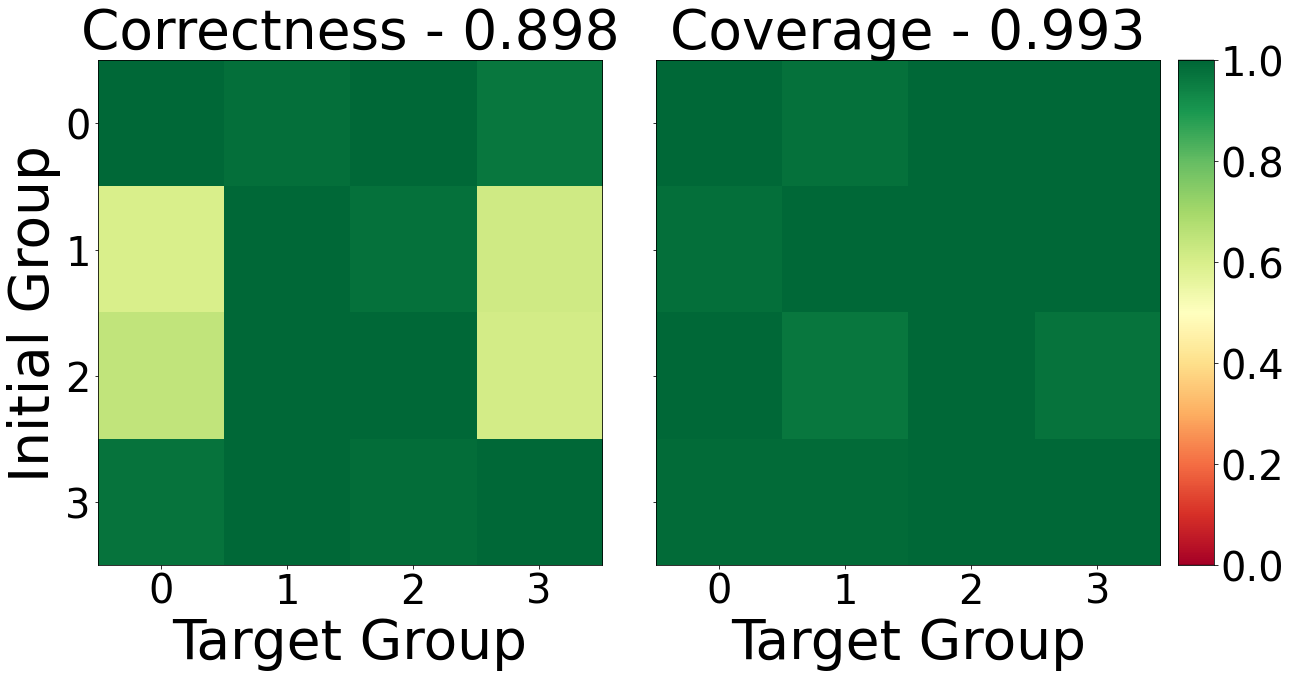

In [12]:
# Evaluate the explanations
deltas = np.load("deltas.npy")

a, b = metrics(model, torch.tensor(x), indices, deltas, epsilon)

plot_metrics(a, b, name = "synth-metrics-ours.png")

In [13]:
deltas

array([[ 0.99914575,  0.17282286, -0.6784542 ,  1.0027591 ],
       [ 1.021035  ,  0.01396981,  0.10259456,  1.0173554 ],
       [ 0.        ,  0.14032221, -0.73339844, -0.00819879]],
      dtype=float32)

In [14]:
def plot_explanation(model, x, data_rep, indices, deltas, a, b, c1, c2,  k = None, num_points = 50, name = "plot_explanation.png", feature_names = None):

    # Find the explanation from c1 to c2
    if c1 == 0:
        d = deltas[c2 - 1]
    elif c2 == 0:
        d = -1.0 * deltas[c1 - 1]
    else:
        d = -1.0 * deltas[c1 - 1] + deltas[c2 - 1]
    
    if k is not None:
        d = truncate(d, k)
        
    d = np.reshape(d, (1, d.shape[0]))
   
    # Visualize the data
    fig, ax = plt.subplots(figsize=(20, 30))
    fig.subplots_adjust(hspace = .3)

    for i in range(2):
        if i == 0:
            initial = c1
            target = c2
            sign = 1.0
        elif i == 1:
            initial = c2
            target = c1
            sign = -1.0

        # Plot the full representation
        ax = plt.subplot(3, 1, i + 1)
        
        plt.scatter(data_rep[:, 0], data_rep[:, 1])
    
        # Sample num_points in initial group
        indices_initial = np.random.choice(indices[initial], num_points, replace = False)
        points_initial = x[indices_initial, :]
    
        # Load the model
        #sess, rep, X, D = load_model()
        d_zeros = np.zeros(d.shape)
    
        # Plot the chosen points before perturbing them
        y_initial = model.Encode(points_initial + d_zeros)#sess.run(rep, feed_dict={X: points_initial, D: d_zeros})
        plt.scatter(y_initial[:,0], y_initial[:,1], marker = "v", c = "magenta")
    
        # Plot the chosen points after perturbing them
        y_after = model.Encode(points_initial + (sign*d)) #sess.run(rep, feed_dict={X: points_initial, D: sign * d})
        plt.scatter(y_after[:,0], y_after[:,1], marker = "v", c = "red")
    
        plt.title("Mapping from Group " + str(initial) + " to Group " + str(target) + "\n Correctness - " + str(np.round(a[initial, target], 3)) + ", Coverage - " + str(np.round(b[initial, target], 3)))
    
    ax = plt.subplot(3, 1, 3)

    feature_index = np.array(range(d.shape[1]))
    plt.scatter(feature_index, d)
    plt.title("Explanation for Group " + str(c1) + " to Group " + str(c2))
    plt.ylabel("Change applied")
    if feature_names is None:
        plt.xlabel("Feature Index")
    else:
        plt.xlabel("Feature")
        plt.xticks(range(d.shape[1]), feature_names, rotation=90, fontsize = 40)

    plt.savefig(name)
    plt.show()
    plt.close()

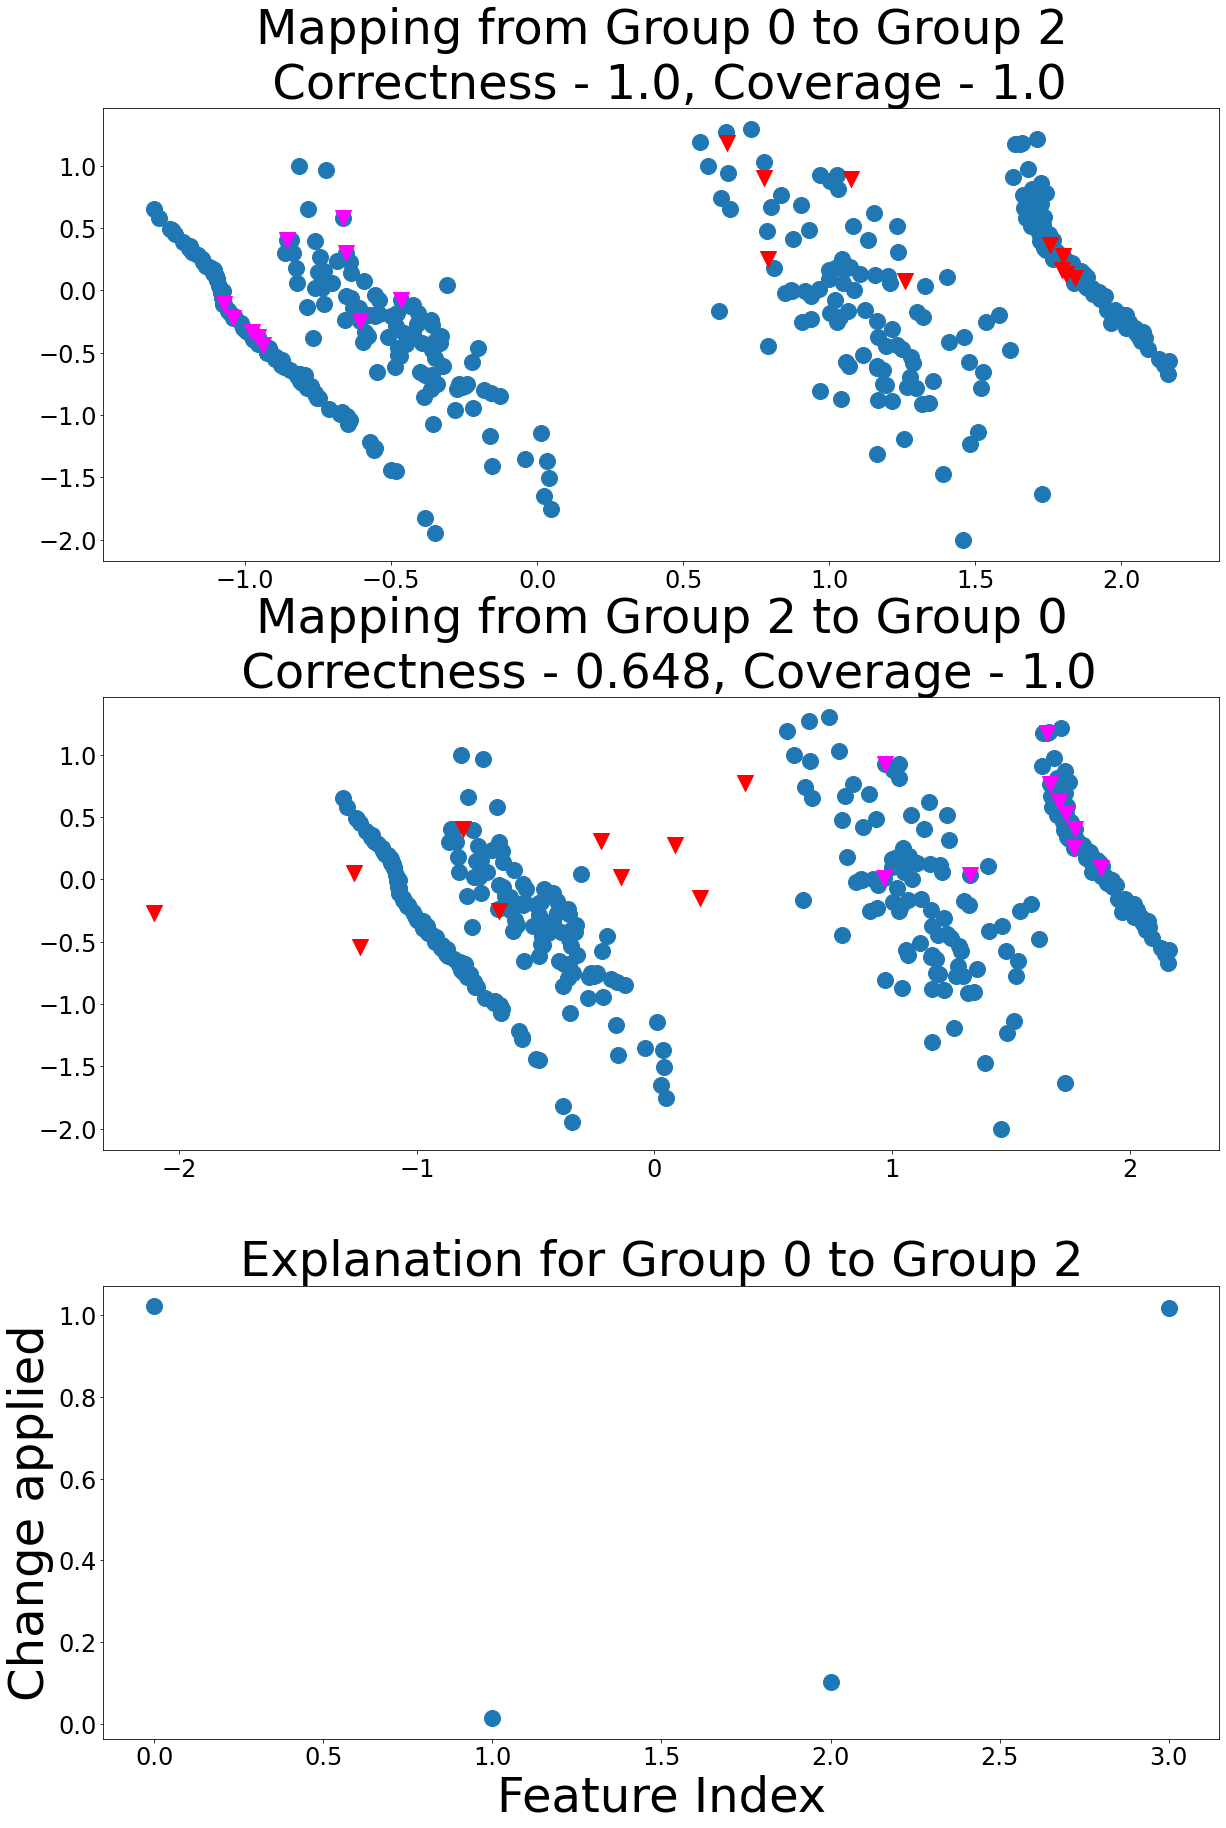

In [15]:
plot_explanation(model, x, rep, indices, deltas, a, b, 0, 2, num_points = 10, name = "tst_synthetic.png")

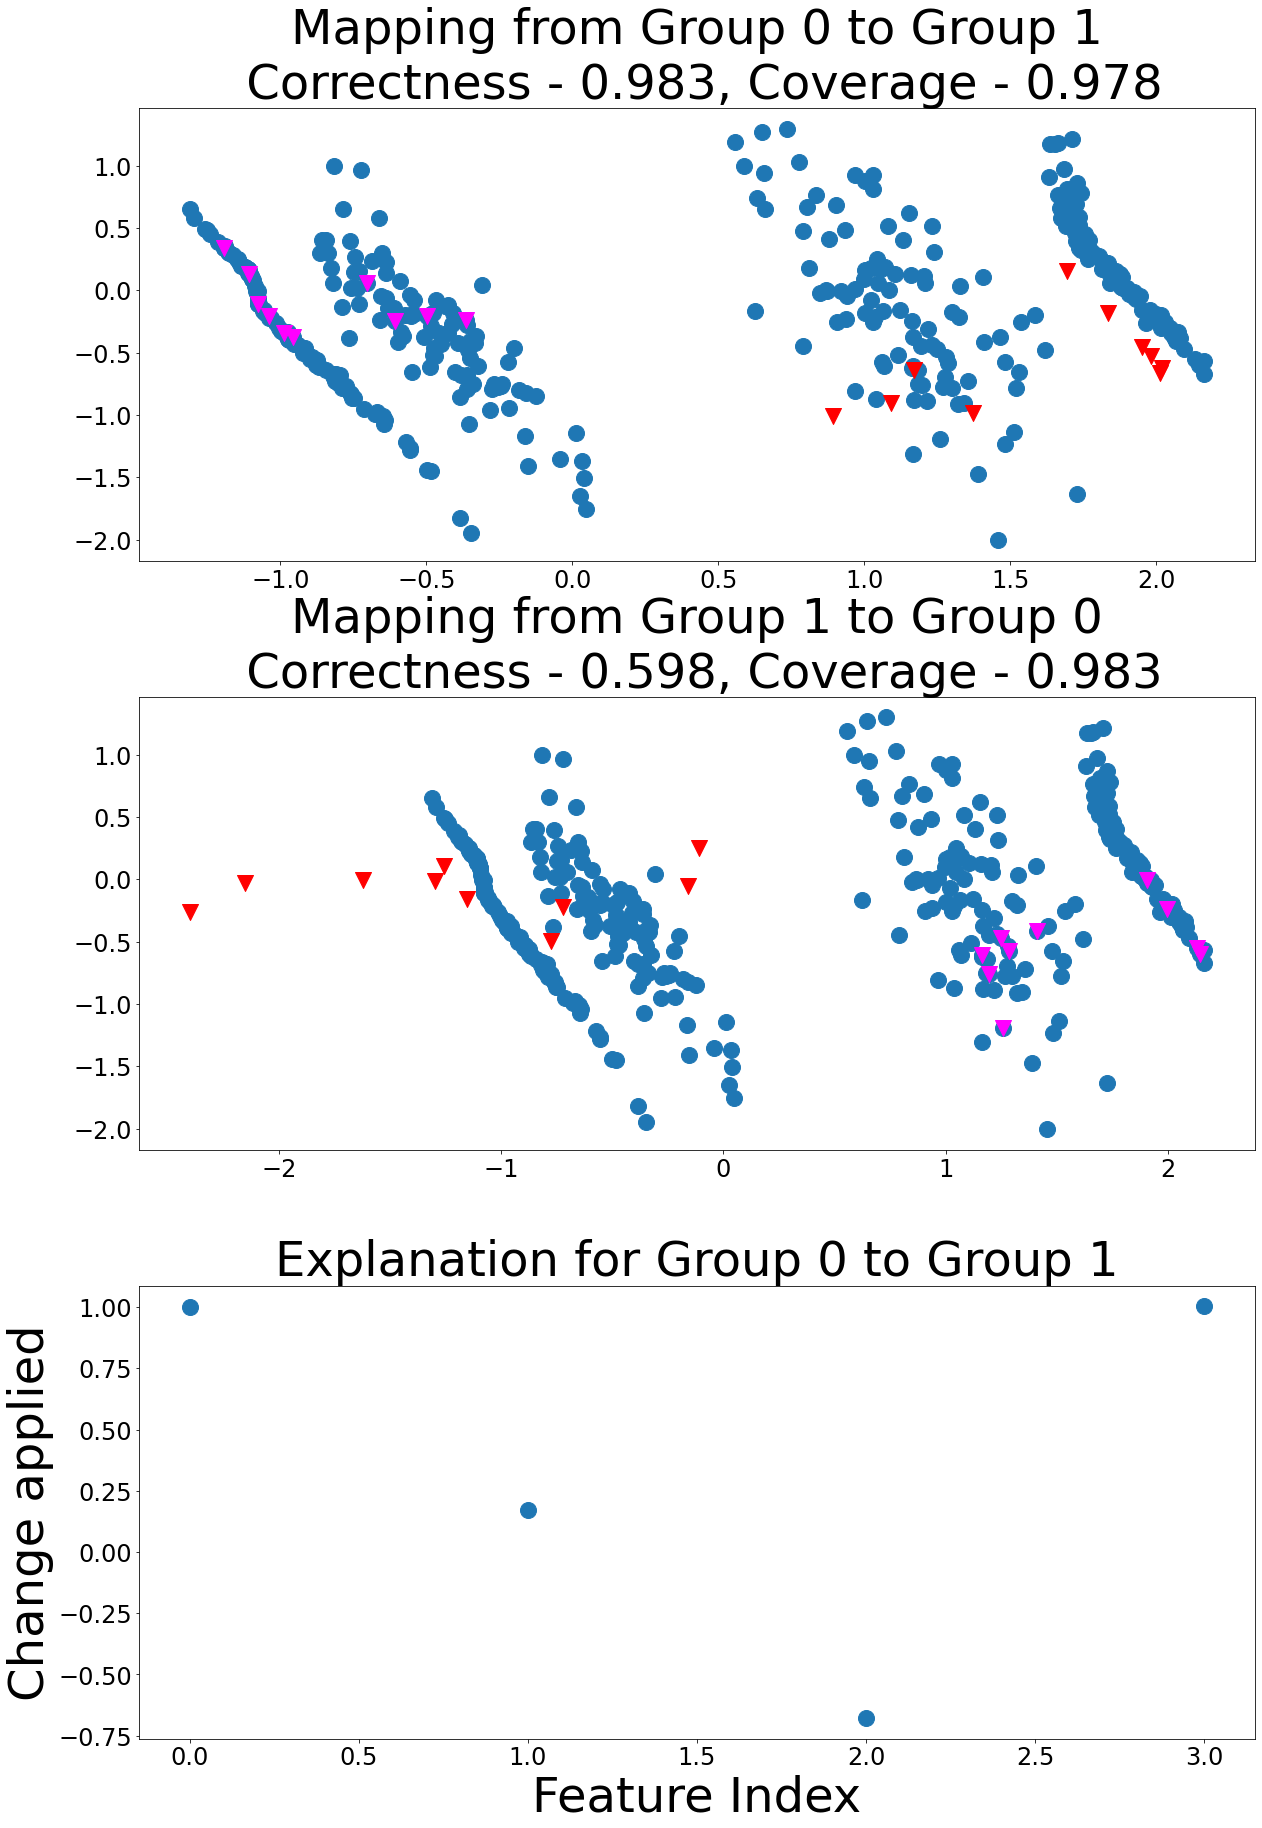

In [16]:
plot_explanation(model, x, rep, indices, deltas, a, b, 0, 1, num_points = 10, name = "tst_synthetic.png")

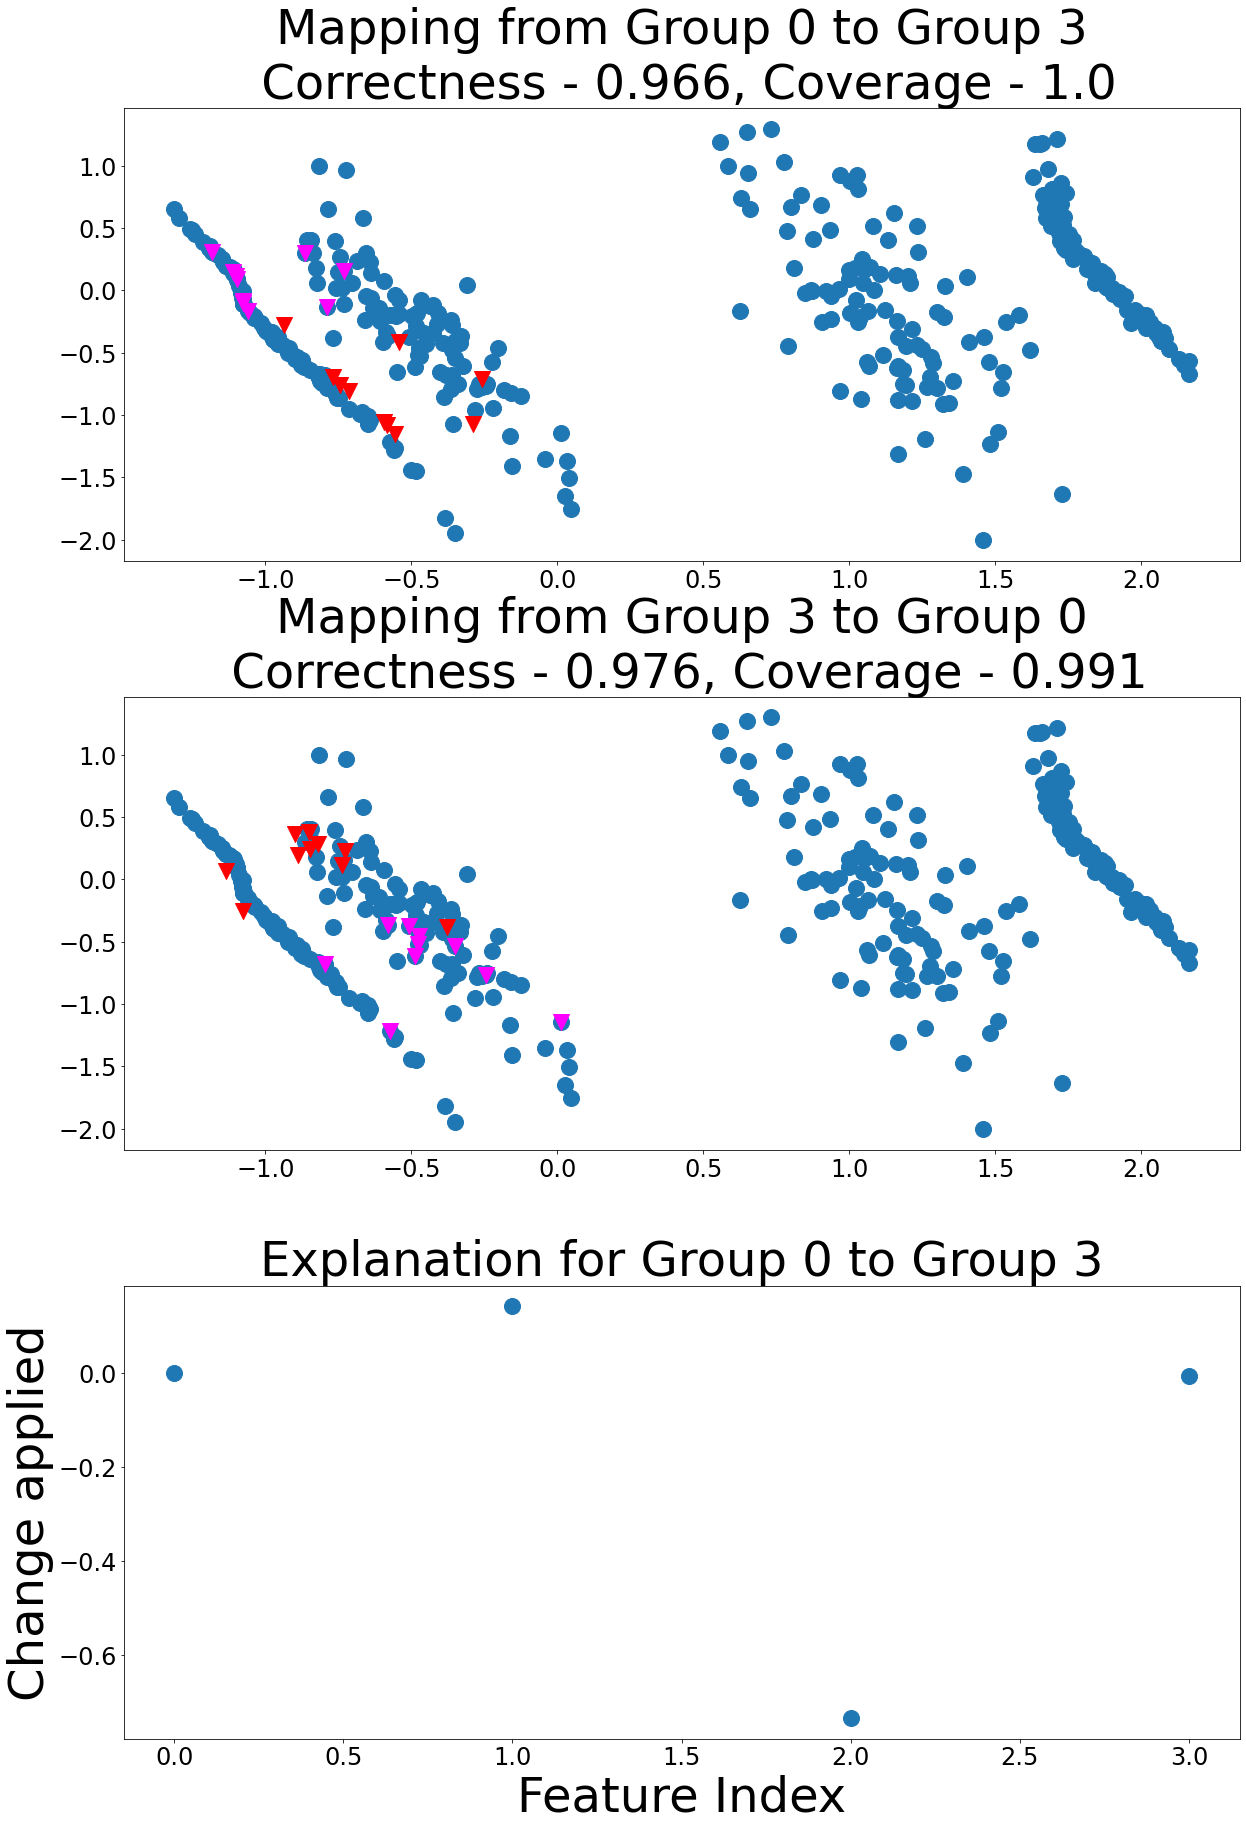

In [17]:
plot_explanation(model, x, rep, indices, deltas, a, b, 0, 3, num_points = 10, name = "tst_synthetic.png")

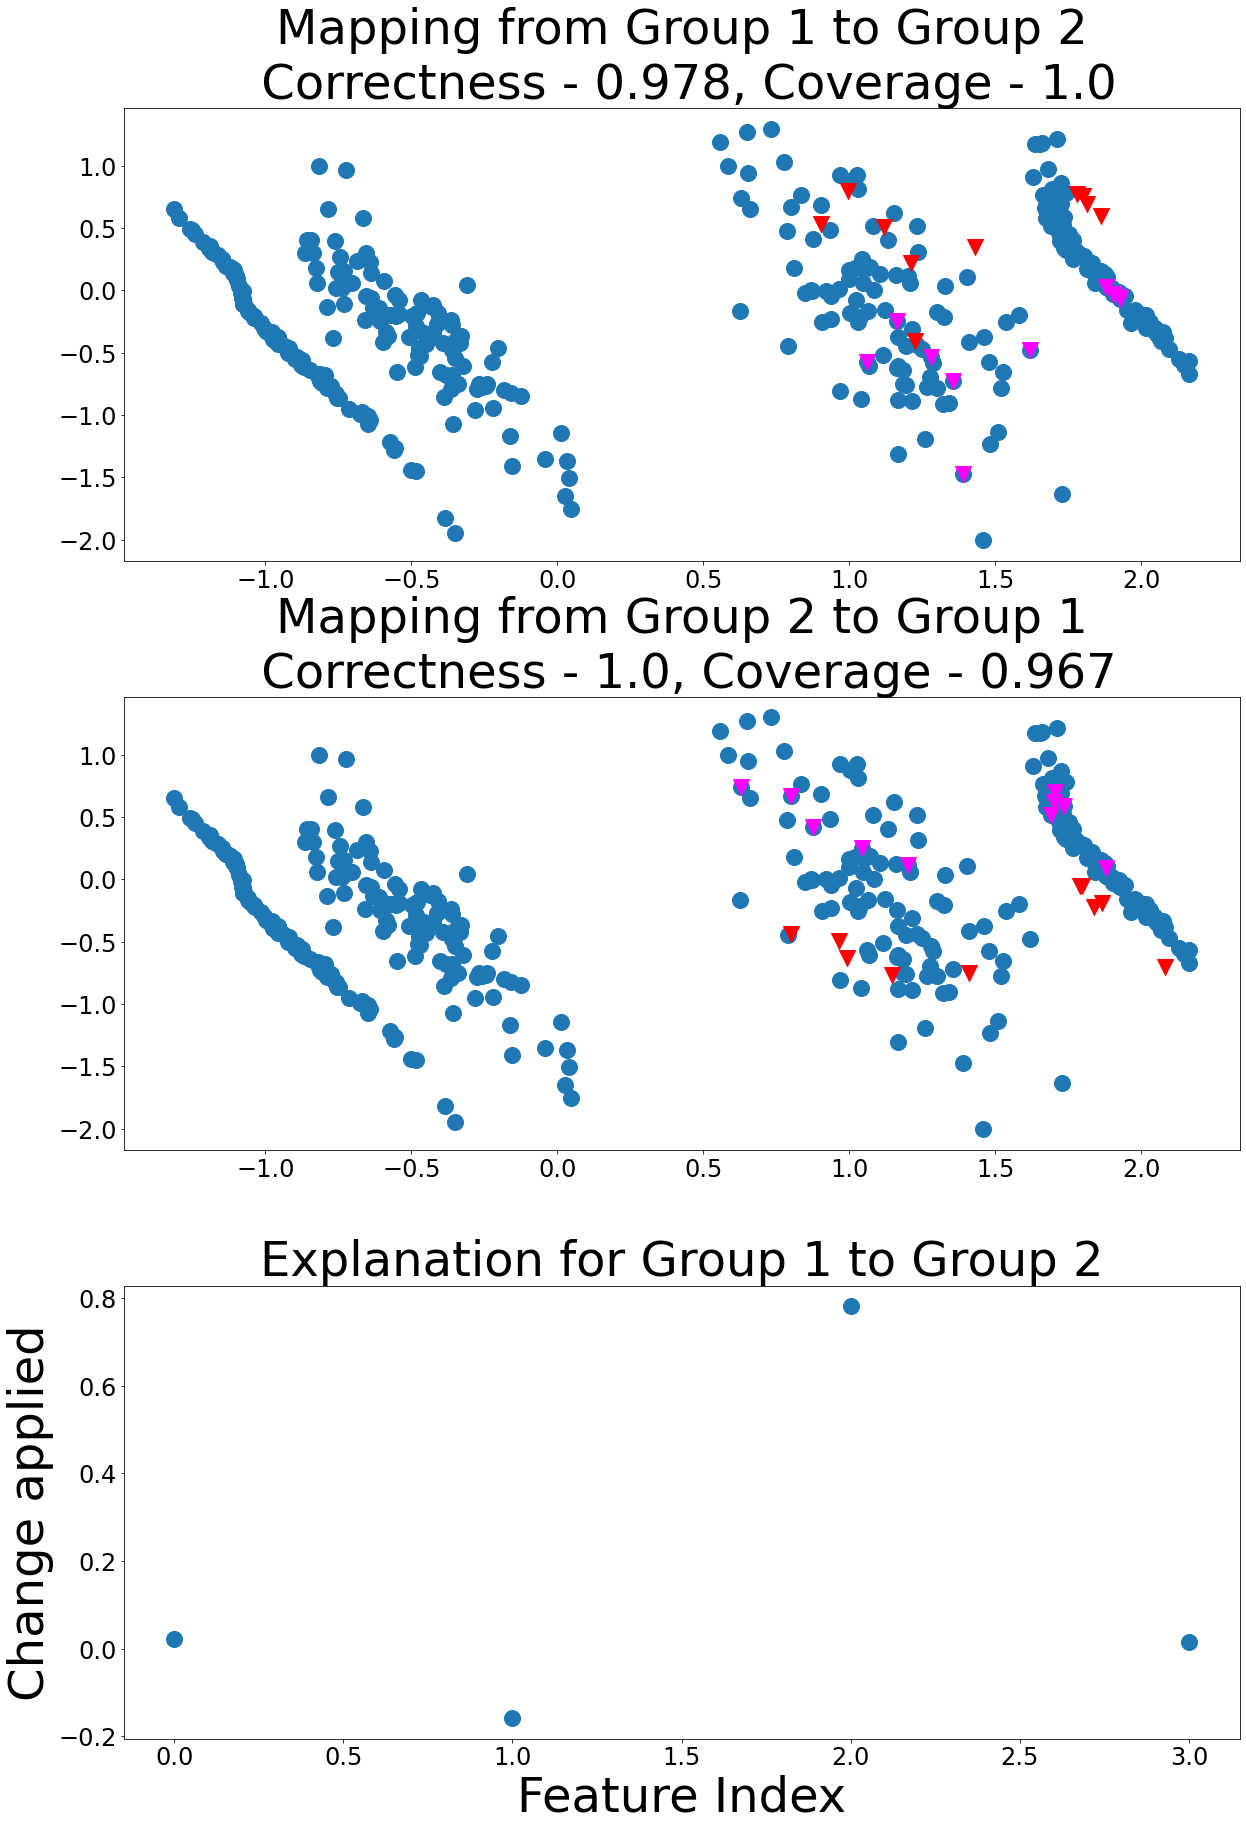

In [18]:
plot_explanation(model, x, rep, indices, deltas, a, b, 1, 2, num_points = 10, name = "tst_synthetic.png")

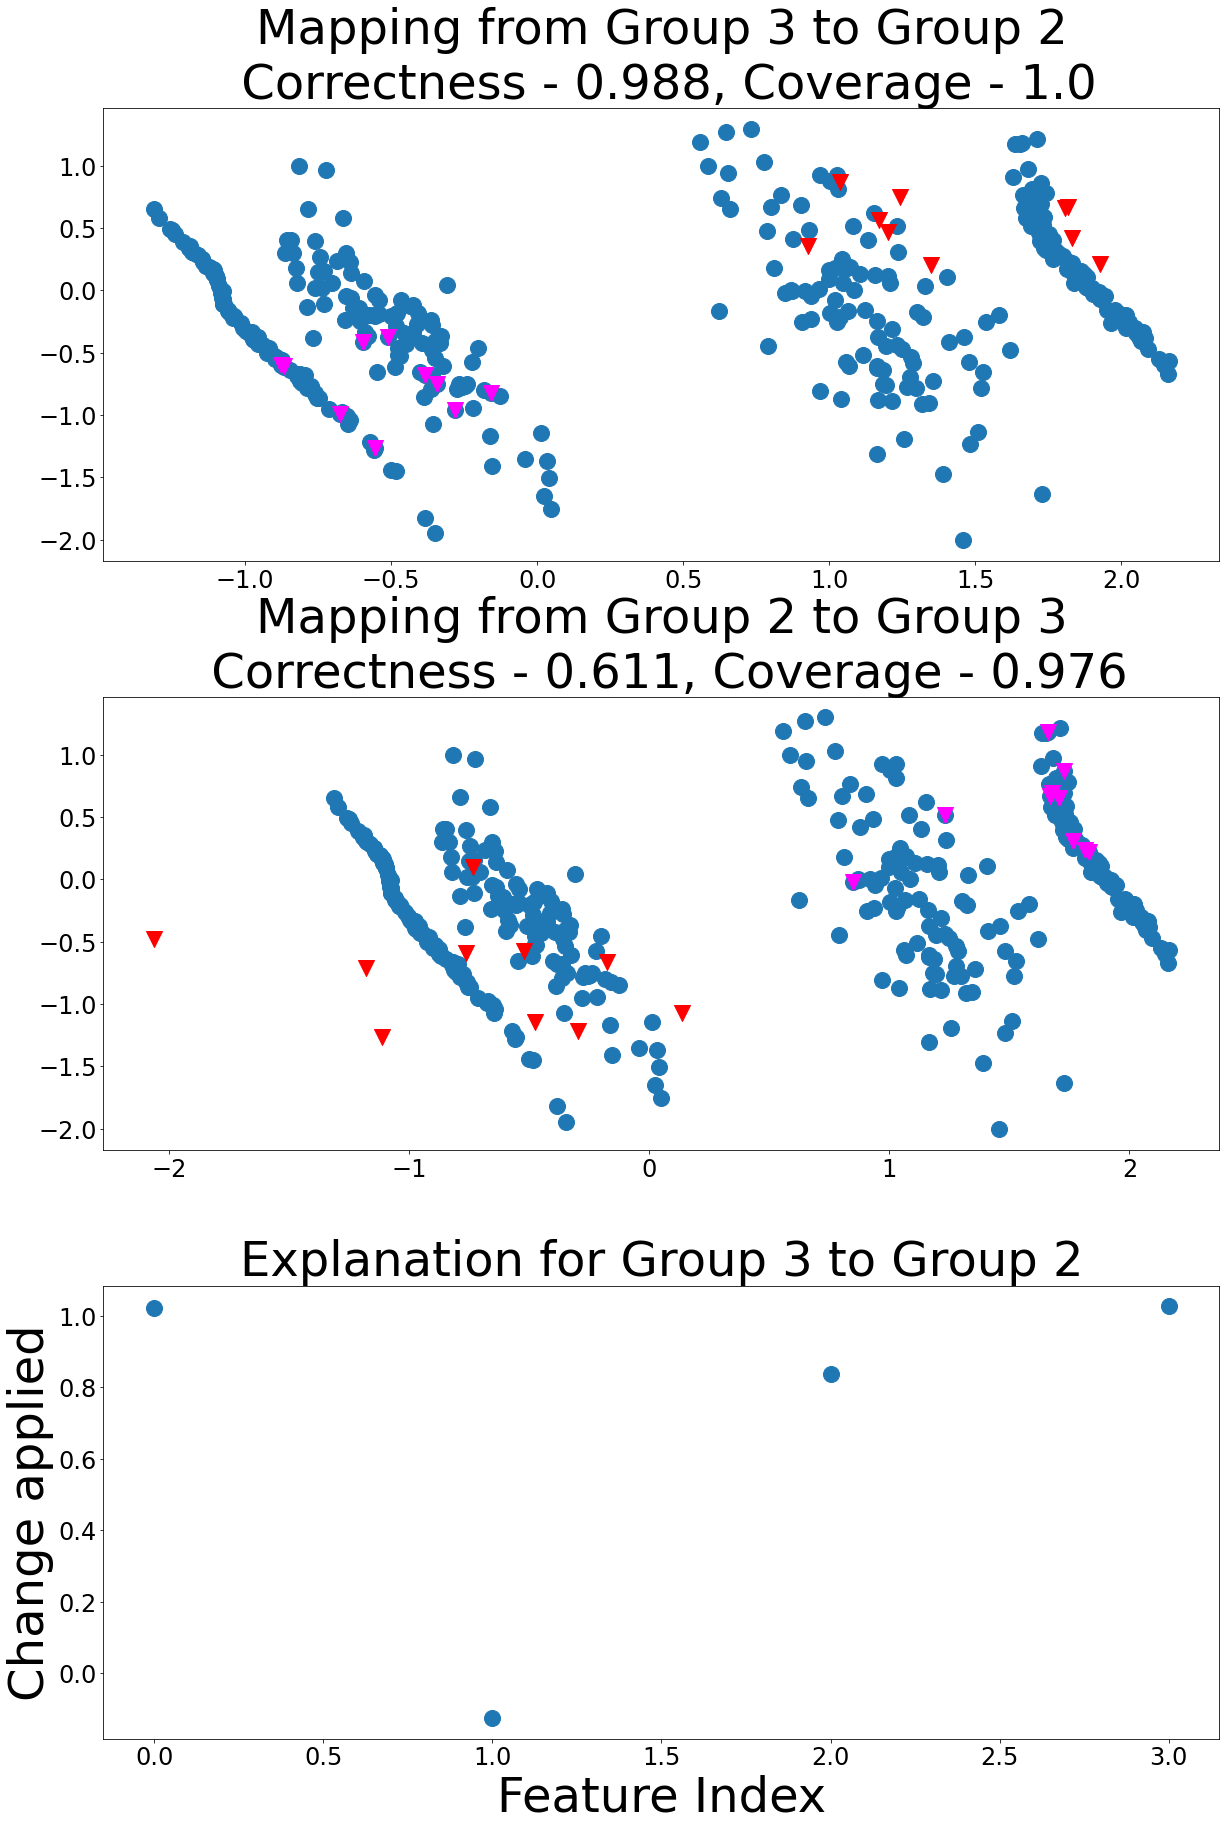

In [19]:
plot_explanation(model, x, rep, indices, deltas, a, b, 3, 2, num_points = 10, name = "tst_synthetic.png")